# CNN + MaxPool
Redo CNN_183 with code from CNN_185 that flips the GMM labels as needed.

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2023-02-14 17:22:08.886358
Python 3.8.10
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64
FILTERSIZE=16
RCELLS=32
DCELLS=16
EPOCHS=3
FOLDS=10      
EMBED_DIMEN = 4 # arbitrary hyperparameter
MINLEN=200
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM' # 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
CACHING = False   # have not worked out how to cache multiple cell lines
NUM_LINES = 15   # 15 to analyze all of them

In [3]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/


In [4]:
RCI_FILE =      'CNRCI_noncoding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_noncoding_train_transcripts.gc42.csv'
CACHE_SEQUENCE = 'cache.seq.pickle'
CACHE_IDS = 'cache.id.pickle'
if CACHING:
    cache_seq = DATA_DIR+CACHE_SEQUENCE 
    cache_ids = DATA_DIR+CACHE_IDS 
    if isfile(cache_seq) and isfile(cache_ids):
        print('WARNING: this run will read sequence from cache.')
    else:
        print('INFO: this run will write sequence to cache.')

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

EXCLUSIONS = [1,7]   # use these though they are clearly different

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    rci_str = fields[cell_line]
                    if rci_str != "nan":
                        rci_val = float(rci_str)
                        gene_to_rci[gene_id] = rci_val
        print('Number of RCI values loaded',len(gene_to_rci.keys()))
        return gene_to_rci

    def seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        allids=[]
        allseq=[]
        cache_seq = DATA_DIR+CACHE_SEQUENCE 
        cache_ids = DATA_DIR+CACHE_IDS 
        if CACHING and isfile(cache_seq) and isfile(cache_ids):
            # Warning: the cache may represent the wrong K.
            with open(cache_seq,'rb') as fin:
                allseq = pickle.load(fin)
            with open(cache_ids,'rb') as fin:
                allids = pickle.load(fin)
            return allids,allseq           
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        if CACHING:
            with open(cache_seq,'wb') as fout:
                pickle.dump(allseq,fout)
            with open(cache_ids,'wb') as fout:
                pickle.dump(allids,fout)
        return allids,allseq

## Model

In [7]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    #pool_layer = GlobalAveragePooling1D()
    flat_layer = Flatten()
    dens_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool_layer)
    cnn.add(flat_layer)
    cnn.add(dens_layer)
    cnn.add(drop_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-02-14 17:22:46.481242
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 4982, 64)          4160      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 621, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 39744)             0         
                                                                 
 dense (Dense)               (None, 16)                635920    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                             

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False    
        
    def set_sequences(self, allids, allseq):
        # It is critical to keep IDs and sequences in same order!
        self.all_ids = allids  # pairs of (gene_id,tran_id)
        self.all_seqs = allseq  # may be vectors of K-mers
        genes = []
        for i in range(len(allids)):
            (one_gene,one_tran) = allids[i]
            genes.append(one_gene)
        self.all_genes = genes
            
    def set_rci_map(self, gene_to_rci):
        # The map is for fast lookup, not gene order!
        self.rci_map = gene_to_rci # map gene_id to RCI value
    
    def get_gene_subset(self, sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = self.all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes   # this is a set: unordered with fast lookup
    
    def _get_X_y(self, gene_index):
        cnt = len(self.all_ids)
        subsetX=[]
        subsetY=[]
        next_index = 0
        for i in range(cnt):
            if next_index==len(gene_index):
                break
            if i==gene_index[next_index]:
                gene_id,tran_id = self.all_ids[i]
                oneX = self.all_seqs[i]
                oneY = self.rci_map[gene_id]
                subsetX.append(oneX)
                subsetY.append(oneY)
                next_index += 1
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        '''Takes list of float, returns list of labels [0,1].'''
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values):
        if self.mechanism == 'RCI_GMM':
            gmm = GaussianMixture(n_components=2, verbose=0, 
                covariance_type='spherical', n_init=100) 
            gmm.fit(rci_values)
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm
        elif RCI_THRESHOLD_MECHANISM == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        else:
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-2,-1.5,-1,-0.5,0,0.5,1,1.5,2]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
        
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        cv_auprc=[]
        cv_auroc=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        splits = splitter.split(self.all_genes)
        splitter = None
        for train_index,valid_index in splits:
            fold += 1
            print('Fold',fold)
            X_train,y_rci = self._get_X_y(train_index)
            self._prepare_threshold(y_rci)  # use train subset only!
            self._explain_threshold()
            y_train = self._apply_threshold(y_rci)
            X_valid,y_rci = self._get_X_y(valid_index)
            y_valid = self._apply_threshold(y_rci) 
            y_rci = None

            #print('Training example')
            #print(X_train[0])
            #print("BUILD MODEL")
            model=build_model()
            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
              epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none
              validation_data=(X_valid,y_valid) )
            print("PREDICT")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0)             
            yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            # PRC
            prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
            auprc = auc(prc_X,prc_Y)*100.
            auroc = roc_auc_score(y_valid, yhat_pred)*100.

            if PRETTY_PICTURES:
                pd.DataFrame(history.history).plot(figsize=(8,5))
                plt.grid(True)
                plt.gca().set_ylim(0,1)
                plt.show()

                print('Train set ones/size',
                      np.count_nonzero(y_train),'/',len(y_train))
                print("Compute valiation accuracy")
                print('Valid sizes',X_valid.shape,y_valid.shape)
                print('Valid set ones/size',
                      np.count_nonzero(y_valid),'/',len(y_valid))
                print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
                print('Score threshold',self.score_threshold)
                print('Prediction set ones/size',
                      np.count_nonzero(yhat_classes),'/',len(yhat_classes))

                count_ones= len(y_valid[y_valid==1])
                count_zeros= len(y_valid[y_valid==0])
                guess = max(count_ones,count_zeros) / len(y_valid)
                plt.plot(prc_X, prc_Y, marker='.')
                plt.plot([0, 1], [guess,guess], linestyle='--')
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                plt.show()
                # ROC
                fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
                plt.plot(fpr, tpr, marker='.')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.show()

            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% AUPRC: %.2f%% AUROC: %.2f%%' % (f1,auprc,auroc)) 
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            cv_auprc.append(auprc)
            cv_auroc.append(auroc)
            
            print(datetime.now())
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break

            # There is a memory leak within the fit() command!
            # Each successive call to fit() consumes more memory.
            model = None
            history = None
            prc_Y = None
            prc_X = None
            prc_bins = None
            yhat_classes = None
            X_train = None
            y_train = None
            X_valid = None
            y_valid = None
            tf.keras.backend.clear_session()
            gc.collect()
            time.sleep(1)  # hope gc kicks in
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auprc, cv_auroc

2023-02-14 17:22:49.831083
Start cell Line 0 A549
Number of RCI values loaded 1447
Num RCI: 1447
Load sequence...
Cross validation...
2023-02-14 17:23:07.175459
splitting
Fold 1
Discriminator is GMM
Means [0.5881014334111202, -0.9678325470898171]
Variances [0.87635584 1.89368705]
Priors [0.57534182 0.42465818]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:23:16.724946
PREDICT
2023-02-14 17:23:39.339861


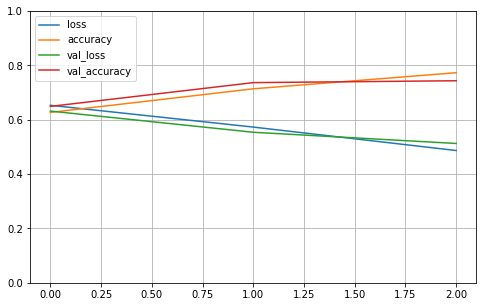

Train set ones/size 4913 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 515 / 869
Range of scores: 0.02865123 to 0.9890876
Score threshold 0.5
Prediction set ones/size 612 / 869


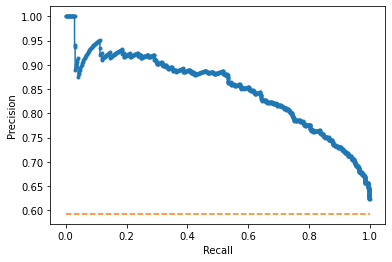

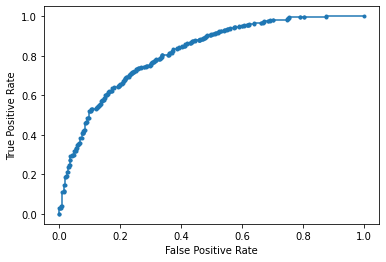

Accuracy: 74.34% Precision: 73.86% Recall: 87.77%
F1: 80.21% AUPRC: 84.99% AUROC: 81.70%
2023-02-14 17:23:40.283378
Fold 2
Discriminator is GMM
Means [0.5763394475452824, -0.9765509180267571]
Variances [0.88489623 1.89856066]
Priors [0.57160942 0.42839058]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:23:55.160290
PREDICT
2023-02-14 17:24:04.679882


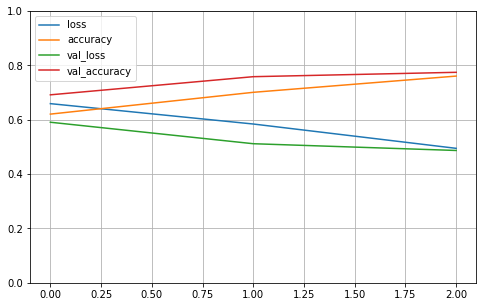

Train set ones/size 4909 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 566 / 869
Range of scores: 0.015412268 to 0.98817897
Score threshold 0.5
Prediction set ones/size 666 / 869


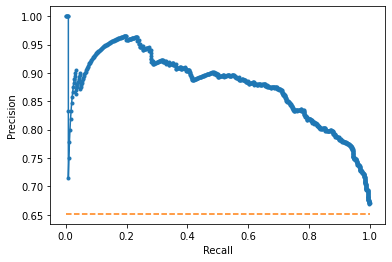

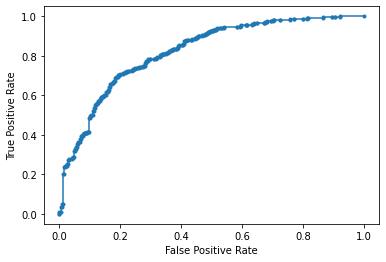

Accuracy: 77.45% Precision: 77.78% Recall: 91.52%
F1: 84.09% AUPRC: 87.65% AUROC: 82.22%
2023-02-14 17:24:05.373127
Fold 3
Discriminator is GMM
Means [0.5689494735279258, -0.9443758540008718]
Variances [0.87123385 1.95010908]
Priors [0.57077302 0.42922698]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:24:16.366390
PREDICT
2023-02-14 17:24:25.309210


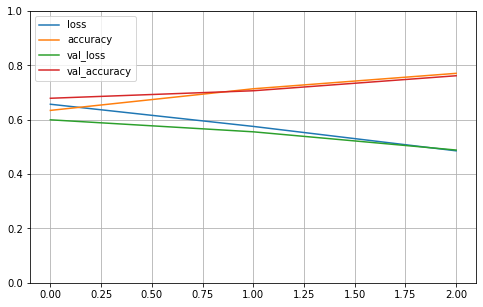

Train set ones/size 4920 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 555 / 869
Range of scores: 0.015364794 to 0.9936668
Score threshold 0.5
Prediction set ones/size 608 / 869


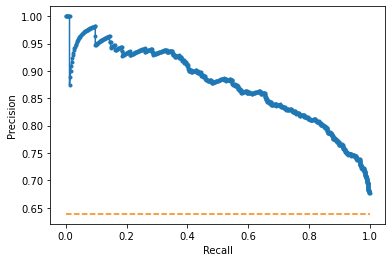

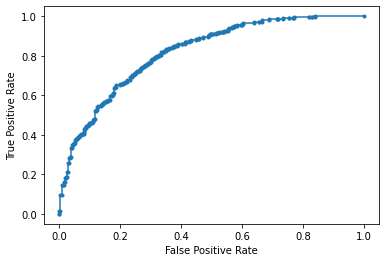

Accuracy: 76.18% Precision: 78.62% Recall: 86.13%
F1: 82.20% AUPRC: 87.49% AUROC: 81.87%
2023-02-14 17:24:26.426334
Fold 4
Discriminator is GMM
Means [0.5680942457359044, -0.9470242320966012]
Variances [0.89685098 1.97641118]
Priors [0.57777174 0.42222826]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:24:38.661780
PREDICT
2023-02-14 17:24:50.396280


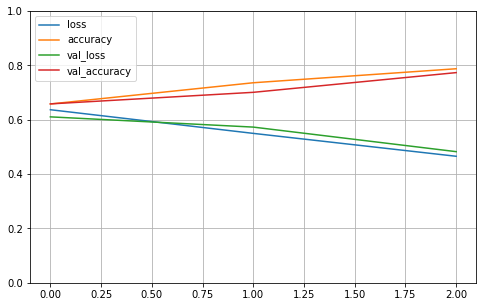

Train set ones/size 5115 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 556 / 869
Range of scores: 0.006185514 to 0.99381906
Score threshold 0.5
Prediction set ones/size 627 / 869


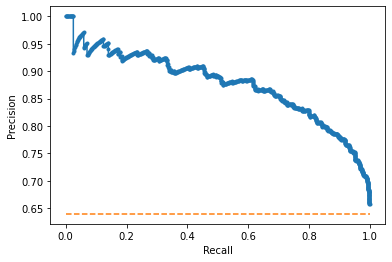

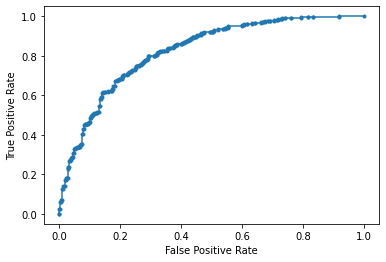

Accuracy: 77.33% Precision: 78.63% Recall: 88.67%
F1: 83.35% AUPRC: 87.65% AUROC: 82.44%
2023-02-14 17:24:51.561108
Fold 5
Discriminator is GMM
Means [-0.9373970955801725, 0.5587217837853166]
Variances [1.98053463 0.88676987]
Priors [0.42631385 0.57368615]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:25:03.367281
PREDICT
2023-02-14 17:25:15.292847


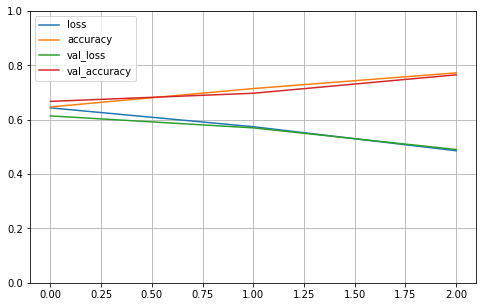

Train set ones/size 5011 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 553 / 869
Range of scores: 0.0174972 to 0.9933216
Score threshold 0.5
Prediction set ones/size 621 / 869


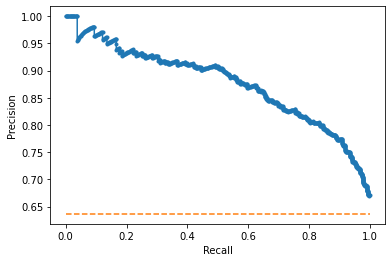

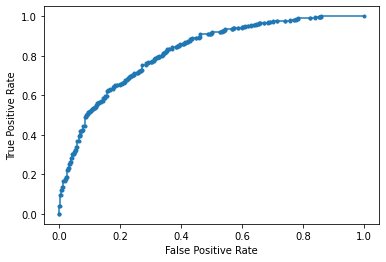

Accuracy: 76.52% Precision: 78.10% Recall: 87.70%
F1: 82.62% AUPRC: 87.72% AUROC: 81.93%
2023-02-14 17:25:16.066925
Fold 6
Discriminator is GMM
Means [-0.9912541621415334, 0.5861835491755103]
Variances [1.90554887 0.88180148]
Priors [0.42447711 0.57552289]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:25:28.035550
PREDICT
2023-02-14 17:25:37.570849


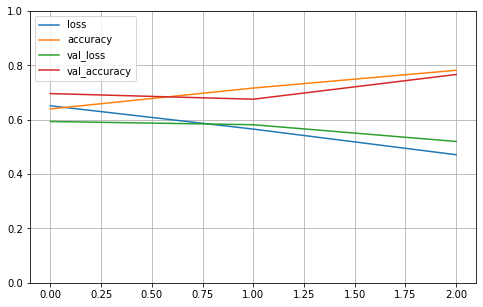

Train set ones/size 4912 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 564 / 869
Range of scores: 0.024156362 to 0.99862003
Score threshold 0.5
Prediction set ones/size 703 / 869


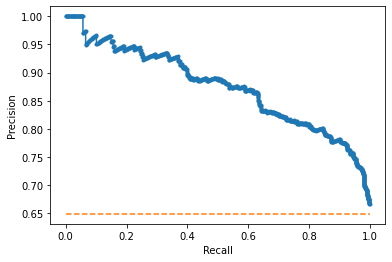

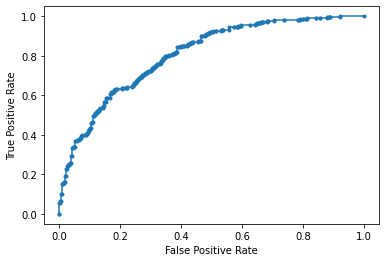

Accuracy: 76.64% Precision: 75.68% Recall: 94.33%
F1: 83.98% AUPRC: 87.47% AUROC: 80.65%
2023-02-14 17:25:38.289100
Fold 7
Discriminator is GMM
Means [0.5978396080645902, -0.9610519582460468]
Variances [0.88851043 1.84837778]
Priors [0.57016285 0.42983715]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:25:51.889523
PREDICT
2023-02-14 17:26:03.371800


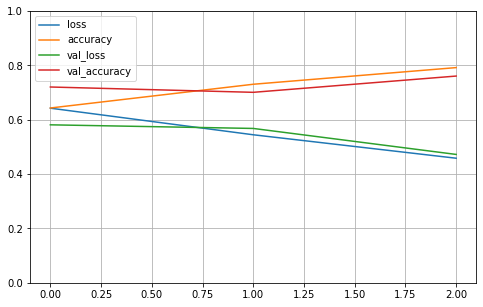

Train set ones/size 4875 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 535 / 869
Range of scores: 0.0030019986 to 0.99474865
Score threshold 0.5
Prediction set ones/size 489 / 869


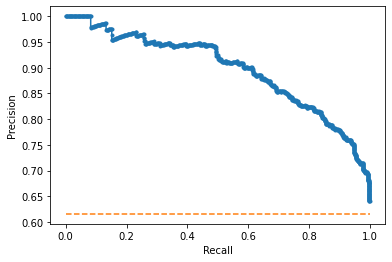

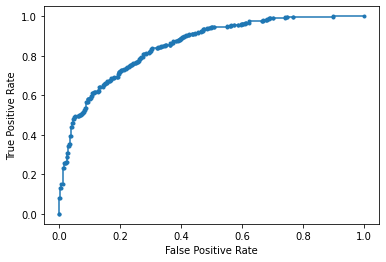

Accuracy: 76.06% Precision: 83.44% Recall: 76.26%
F1: 79.69% AUPRC: 89.71% AUROC: 85.27%
2023-02-14 17:26:04.062190
Fold 8
Discriminator is GMM
Means [-0.9419633895360141, 0.5670442097247654]
Variances [1.96771895 0.9025308 ]
Priors [0.4251011 0.5748989]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:26:16.169710
PREDICT
2023-02-14 17:26:25.280475


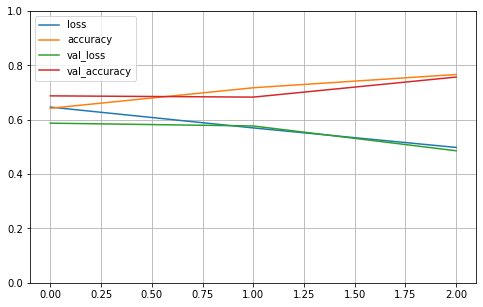

Train set ones/size 5010 / 7819
Compute valiation accuracy
Valid sizes (868, 4997) (868,)
Valid set ones/size 554 / 868
Range of scores: 0.014214639 to 0.9955551
Score threshold 0.5
Prediction set ones/size 567 / 868


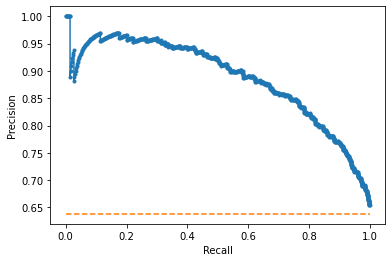

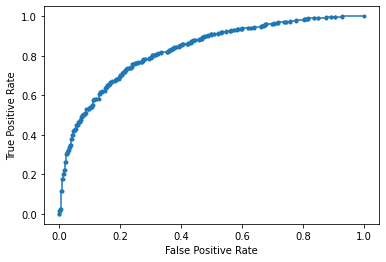

Accuracy: 75.69% Precision: 80.25% Recall: 82.13%
F1: 81.18% AUPRC: 88.78% AUROC: 82.96%
2023-02-14 17:26:26.199968
Fold 9
Discriminator is GMM
Means [0.5551048830654349, -0.9336827672381075]
Variances [0.87575272 1.9573652 ]
Priors [0.5725715 0.4274285]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:26:38.279726
PREDICT
2023-02-14 17:26:47.113614


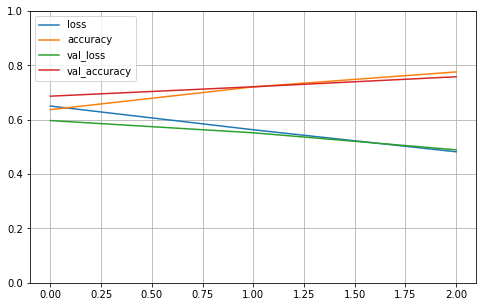

Train set ones/size 4977 / 7819
Compute valiation accuracy
Valid sizes (868, 4997) (868,)
Valid set ones/size 549 / 868
Range of scores: 0.009201498 to 0.9922192
Score threshold 0.5
Prediction set ones/size 573 / 868


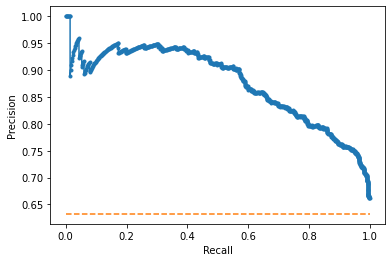

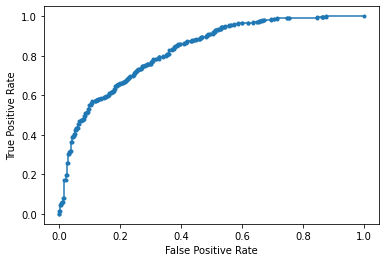

Accuracy: 75.81% Precision: 79.58% Recall: 83.06%
F1: 81.28% AUPRC: 87.63% AUROC: 82.64%
2023-02-14 17:26:47.857835
Fold 10
Discriminator is GMM
Means [-0.9415552313878942, 0.5684472440098552]
Variances [1.95845933 0.88136011]
Priors [0.42845944 0.57154056]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:27:02.146409
PREDICT
2023-02-14 17:27:14.063727


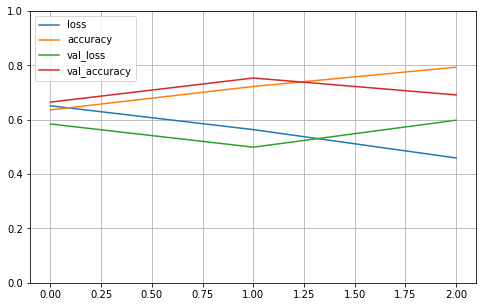

Train set ones/size 4921 / 7819
Compute valiation accuracy
Valid sizes (868, 4997) (868,)
Valid set ones/size 555 / 868
Range of scores: 0.0027157601 to 0.99203146
Score threshold 0.5
Prediction set ones/size 373 / 868


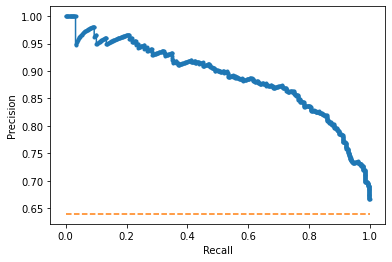

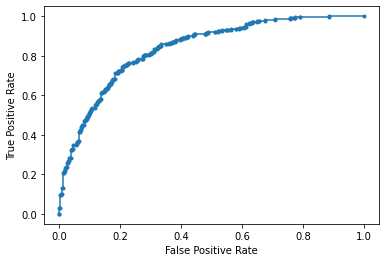

Accuracy: 69.12% Precision: 88.47% Recall: 59.46%
F1: 71.12% AUPRC: 88.95% AUROC: 83.74%
2023-02-14 17:27:14.942436

Completed cross validation 10 folds 3 epochs
 accuracy mean 75.51% +/- 2.41
 precision mean 79.44% +/- 4.08
 recall mean 83.70% +/- 9.91
 F1 mean 80.97% +/- 3.77
 AUPRC mean 87.80% +/- 1.25
 AUROC mean 82.54% +/- 1.26
Finished cell Line 0 A549

2023-02-14 17:27:16.347171
Start cell Line 1 H1.hESC
Number of RCI values loaded 3327
Num RCI: 3327
Load sequence...
Cross validation...
2023-02-14 17:27:42.459183
splitting
Fold 1
Discriminator is GMM
Means [-0.943391510621054, 0.42572198661596033]
Variances [1.3773158  1.38963576]
Priors [0.51987828 0.48012172]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 0 1 1 1 1 1]
FIT
2023-02-14 17:27:57.611842
PREDICT
2023-02-14 17:28:13.714575


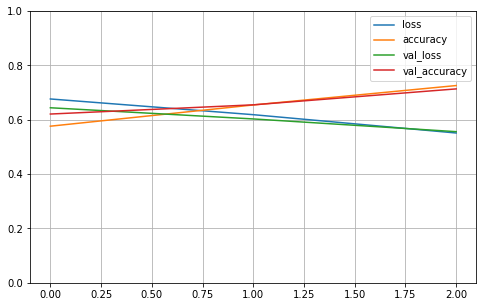

Train set ones/size 6896 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 783 / 1654
Range of scores: 0.01563495 to 0.9884593
Score threshold 0.5
Prediction set ones/size 671 / 1654


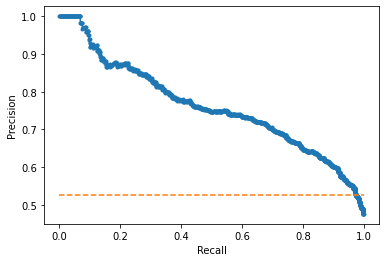

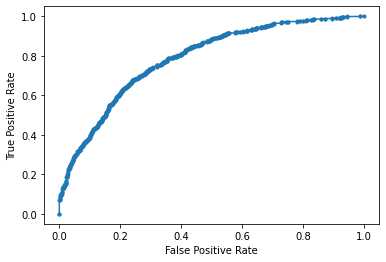

Accuracy: 71.34% Precision: 73.03% Recall: 62.58%
F1: 67.40% AUPRC: 76.22% AUROC: 78.66%
2023-02-14 17:28:14.662440
Fold 2
Discriminator is GMM
Means [0.43922577494415677, -0.9258033751531519]
Variances [1.40518122 1.3712376 ]
Priors [0.47546273 0.52453727]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 0 1 1 1 1 1]
FIT
2023-02-14 17:28:29.807387
PREDICT
2023-02-14 17:28:45.387077


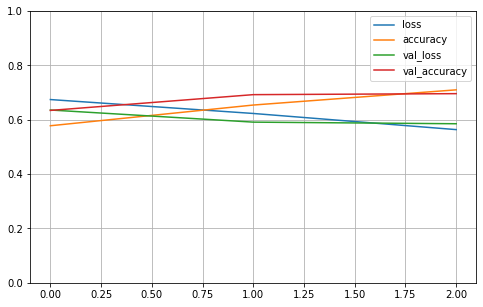

Train set ones/size 6772 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 730 / 1654
Range of scores: 0.0019215617 to 0.9903763
Score threshold 0.5
Prediction set ones/size 395 / 1654


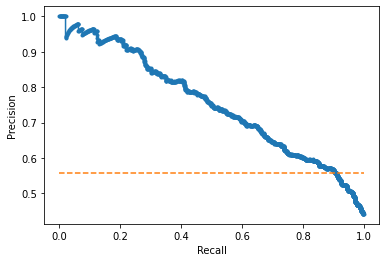

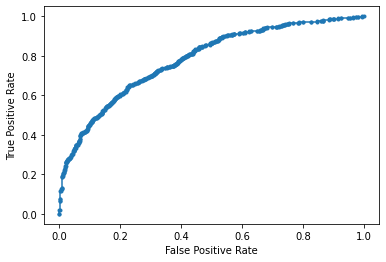

Accuracy: 69.59% Precision: 78.73% Recall: 42.60%
F1: 55.29% AUPRC: 75.36% AUROC: 78.21%
2023-02-14 17:28:46.287962
Fold 3
Discriminator is GMM
Means [0.42711573697499056, -0.9333524382083046]
Variances [1.41814568 1.38757313]
Priors [0.4768291 0.5231709]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 0 1 1 1 1 1]
FIT
2023-02-14 17:29:04.770919
PREDICT
2023-02-14 17:29:27.466426


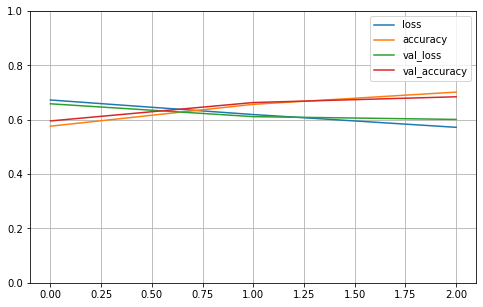

Train set ones/size 6783 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 760 / 1654
Range of scores: 0.010786847 to 0.9770981
Score threshold 0.5
Prediction set ones/size 546 / 1654


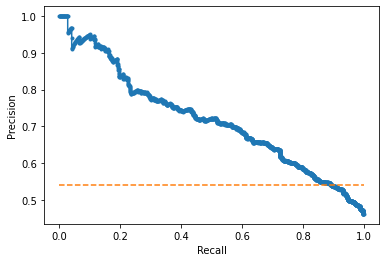

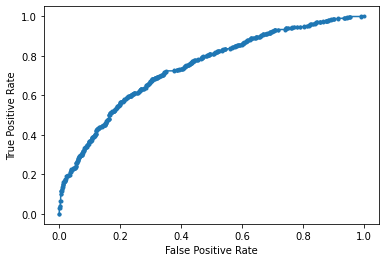

Accuracy: 68.44% Precision: 71.79% Recall: 51.58%
F1: 60.03% AUPRC: 71.95% AUROC: 74.33%
2023-02-14 17:29:28.304862
Fold 4
Discriminator is GMM
Means [-0.9308386066861382, 0.42431589306206774]
Variances [1.37698381 1.41813791]
Priors [0.522761 0.477239]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 0 1 1 1 1 1]
FIT
2023-02-14 17:29:46.429914
PREDICT
2023-02-14 17:30:02.455061


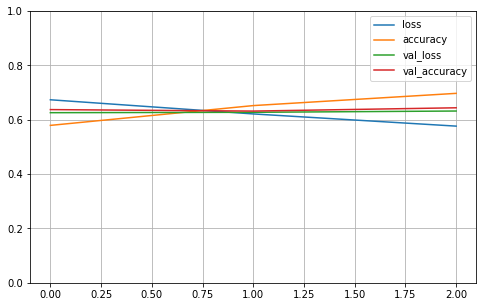

Train set ones/size 6780 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 763 / 1654
Range of scores: 0.020577025 to 0.99314594
Score threshold 0.5
Prediction set ones/size 1208 / 1654


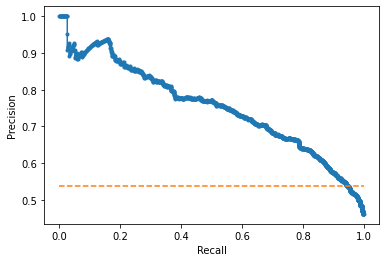

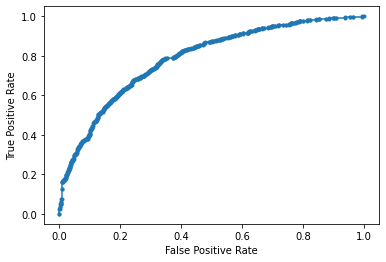

Accuracy: 64.39% Precision: 57.20% Recall: 90.56%
F1: 70.12% AUPRC: 75.47% AUROC: 78.62%
2023-02-14 17:30:03.416523
Fold 5
Discriminator is GMM
Means [-0.9370822546055996, 0.42259762019179764]
Variances [1.3698043  1.40089672]
Priors [0.52321871 0.47678129]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 0 1 1 1 1 1]
FIT
2023-02-14 17:30:18.653614
PREDICT
2023-02-14 17:30:40.846517


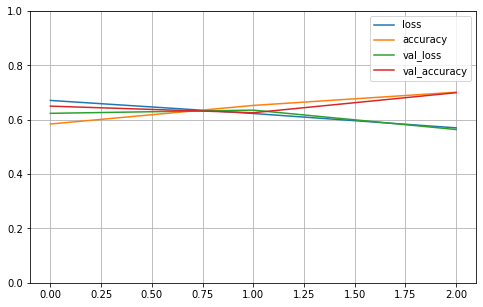

Train set ones/size 6789 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 783 / 1654
Range of scores: 0.012252638 to 0.9723923
Score threshold 0.5
Prediction set ones/size 648 / 1654


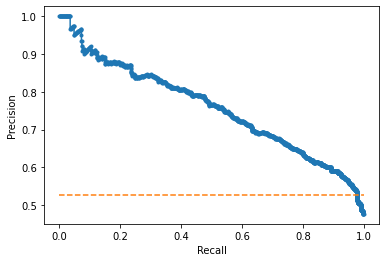

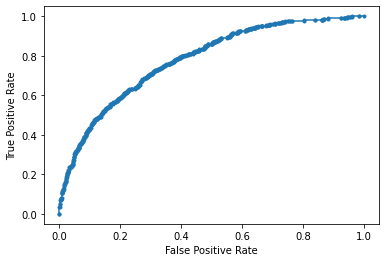

Accuracy: 69.95% Precision: 72.07% Recall: 59.64%
F1: 65.27% AUPRC: 75.84% AUROC: 78.08%
2023-02-14 17:30:41.713124
Fold 6
Discriminator is GMM
Means [-0.9295966724577156, 0.4368738072956093]
Variances [1.38707939 1.43653616]
Priors [0.52890174 0.47109826]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 0 1 1 1 1 1]
FIT
2023-02-14 17:30:59.329325
PREDICT
2023-02-14 17:31:15.254510


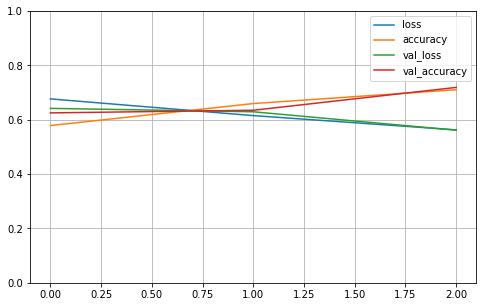

Train set ones/size 6634 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 755 / 1654
Range of scores: 0.0035745439 to 0.9716376
Score threshold 0.5
Prediction set ones/size 636 / 1654


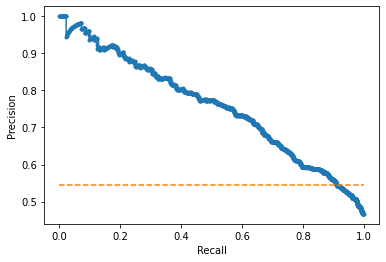

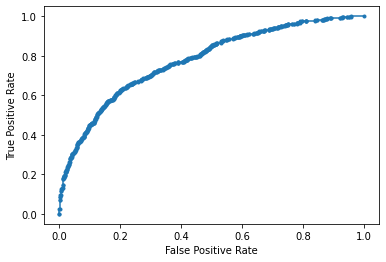

Accuracy: 71.89% Precision: 72.80% Recall: 61.32%
F1: 66.57% AUPRC: 75.71% AUROC: 77.79%
2023-02-14 17:31:16.152301
Fold 7
Discriminator is GMM
Means [0.42265802761094395, -0.9321467949891451]
Variances [1.4111094  1.38269476]
Priors [0.47874181 0.52125819]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 0 1 1 1 1 1]
FIT
2023-02-14 17:31:33.125686
PREDICT
2023-02-14 17:31:49.128713


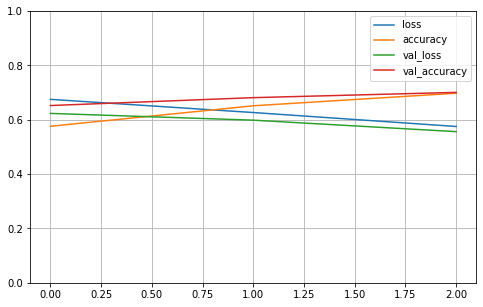

Train set ones/size 6822 / 14883
Compute valiation accuracy
Valid sizes (1653, 4997) (1653,)
Valid set ones/size 759 / 1653
Range of scores: 0.0012344986 to 0.9753073
Score threshold 0.5
Prediction set ones/size 566 / 1653


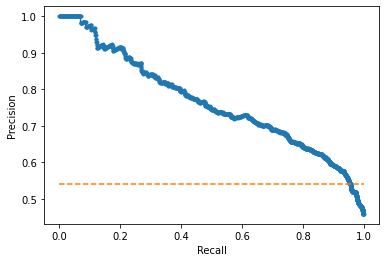

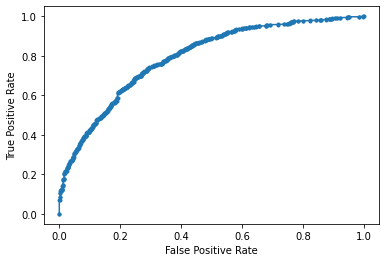

Accuracy: 70.05% Precision: 73.32% Recall: 54.68%
F1: 62.64% AUPRC: 76.56% AUROC: 79.29%
2023-02-14 17:31:49.970122
Fold 8
Discriminator is GMM
Means [-0.9596250798090062, 0.4050076157402767]
Variances [1.38854096 1.40489839]
Priors [0.50177407 0.49822593]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 0 1 1 1 1 1]
FIT
2023-02-14 17:32:08.315390
PREDICT
2023-02-14 17:32:30.749707


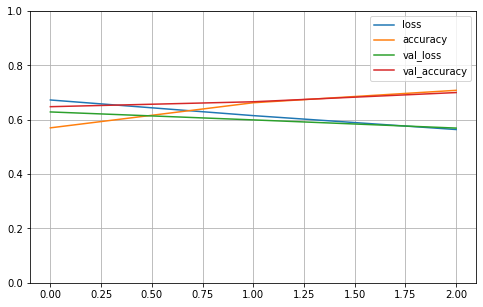

Train set ones/size 7332 / 14883
Compute valiation accuracy
Valid sizes (1653, 4997) (1653,)
Valid set ones/size 798 / 1653
Range of scores: 0.009675433 to 0.99303025
Score threshold 0.5
Prediction set ones/size 850 / 1653


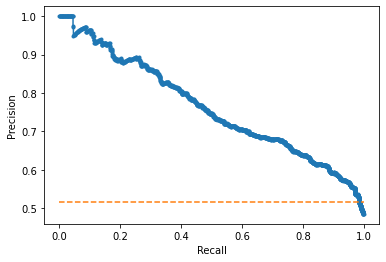

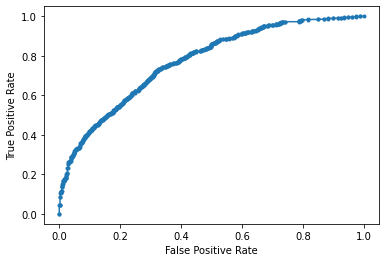

Accuracy: 69.99% Precision: 67.76% Recall: 72.18%
F1: 69.90% AUPRC: 76.34% AUROC: 77.24%
2023-02-14 17:32:31.662477
Fold 9
Discriminator is GMM
Means [-0.939622020333644, 0.4310915460358014]
Variances [1.37738967 1.39938075]
Priors [0.51897002 0.48102998]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 0 1 1 1 1 1]
FIT
2023-02-14 17:32:44.837091
PREDICT
2023-02-14 17:33:07.042680


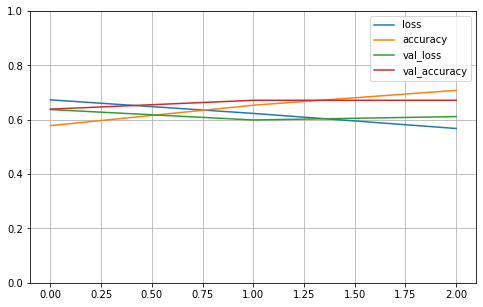

Train set ones/size 6869 / 14883
Compute valiation accuracy
Valid sizes (1653, 4997) (1653,)
Valid set ones/size 736 / 1653
Range of scores: 0.010467377 to 0.9949817
Score threshold 0.5
Prediction set ones/size 1077 / 1653


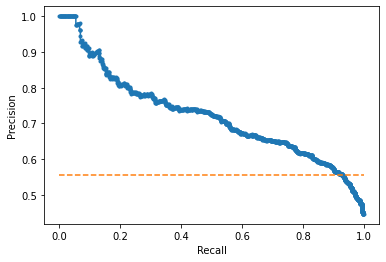

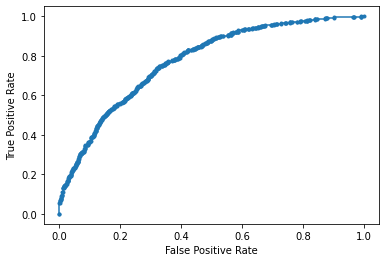

Accuracy: 67.15% Precision: 58.96% Recall: 86.28%
F1: 70.05% AUPRC: 72.30% AUROC: 77.40%
2023-02-14 17:33:07.897640
Fold 10
Discriminator is GMM
Means [0.4262311365601137, -0.941232568708136]
Variances [1.40308477 1.37632519]
Priors [0.48038602 0.51961398]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 0 1 1 1 1 1]
FIT
2023-02-14 17:33:24.443799
PREDICT
2023-02-14 17:33:46.627033


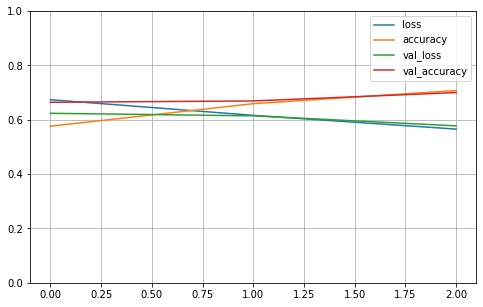

Train set ones/size 6848 / 14883
Compute valiation accuracy
Valid sizes (1653, 4997) (1653,)
Valid set ones/size 757 / 1653
Range of scores: 0.021366915 to 0.9818517
Score threshold 0.5
Prediction set ones/size 635 / 1653


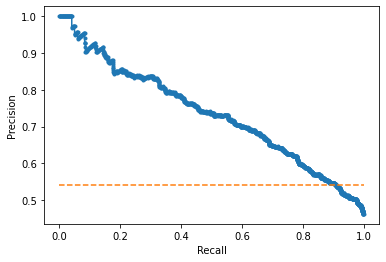

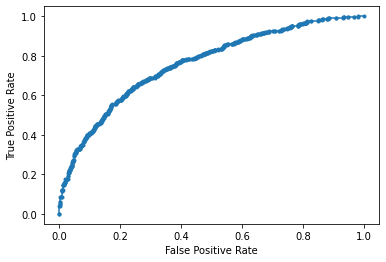

Accuracy: 69.99% Precision: 70.55% Recall: 59.18%
F1: 64.37% AUPRC: 73.60% AUROC: 76.03%
2023-02-14 17:33:47.503163

Completed cross validation 10 folds 3 epochs
 accuracy mean 69.28% +/- 2.17
 precision mean 69.62% +/- 6.68
 recall mean 64.06% +/- 14.98
 F1 mean 65.16% +/- 4.82
 AUPRC mean 74.93% +/- 1.69
 AUROC mean 77.57% +/- 1.45
Finished cell Line 1 H1.hESC

2023-02-14 17:33:49.106161
Start cell Line 2 HeLa.S3
Number of RCI values loaded 919
Num RCI: 919
Load sequence...
Cross validation...
2023-02-14 17:33:58.865492
splitting
Fold 1
Discriminator is GMM
Means [-2.2156410468385945, 0.21326869776477475]
Variances [1.52326069 1.28402137]
Priors [0.61624712 0.38375288]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:34:05.365902
PREDICT
2023-02-14 17:34:16.770114


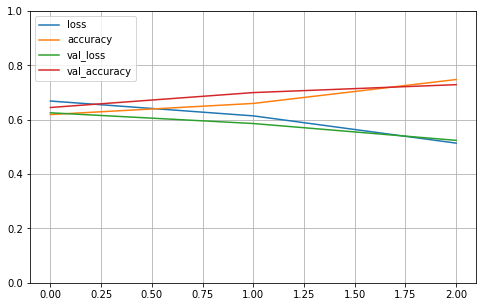

Train set ones/size 1904 / 5240
Compute valiation accuracy
Valid sizes (583, 4997) (583,)
Valid set ones/size 207 / 583
Range of scores: 0.00078338844 to 0.8848108
Score threshold 0.5
Prediction set ones/size 59 / 583


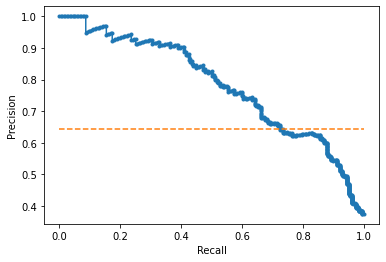

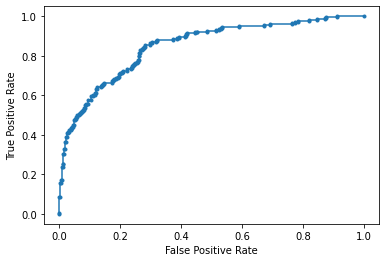

Accuracy: 72.90% Precision: 91.53% Recall: 26.09%
F1: 40.60% AUPRC: 78.23% AUROC: 85.04%
2023-02-14 17:34:17.410960
Fold 2
Discriminator is GMM
Means [-2.2029887959866947, 0.24244013603382364]
Variances [1.53044047 1.26302496]
Priors [0.62274329 0.37725671]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:34:27.068508
PREDICT
2023-02-14 17:34:33.525004


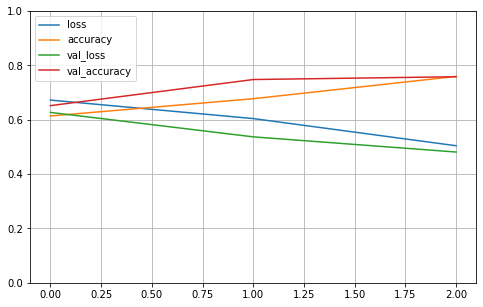

Train set ones/size 1883 / 5240
Compute valiation accuracy
Valid sizes (583, 4997) (583,)
Valid set ones/size 203 / 583
Range of scores: 0.0030244829 to 0.96784455
Score threshold 0.5
Prediction set ones/size 186 / 583


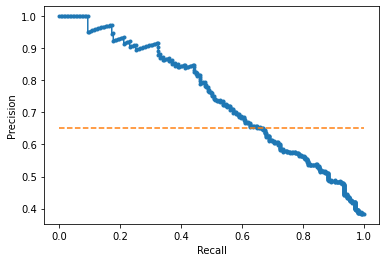

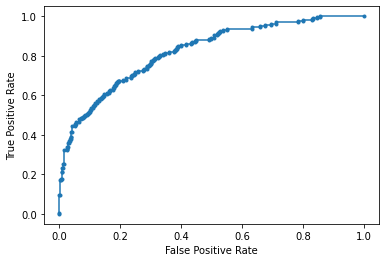

Accuracy: 75.81% Precision: 66.67% Recall: 61.08%
F1: 63.75% AUPRC: 74.66% AUROC: 82.28%
2023-02-14 17:34:34.323374
Fold 3
Discriminator is GMM
Means [-2.2001022967664166, 0.24395063245597293]
Variances [1.55764596 1.28556721]
Priors [0.62256023 0.37743977]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:34:42.930464
PREDICT
2023-02-14 17:34:49.806002


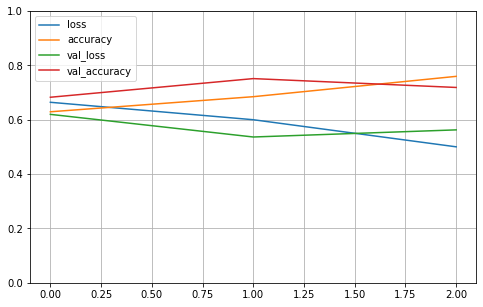

Train set ones/size 1883 / 5240
Compute valiation accuracy
Valid sizes (583, 4997) (583,)
Valid set ones/size 201 / 583
Range of scores: 0.00029866834 to 0.90203977
Score threshold 0.5
Prediction set ones/size 61 / 583


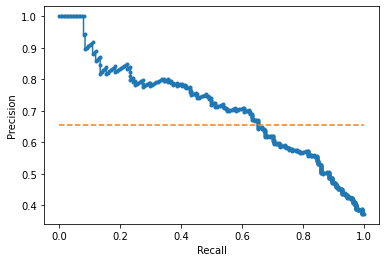

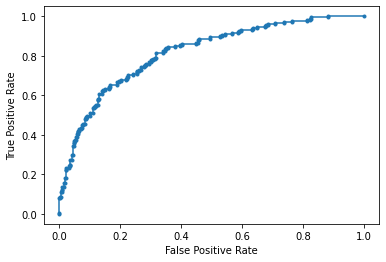

Accuracy: 71.87% Precision: 80.33% Recall: 24.38%
F1: 37.40% AUPRC: 70.91% AUROC: 81.60%
2023-02-14 17:34:50.497782
Fold 4
Discriminator is GMM
Means [0.23328940125594716, -2.2144140877596064]
Variances [1.26460434 1.53699144]
Priors [0.38339219 0.61660781]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:34:59.531135
PREDICT
2023-02-14 17:35:11.201000


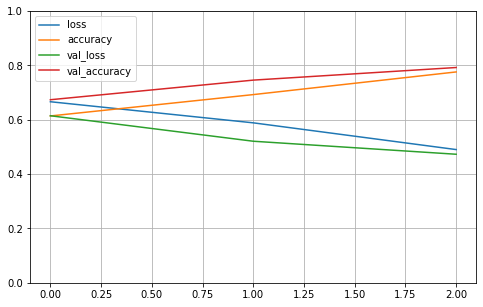

Train set ones/size 1919 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 191 / 582
Range of scores: 0.0070219585 to 0.9622084
Score threshold 0.5
Prediction set ones/size 138 / 582


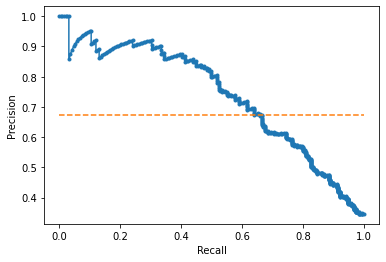

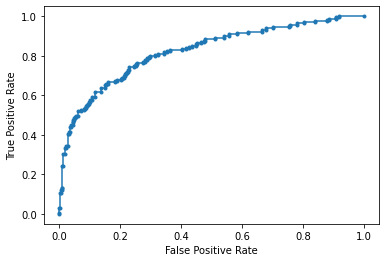

Accuracy: 79.21% Precision: 75.36% Recall: 54.45%
F1: 63.22% AUPRC: 73.68% AUROC: 82.36%
2023-02-14 17:35:11.820995
Fold 5
Discriminator is GMM
Means [-2.2180173044843405, 0.23619174248908753]
Variances [1.53414046 1.2713961 ]
Priors [0.62103766 0.37896234]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:35:22.100906
PREDICT
2023-02-14 17:35:28.795942


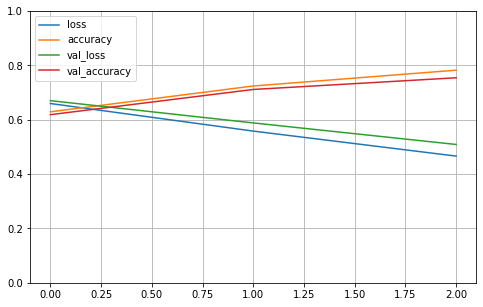

Train set ones/size 1887 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 222 / 582
Range of scores: 0.001387076 to 0.9837902
Score threshold 0.5
Prediction set ones/size 123 / 582


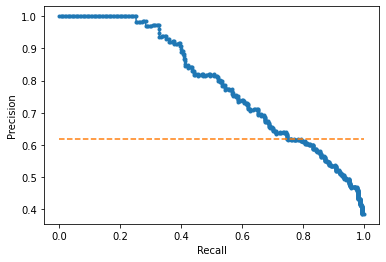

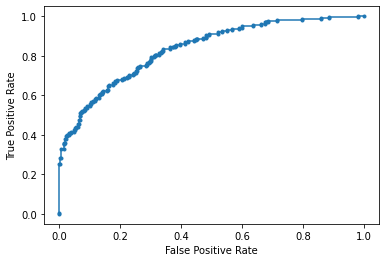

Accuracy: 75.43% Precision: 82.11% Recall: 45.50%
F1: 58.55% AUPRC: 79.21% AUROC: 83.42%
2023-02-14 17:35:29.707187
Fold 6
Discriminator is GMM
Means [-2.2047056028047445, 0.2221782870298584]
Variances [1.52502837 1.29324444]
Priors [0.62129743 0.37870257]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:35:38.736385
PREDICT
2023-02-14 17:35:50.124199


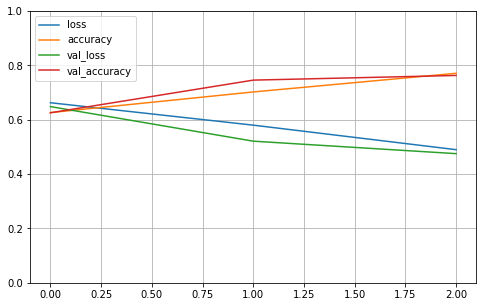

Train set ones/size 1890 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 218 / 582
Range of scores: 0.0032139993 to 0.9593911
Score threshold 0.5
Prediction set ones/size 152 / 582


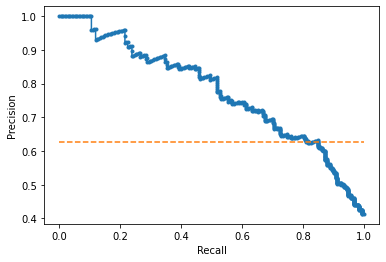

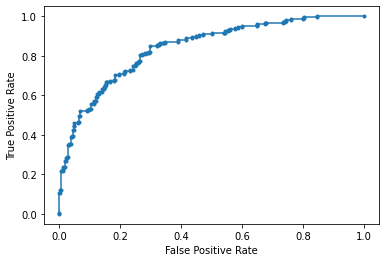

Accuracy: 76.29% Precision: 76.32% Recall: 53.21%
F1: 62.70% AUPRC: 77.60% AUROC: 84.15%
2023-02-14 17:35:50.805250
Fold 7
Discriminator is GMM
Means [0.21283414000272155, -2.2311370054699875]
Variances [1.270875   1.55600021]
Priors [0.38067587 0.61932413]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:36:01.383984
PREDICT
2023-02-14 17:36:12.742119


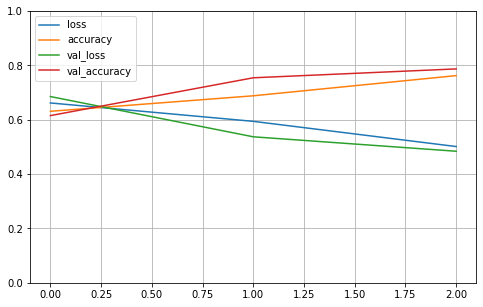

Train set ones/size 1888 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 223 / 582
Range of scores: 0.010014951 to 0.9799985
Score threshold 0.5
Prediction set ones/size 209 / 582


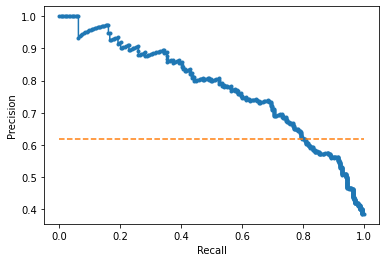

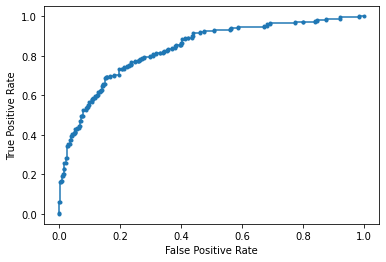

Accuracy: 78.69% Precision: 73.68% Recall: 69.06%
F1: 71.30% AUPRC: 77.70% AUROC: 83.65%
2023-02-14 17:36:13.391184
Fold 8
Discriminator is GMM
Means [0.2480492500856222, -2.2082384385173026]
Variances [1.25341829 1.5277877 ]
Priors [0.37839118 0.62160882]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:36:24.498472
PREDICT
2023-02-14 17:36:30.857478


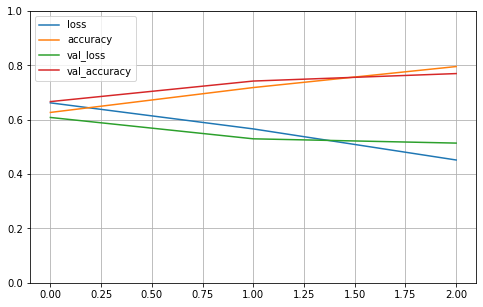

Train set ones/size 1905 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 196 / 582
Range of scores: 0.0015871028 to 0.9711582
Score threshold 0.5
Prediction set ones/size 126 / 582


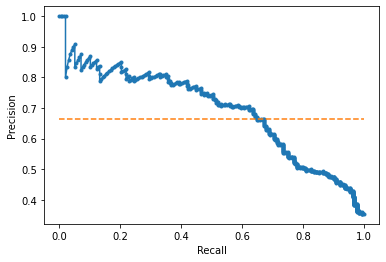

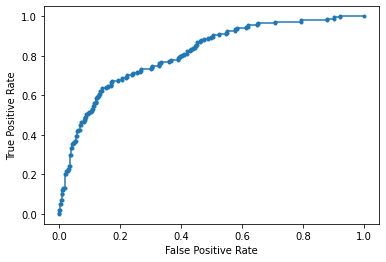

Accuracy: 76.98% Precision: 74.60% Recall: 47.96%
F1: 58.39% AUPRC: 69.21% AUROC: 81.12%
2023-02-14 17:36:31.507974
Fold 9
Discriminator is GMM
Means [-2.204896242492339, 0.2503668559053185]
Variances [1.53959939 1.29039132]
Priors [0.63017126 0.36982874]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:36:41.612475
PREDICT
2023-02-14 17:36:52.985873


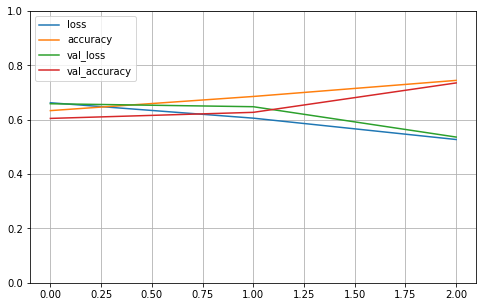

Train set ones/size 1833 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 230 / 582
Range of scores: 0.021518705 to 0.9649271
Score threshold 0.5
Prediction set ones/size 242 / 582


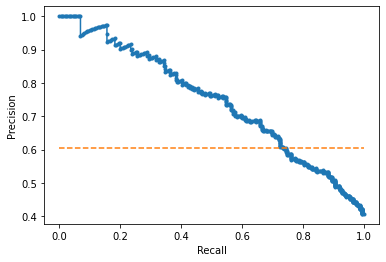

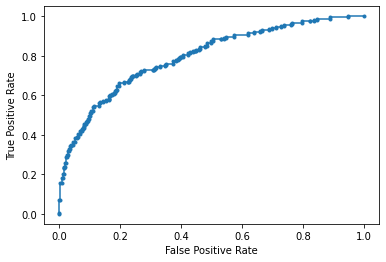

Accuracy: 73.54% Precision: 65.70% Recall: 69.13%
F1: 67.37% AUPRC: 74.57% AUROC: 79.58%
2023-02-14 17:36:53.669075
Fold 10
Discriminator is GMM
Means [0.18317642386021438, -2.2282503436953114]
Variances [1.32523818 1.55049175]
Priors [0.38878933 0.61121067]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:37:04.487473
PREDICT
2023-02-14 17:37:15.873594


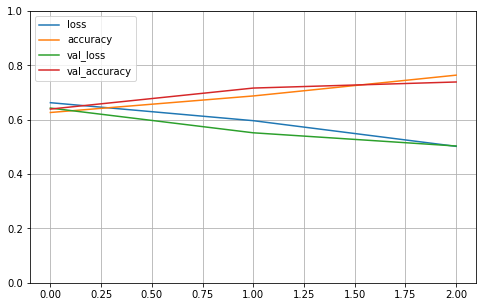

Train set ones/size 1923 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 209 / 582
Range of scores: 0.0073657413 to 0.9656281
Score threshold 0.5
Prediction set ones/size 157 / 582


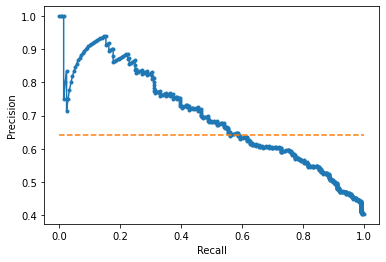

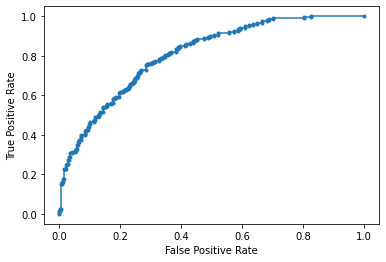

Accuracy: 73.88% Precision: 68.15% Recall: 51.20%
F1: 58.47% AUPRC: 69.67% AUROC: 80.73%
2023-02-14 17:37:16.487100

Completed cross validation 10 folds 3 epochs
 accuracy mean 75.46% +/- 2.43
 precision mean 75.45% +/- 7.86
 recall mean 50.20% +/- 15.41
 F1 mean 58.18% +/- 10.93
 AUPRC mean 74.54% +/- 3.67
 AUROC mean 82.39% +/- 1.69
Finished cell Line 2 HeLa.S3

2023-02-14 17:37:17.820918
Start cell Line 3 HepG2
Number of RCI values loaded 1362
Num RCI: 1362
Load sequence...
Cross validation...
2023-02-14 17:37:31.183742
splitting
Fold 1
Discriminator is GMM
Means [-1.9004639509904655, 0.20477242887901775]
Variances [2.24575716 1.56416781]
Priors [0.61215829 0.38784171]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:37:41.917378
PREDICT
2023-02-14 17:37:53.420317


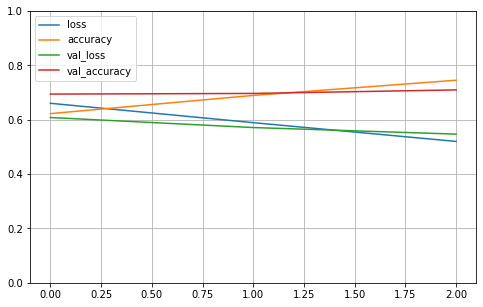

Train set ones/size 2805 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 310 / 844
Range of scores: 0.013110217 to 0.98117644
Score threshold 0.5
Prediction set ones/size 393 / 844


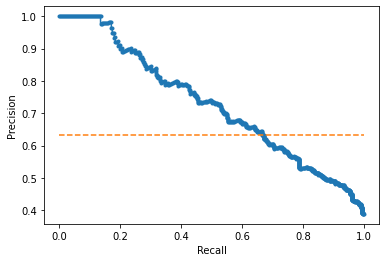

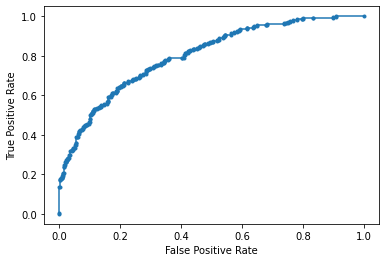

Accuracy: 70.97% Precision: 58.27% Recall: 73.87%
F1: 65.15% AUPRC: 72.89% AUROC: 80.15%
2023-02-14 17:37:54.326697
Fold 2
Discriminator is GMM
Means [0.19681600580568845, -1.8945103292813728]
Variances [1.56630979 2.22008805]
Priors [0.38939818 0.61060182]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:38:08.030745
PREDICT
2023-02-14 17:38:19.538181


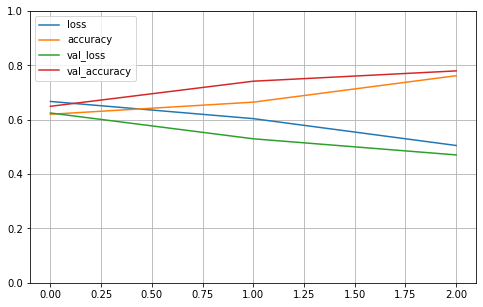

Train set ones/size 2811 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 307 / 844
Range of scores: 0.007329412 to 0.94961345
Score threshold 0.5
Prediction set ones/size 193 / 844


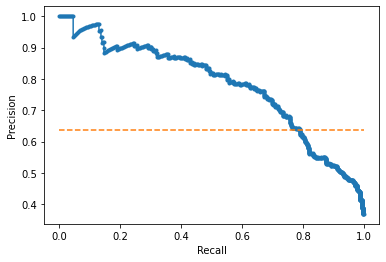

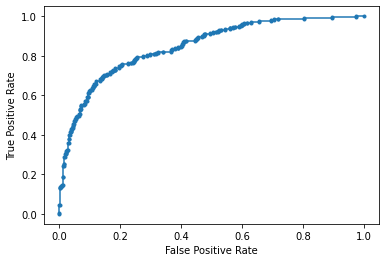

Accuracy: 77.96% Precision: 81.35% Recall: 51.14%
F1: 62.80% AUPRC: 77.97% AUROC: 84.92%
2023-02-14 17:38:20.234065
Fold 3
Discriminator is GMM
Means [-1.8878165944299043, 0.1834273124656132]
Variances [2.28294434 1.59499021]
Priors [0.60782875 0.39217125]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:38:32.396191
PREDICT
2023-02-14 17:38:40.848915


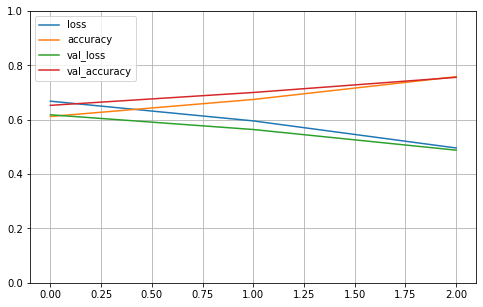

Train set ones/size 2830 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 299 / 844
Range of scores: 0.005985043 to 0.98487467
Score threshold 0.5
Prediction set ones/size 261 / 844


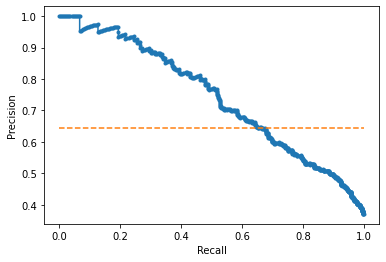

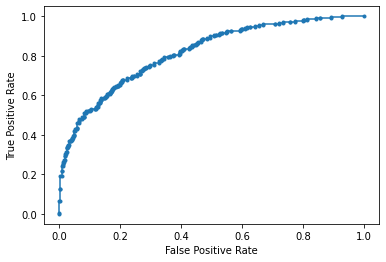

Accuracy: 75.59% Precision: 67.82% Recall: 59.20%
F1: 63.21% AUPRC: 74.27% AUROC: 81.61%
2023-02-14 17:38:41.548807
Fold 4
Discriminator is GMM
Means [-1.9002294978238916, 0.19841389640673623]
Variances [2.21197723 1.54821036]
Priors [0.60909086 0.39090914]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:38:51.850991
PREDICT
2023-02-14 17:39:00.799653


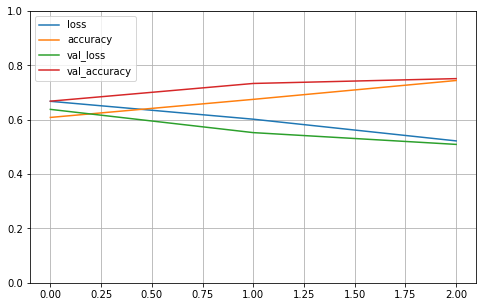

Train set ones/size 2838 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 296 / 844
Range of scores: 0.018692771 to 0.9857421
Score threshold 0.5
Prediction set ones/size 244 / 844


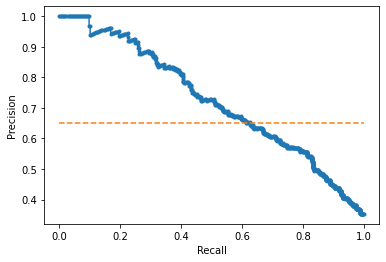

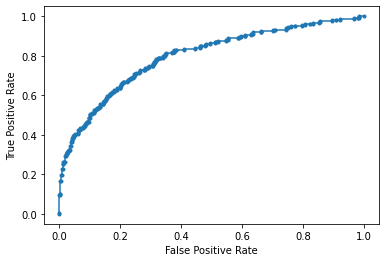

Accuracy: 75.12% Precision: 67.62% Recall: 55.74%
F1: 61.11% AUPRC: 72.50% AUROC: 79.78%
2023-02-14 17:39:01.461741
Fold 5
Discriminator is GMM
Means [0.23041841756306203, -1.9236522897907744]
Variances [1.54103244 2.13283526]
Priors [0.39079467 0.60920533]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:39:12.602938
PREDICT
2023-02-14 17:39:21.554094


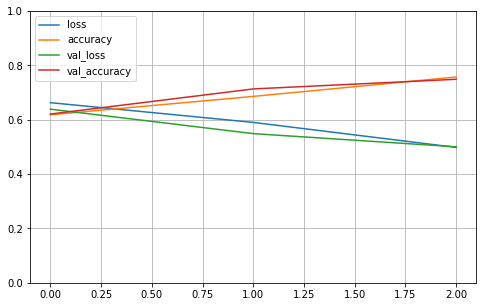

Train set ones/size 2806 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 328 / 844
Range of scores: 0.0015570668 to 0.9898921
Score threshold 0.5
Prediction set ones/size 226 / 844


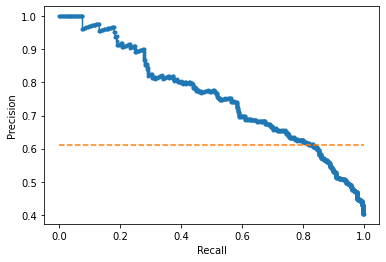

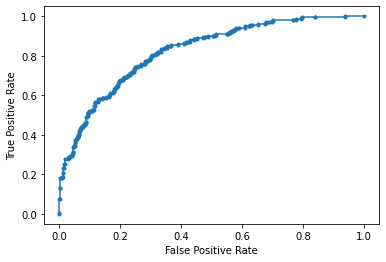

Accuracy: 74.88% Precision: 75.66% Recall: 52.13%
F1: 61.73% AUPRC: 75.85% AUROC: 82.37%
2023-02-14 17:39:22.239526
Fold 6
Discriminator is GMM
Means [-1.892819252379871, 0.21047932400833524]
Variances [2.20008263 1.57417104]
Priors [0.61398489 0.38601511]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 0 1 1 1 1 1]
FIT
2023-02-14 17:39:32.587279
PREDICT
2023-02-14 17:39:41.626136


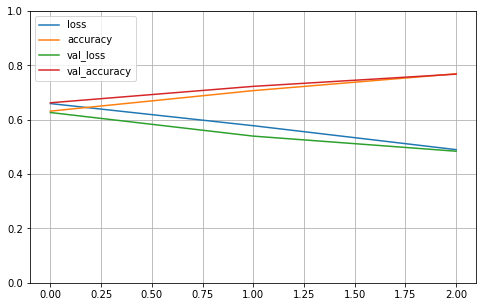

Train set ones/size 2752 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 319 / 844
Range of scores: 0.017227383 to 0.9703504
Score threshold 0.5
Prediction set ones/size 271 / 844


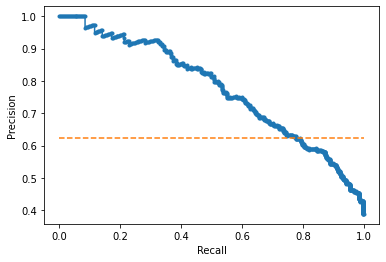

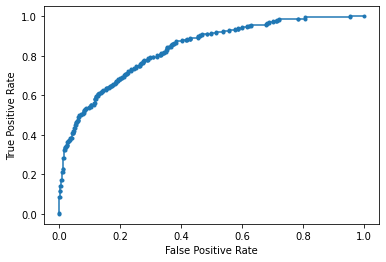

Accuracy: 76.78% Precision: 72.69% Recall: 61.76%
F1: 66.78% AUPRC: 77.64% AUROC: 83.59%
2023-02-14 17:39:42.299490
Fold 7
Discriminator is GMM
Means [0.1838758058554111, -1.8982633748227027]
Variances [1.57501549 2.28449468]
Priors [0.39169994 0.60830006]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:39:54.286107
PREDICT
2023-02-14 17:40:05.829290


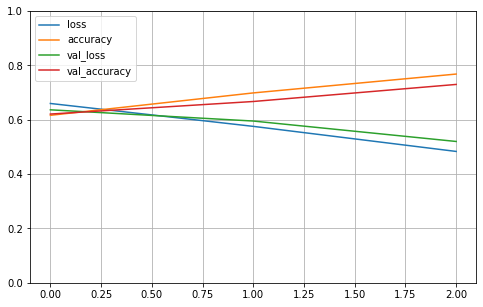

Train set ones/size 2841 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 307 / 844
Range of scores: 0.0063457517 to 0.9873297
Score threshold 0.5
Prediction set ones/size 341 / 844


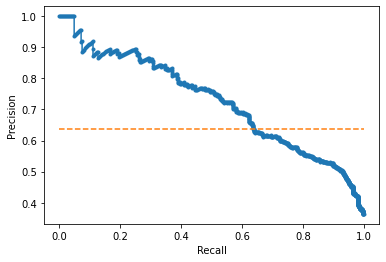

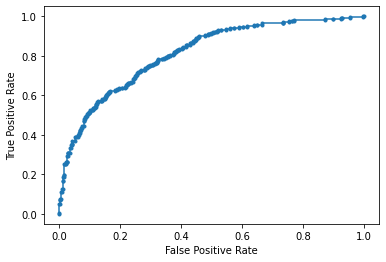

Accuracy: 72.99% Precision: 61.58% Recall: 68.40%
F1: 64.81% AUPRC: 72.67% AUROC: 81.36%
2023-02-14 17:40:06.692759
Fold 8
Discriminator is GMM
Means [0.15928624906809052, -1.8945465026971682]
Variances [1.58063269 2.27430301]
Priors [0.39256731 0.60743269]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:40:19.506654
PREDICT
2023-02-14 17:40:31.005516


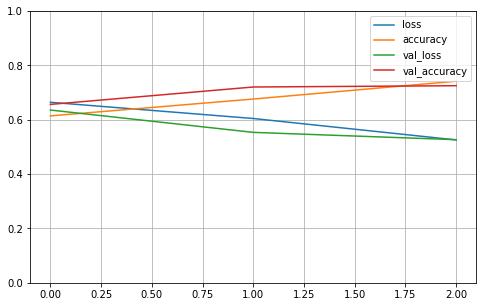

Train set ones/size 2816 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 333 / 844
Range of scores: 0.0051170075 to 0.96078575
Score threshold 0.5
Prediction set ones/size 143 / 844


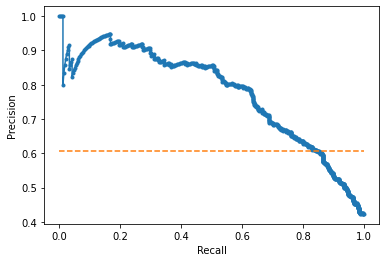

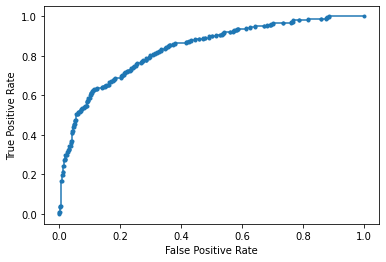

Accuracy: 72.51% Precision: 85.31% Recall: 36.64%
F1: 51.26% AUPRC: 77.56% AUROC: 83.48%
2023-02-14 17:40:31.732692
Fold 9
Discriminator is GMM
Means [-1.8909616579685427, 0.1868278919114318]
Variances [2.26548925 1.58995876]
Priors [0.61078014 0.38921986]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:40:44.329606
PREDICT
2023-02-14 17:40:55.843695


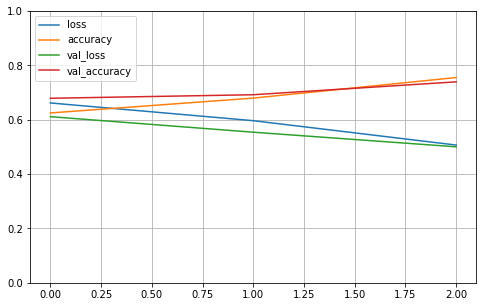

Train set ones/size 2801 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 314 / 844
Range of scores: 0.01113298 to 0.986698
Score threshold 0.5
Prediction set ones/size 220 / 844


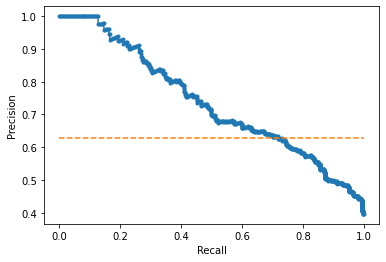

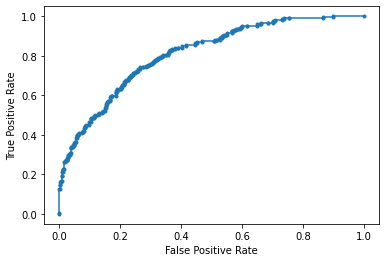

Accuracy: 73.93% Precision: 71.36% Recall: 50.00%
F1: 58.80% AUPRC: 73.72% AUROC: 81.17%
2023-02-14 17:40:56.534580
Fold 10
Discriminator is GMM
Means [-1.8926451001804347, 0.184522813851107]
Variances [2.24296745 1.60161847]
Priors [0.61016267 0.38983733]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:41:08.509447
PREDICT
2023-02-14 17:41:20.026690


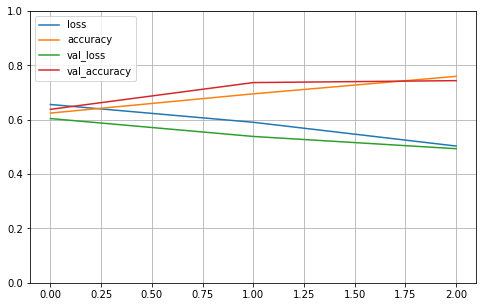

Train set ones/size 2804 / 7596
Compute valiation accuracy
Valid sizes (843, 4997) (843,)
Valid set ones/size 311 / 843
Range of scores: 0.003660109 to 0.9714697
Score threshold 0.5
Prediction set ones/size 161 / 843


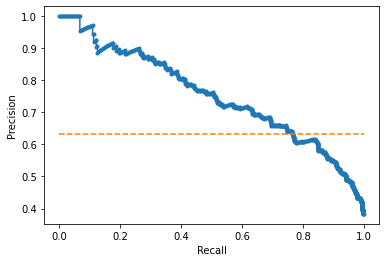

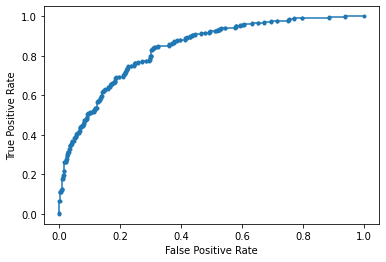

Accuracy: 74.38% Precision: 79.50% Recall: 41.16%
F1: 54.24% AUPRC: 75.32% AUROC: 83.58%
2023-02-14 17:41:20.908132

Completed cross validation 10 folds 3 epochs
 accuracy mean 74.51% +/- 2.05
 precision mean 72.12% +/- 8.62
 recall mean 55.00% +/- 11.43
 F1 mean 60.99% +/- 4.94
 AUPRC mean 75.04% +/- 2.15
 AUROC mean 82.20% +/- 1.67
Finished cell Line 3 HepG2

2023-02-14 17:41:22.325156
Start cell Line 4 HT1080
Number of RCI values loaded 936
Num RCI: 936
Load sequence...
Cross validation...
2023-02-14 17:41:33.577933
splitting
Fold 1
Discriminator is GMM
Means [0.924706679896555, -1.0105715717505794]
Variances [0.88818885 1.98139541]
Priors [0.37557475 0.62442525]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 0 0 1 1 1 1]
FIT
2023-02-14 17:41:42.435480
PREDICT
2023-02-14 17:41:50.400668


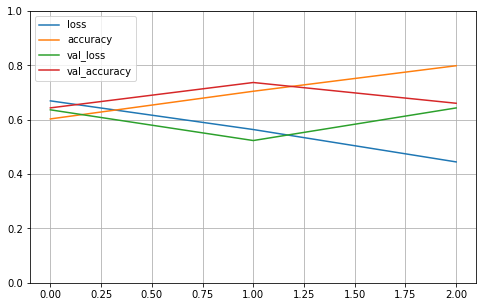

Train set ones/size 2524 / 6357
Compute valiation accuracy
Valid sizes (707, 4997) (707,)
Valid set ones/size 282 / 707
Range of scores: 0.0099302335 to 0.99932194
Score threshold 0.5
Prediction set ones/size 470 / 707


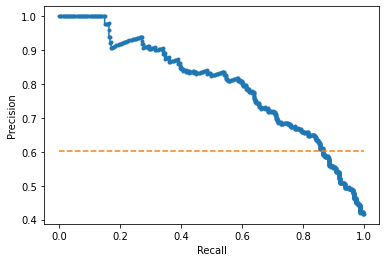

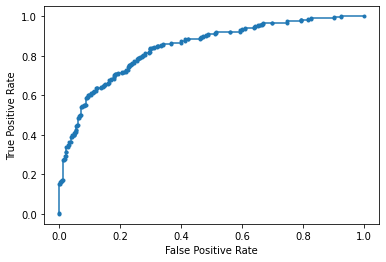

Accuracy: 66.05% Precision: 54.47% Recall: 90.78%
F1: 68.09% AUPRC: 79.75% AUROC: 84.15%
2023-02-14 17:41:51.119947
Fold 2
Discriminator is GMM
Means [-1.0082110854074993, 0.9416507785962105]
Variances [1.97720333 0.88871252]
Priors [0.62412912 0.37587088]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 0 0 1 1 1 1]
FIT
2023-02-14 17:42:03.710790
PREDICT
2023-02-14 17:42:11.176729


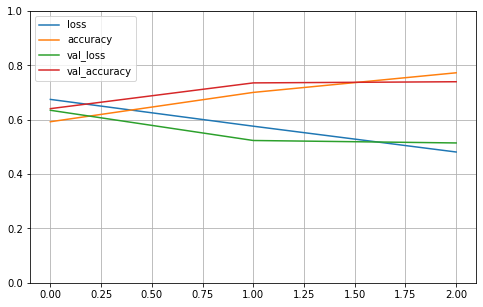

Train set ones/size 2527 / 6357
Compute valiation accuracy
Valid sizes (707, 4997) (707,)
Valid set ones/size 279 / 707
Range of scores: 0.010194715 to 0.99320024
Score threshold 0.5
Prediction set ones/size 361 / 707


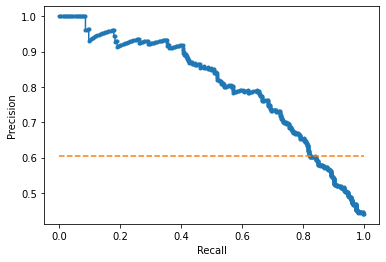

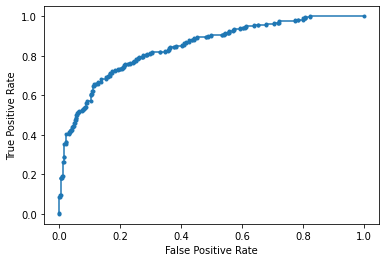

Accuracy: 73.97% Precision: 63.16% Recall: 81.72%
F1: 71.25% AUPRC: 80.15% AUROC: 84.49%
2023-02-14 17:42:12.090188
Fold 3
Discriminator is GMM
Means [-1.0376162967271312, 0.9824308218659442]
Variances [1.89621649 0.84870621]
Priors [0.6244428 0.3755572]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 0 0 1 1 1 1]
FIT
2023-02-14 17:42:22.000055
PREDICT
2023-02-14 17:42:33.427118


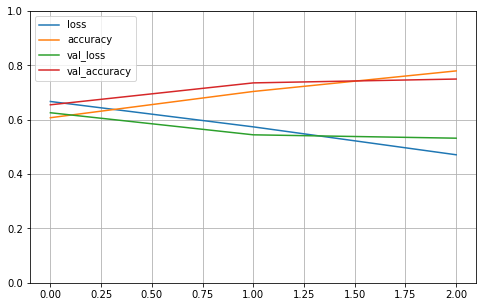

Train set ones/size 2536 / 6357
Compute valiation accuracy
Valid sizes (707, 4997) (707,)
Valid set ones/size 270 / 707
Range of scores: 0.0027990725 to 0.9976871
Score threshold 0.5
Prediction set ones/size 371 / 707


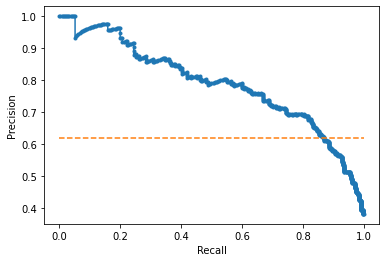

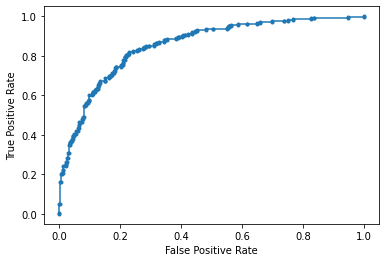

Accuracy: 74.96% Precision: 62.53% Recall: 85.93%
F1: 72.39% AUPRC: 78.91% AUROC: 85.52%
2023-02-14 17:42:34.108194
Fold 4
Discriminator is GMM
Means [-1.026325166082925, 0.9550990381572801]
Variances [1.92585631 0.87260194]
Priors [0.6278025 0.3721975]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 0 0 1 1 1 1]
FIT
2023-02-14 17:42:45.948757
PREDICT
2023-02-14 17:42:53.835447


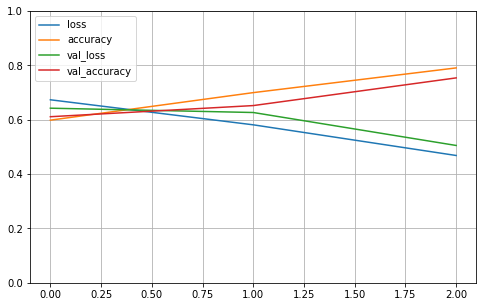

Train set ones/size 2499 / 6357
Compute valiation accuracy
Valid sizes (707, 4997) (707,)
Valid set ones/size 307 / 707
Range of scores: 0.002283167 to 0.99060327
Score threshold 0.5
Prediction set ones/size 261 / 707


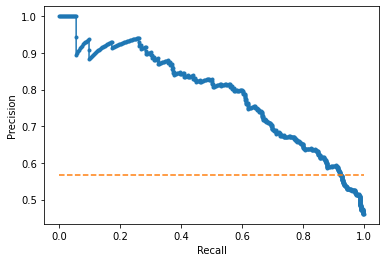

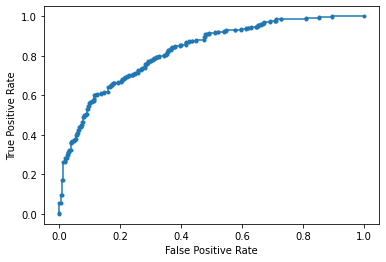

Accuracy: 75.39% Precision: 75.48% Recall: 64.17%
F1: 69.37% AUPRC: 78.77% AUROC: 82.58%
2023-02-14 17:42:54.460855
Fold 5
Discriminator is GMM
Means [-1.0191506863804884, 0.9572870577635445]
Variances [1.93853796 0.85289443]
Priors [0.6276846 0.3723154]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 0 0 1 1 1 1]
FIT
2023-02-14 17:43:04.258768
PREDICT
2023-02-14 17:43:12.465620


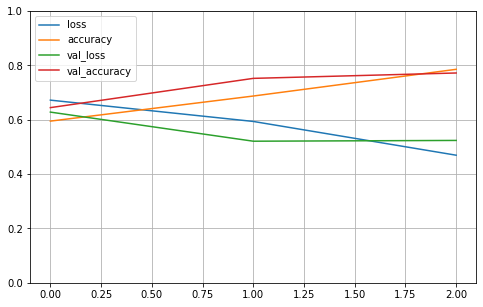

Train set ones/size 2521 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 284 / 706
Range of scores: 0.0026808581 to 0.95754236
Score threshold 0.5
Prediction set ones/size 141 / 706


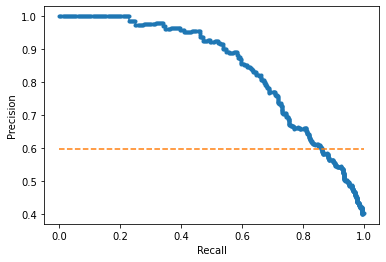

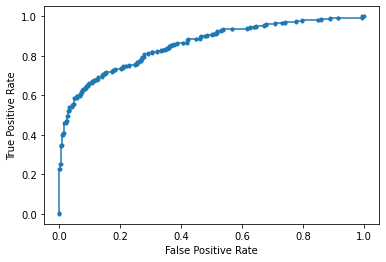

Accuracy: 77.20% Precision: 93.62% Recall: 46.48%
F1: 62.12% AUPRC: 84.20% AUROC: 85.64%
2023-02-14 17:43:13.106874
Fold 6
Discriminator is GMM
Means [-1.0249213425506438, 0.9690353107180306]
Variances [1.95934933 0.86925618]
Priors [0.62722892 0.37277108]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 0 0 1 1 1 1]
FIT
2023-02-14 17:43:24.457562
PREDICT
2023-02-14 17:43:35.887101


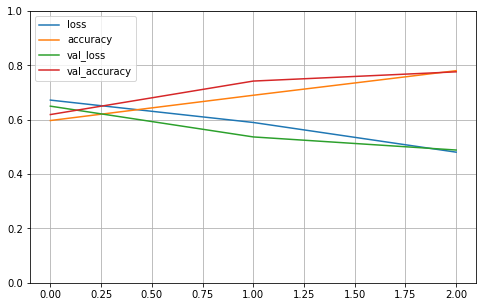

Train set ones/size 2511 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 275 / 706
Range of scores: 0.0024054137 to 0.9824446
Score threshold 0.5
Prediction set ones/size 221 / 706


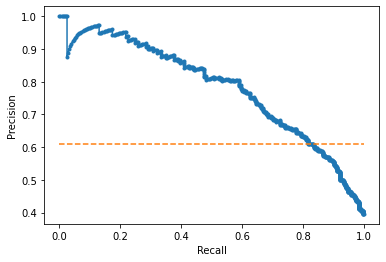

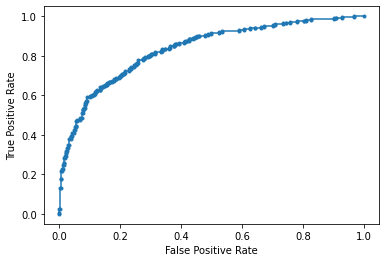

Accuracy: 77.62% Precision: 76.47% Recall: 61.45%
F1: 68.15% AUPRC: 78.18% AUROC: 83.45%
2023-02-14 17:43:36.560625
Fold 7
Discriminator is GMM
Means [-1.022952623587284, 0.9535434325157491]
Variances [1.93362301 0.86054544]
Priors [0.62847157 0.37152843]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 0 0 1 1 1 1]
FIT
2023-02-14 17:43:47.821272
PREDICT
2023-02-14 17:43:59.259041


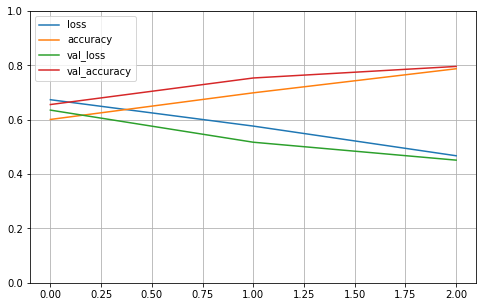

Train set ones/size 2514 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 291 / 706
Range of scores: 0.0045354576 to 0.9831638
Score threshold 0.5
Prediction set ones/size 241 / 706


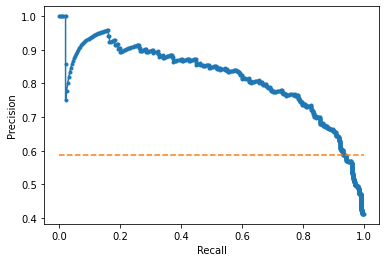

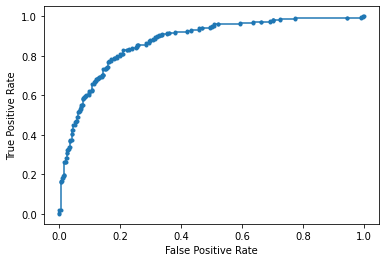

Accuracy: 79.60% Precision: 80.50% Recall: 66.67%
F1: 72.93% AUPRC: 81.55% AUROC: 87.21%
2023-02-14 17:43:59.928422
Fold 8
Discriminator is GMM
Means [0.9617533942843244, -1.0280483319252547]
Variances [0.83925367 1.9658337 ]
Priors [0.37590823 0.62409177]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 0 0 1 1 1 1]
FIT
2023-02-14 17:44:10.746549
PREDICT
2023-02-14 17:44:18.351612


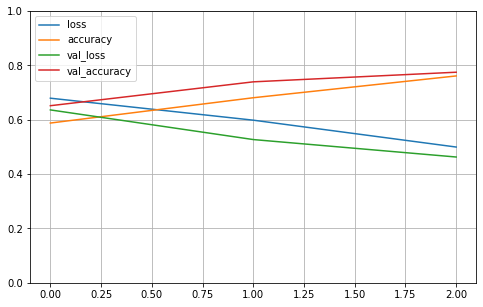

Train set ones/size 2538 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 268 / 706
Range of scores: 0.005955511 to 0.98581266
Score threshold 0.5
Prediction set ones/size 215 / 706


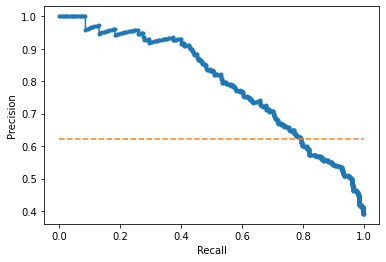

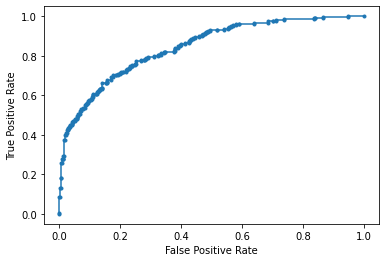

Accuracy: 77.48% Precision: 75.35% Recall: 60.45%
F1: 67.08% AUPRC: 79.49% AUROC: 84.46%
2023-02-14 17:44:18.993542
Fold 9
Discriminator is GMM
Means [-1.0328293233209513, 0.9445750142380256]
Variances [1.98723895 0.8678581 ]
Priors [0.62275255 0.37724745]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 0 0 1 1 1 1]
FIT
2023-02-14 17:44:29.797655
PREDICT
2023-02-14 17:44:37.562711


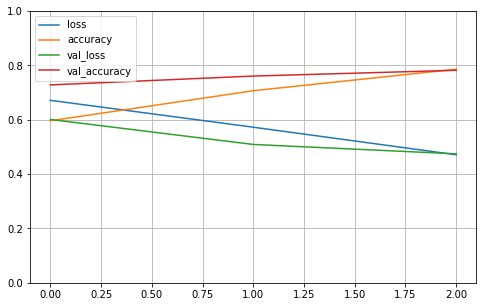

Train set ones/size 2538 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 274 / 706
Range of scores: 0.0019834058 to 0.9641364
Score threshold 0.5
Prediction set ones/size 152 / 706


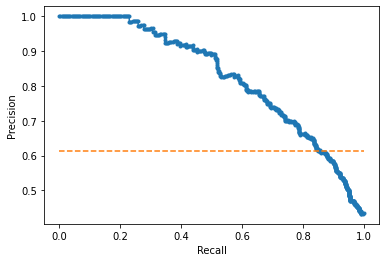

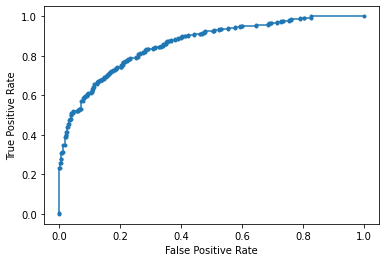

Accuracy: 78.19% Precision: 89.47% Recall: 49.64%
F1: 63.85% AUPRC: 82.66% AUROC: 86.15%
2023-02-14 17:44:38.631721
Fold 10
Discriminator is GMM
Means [-1.0304264798780884, 0.9645730621819114]
Variances [1.94560191 0.85432349]
Priors [0.62671445 0.37328555]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 0 0 1 1 1 1]
FIT
2023-02-14 17:44:48.328147
PREDICT
2023-02-14 17:44:56.535714


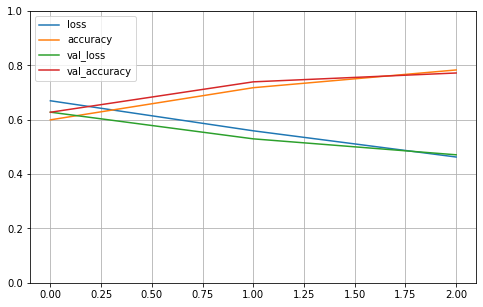

Train set ones/size 2533 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 273 / 706
Range of scores: 0.0021962696 to 0.9885582
Score threshold 0.5
Prediction set ones/size 206 / 706


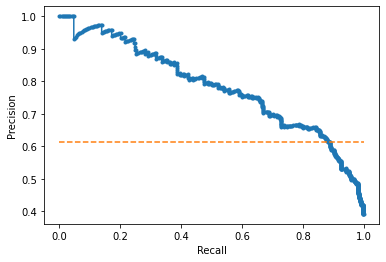

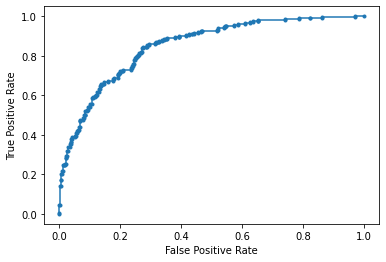

Accuracy: 77.20% Precision: 77.18% Recall: 58.24%
F1: 66.39% AUPRC: 78.42% AUROC: 84.99%
2023-02-14 17:44:57.194302

Completed cross validation 10 folds 3 epochs
 accuracy mean 75.77% +/- 3.79
 precision mean 74.82% +/- 12.07
 recall mean 66.55% +/- 14.98
 F1 mean 68.16% +/- 3.51
 AUPRC mean 80.21% +/- 1.99
 AUROC mean 84.86% +/- 1.34
Finished cell Line 4 HT1080

2023-02-14 17:44:58.563965
Start cell Line 5 HUVEC
Number of RCI values loaded 1488
Num RCI: 1488
Load sequence...
Cross validation...
2023-02-14 17:45:13.622555
splitting
Fold 1
Discriminator is GMM
Means [-0.002586080680115508, -2.0148885579020908]
Variances [1.7495863  2.12845584]
Priors [0.52428465 0.47571535]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 17:45:24.242293
PREDICT
2023-02-14 17:45:34.630250


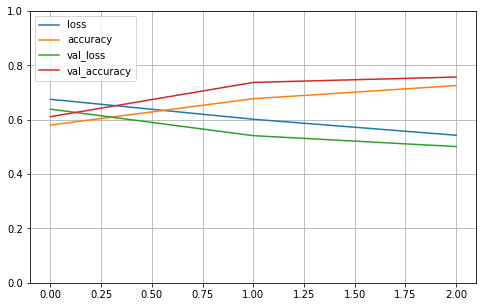

Train set ones/size 4704 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 547 / 959
Range of scores: 0.008047716 to 0.9907073
Score threshold 0.5
Prediction set ones/size 548 / 959


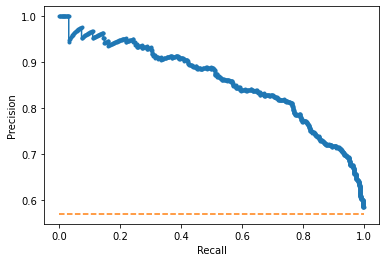

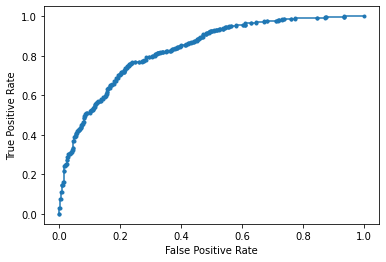

Accuracy: 75.70% Precision: 78.65% Recall: 78.79%
F1: 78.72% AUPRC: 85.90% AUROC: 83.11%
2023-02-14 17:45:35.321108
Fold 2
Discriminator is GMM
Means [-2.018050512829426, -0.008082155985591005]
Variances [2.12858246 1.76120407]
Priors [0.47540116 0.52459884]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 17:45:47.520121
PREDICT
2023-02-14 17:45:57.051957


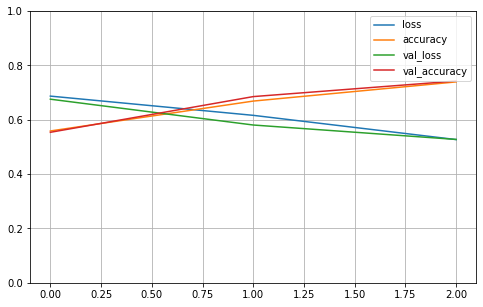

Train set ones/size 4708 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 544 / 959
Range of scores: 0.00781526 to 0.97845596
Score threshold 0.5
Prediction set ones/size 597 / 959


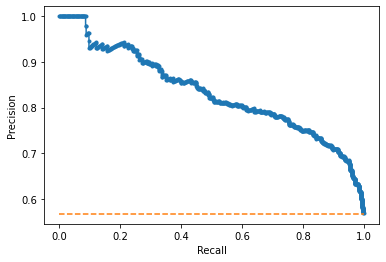

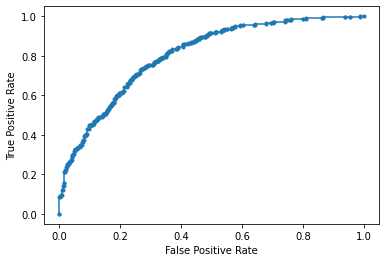

Accuracy: 74.24% Precision: 74.87% Recall: 82.17%
F1: 78.35% AUPRC: 83.37% AUROC: 80.49%
2023-02-14 17:45:58.141117
Fold 3
Discriminator is GMM
Means [-2.0068117420869394, -0.021670903927745025]
Variances [2.12050072 1.75575581]
Priors [0.47236093 0.52763907]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 17:46:08.125449
PREDICT
2023-02-14 17:46:19.841245


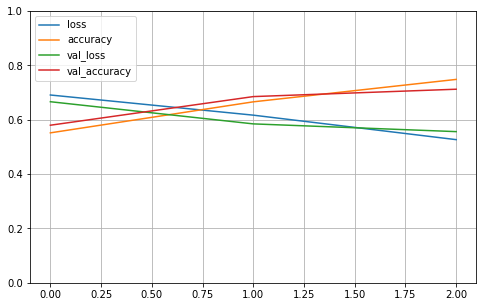

Train set ones/size 4733 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 530 / 959
Range of scores: 0.0055480306 to 0.98278666
Score threshold 0.5
Prediction set ones/size 628 / 959


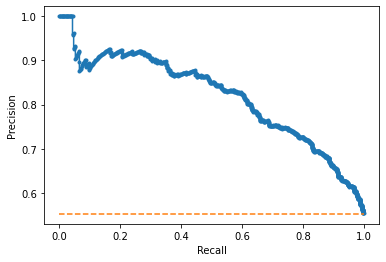

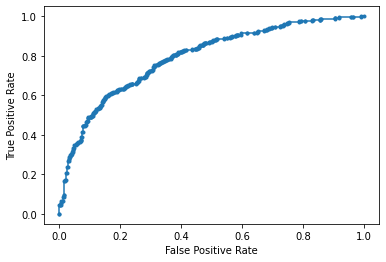

Accuracy: 71.22% Precision: 70.22% Recall: 83.21%
F1: 76.17% AUPRC: 81.94% AUROC: 79.21%
2023-02-14 17:46:20.553174
Fold 4
Discriminator is GMM
Means [-0.016295266201729802, -2.012370935557171]
Variances [1.72794652 2.14594735]
Priors [0.53265491 0.46734509]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 17:46:34.636647
PREDICT
2023-02-14 17:46:46.250221


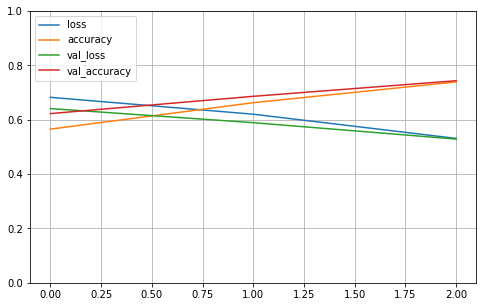

Train set ones/size 4796 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 494 / 959
Range of scores: 0.0071303863 to 0.97669834
Score threshold 0.5
Prediction set ones/size 458 / 959


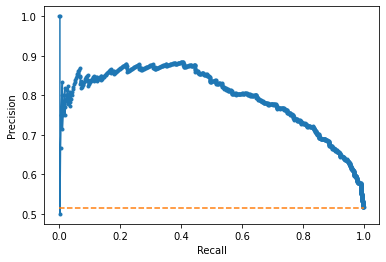

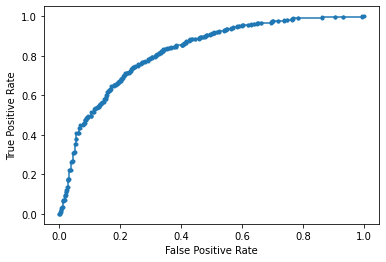

Accuracy: 74.35% Precision: 77.07% Recall: 71.46%
F1: 74.16% AUPRC: 79.62% AUROC: 82.04%
2023-02-14 17:46:47.099086
Fold 5
Discriminator is GMM
Means [-0.007396393369274652, -2.0202707947742384]
Variances [1.75359505 2.10049886]
Priors [0.52287652 0.47712348]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 17:46:59.040957
PREDICT
2023-02-14 17:47:09.126968


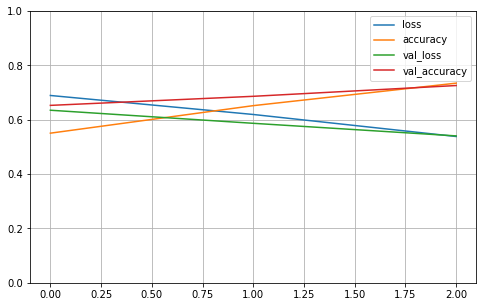

Train set ones/size 4700 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 551 / 959
Range of scores: 0.0058365543 to 0.9848082
Score threshold 0.5
Prediction set ones/size 388 / 959


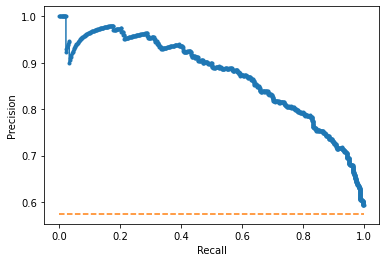

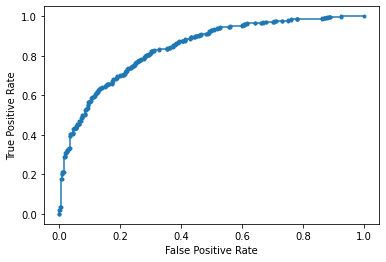

Accuracy: 72.58% Precision: 87.11% Recall: 61.34%
F1: 71.99% AUPRC: 87.23% AUROC: 84.15%
2023-02-14 17:47:09.800780
Fold 6
Discriminator is GMM
Means [-0.019609831503116015, -2.026907151697764]
Variances [1.72003759 2.15182845]
Priors [0.52980545 0.47019455]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 17:47:22.740313
PREDICT
2023-02-14 17:47:32.753152


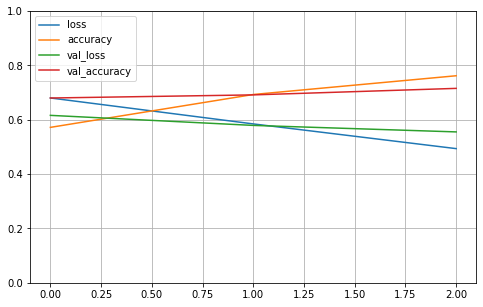

Train set ones/size 4763 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 527 / 959
Range of scores: 0.002977646 to 0.9729187
Score threshold 0.5
Prediction set ones/size 362 / 959


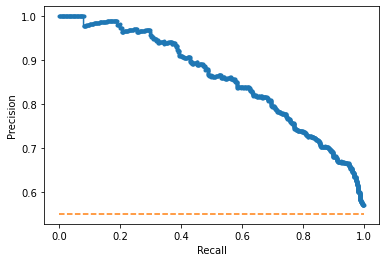

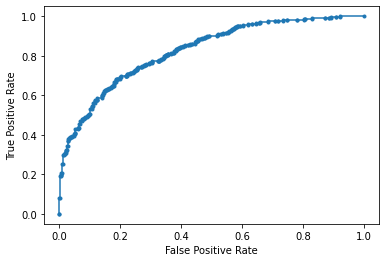

Accuracy: 71.53% Precision: 85.08% Recall: 58.44%
F1: 69.29% AUPRC: 85.82% AUROC: 82.60%
2023-02-14 17:47:33.683582
Fold 7
Discriminator is GMM
Means [-2.001176608896041, 0.006506146955454631]
Variances [2.04406451 1.71364693]
Priors [0.47309381 0.52690619]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 17:47:46.133981
PREDICT
2023-02-14 17:47:55.529831


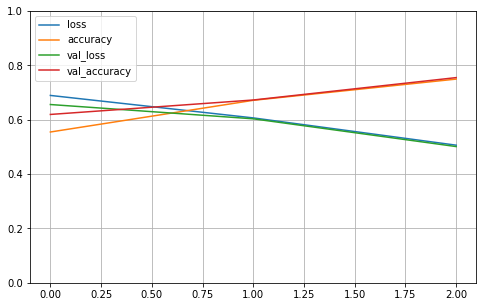

Train set ones/size 4719 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 494 / 959
Range of scores: 0.00531621 to 0.9935562
Score threshold 0.5
Prediction set ones/size 537 / 959


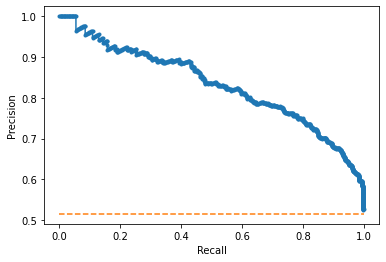

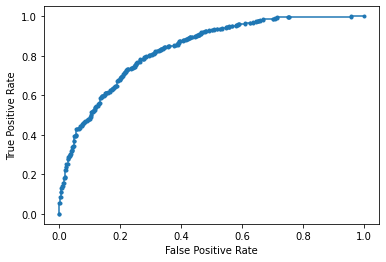

Accuracy: 75.50% Precision: 74.12% Recall: 80.57%
F1: 77.21% AUPRC: 83.24% AUROC: 83.44%
2023-02-14 17:47:56.231667
Fold 8
Discriminator is GMM
Means [9.007513619291694e-05, -2.009600675773174]
Variances [1.73726102 2.08319096]
Priors [0.52648548 0.47351452]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 17:48:08.131573
PREDICT
2023-02-14 17:48:18.125659


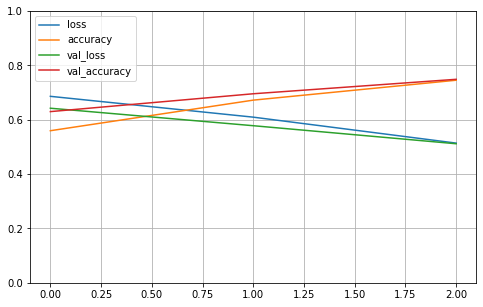

Train set ones/size 4728 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 523 / 959
Range of scores: 0.007704672 to 0.99084574
Score threshold 0.5
Prediction set ones/size 570 / 959


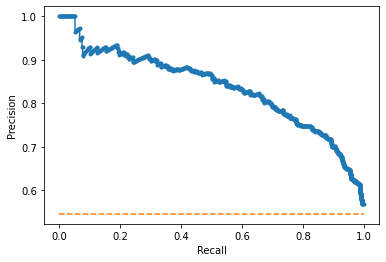

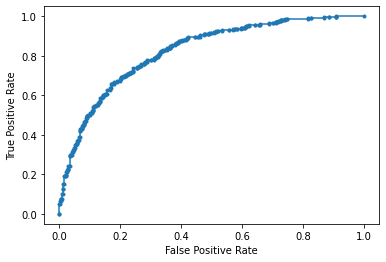

Accuracy: 74.87% Precision: 74.74% Recall: 81.45%
F1: 77.95% AUPRC: 83.67% AUROC: 82.38%
2023-02-14 17:48:18.807616
Fold 9
Discriminator is GMM
Means [0.004046970525555007, -2.026076190507939]
Variances [1.72262935 2.07483847]
Priors [0.52502558 0.47497442]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 17:48:31.721772
PREDICT
2023-02-14 17:48:41.673137


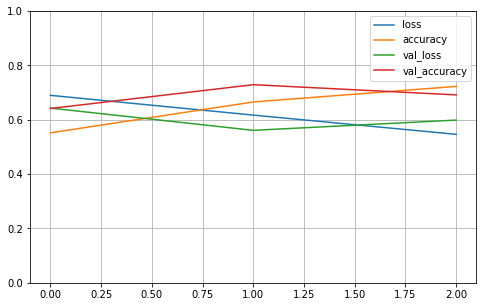

Train set ones/size 4715 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 536 / 959
Range of scores: 0.00041438977 to 0.9243749
Score threshold 0.5
Prediction set ones/size 352 / 959


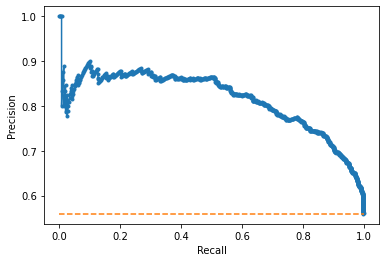

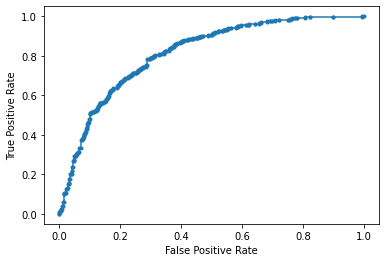

Accuracy: 69.13% Precision: 84.09% Recall: 55.22%
F1: 66.67% AUPRC: 81.55% AUROC: 81.44%
2023-02-14 17:48:42.363753
Fold 10
Discriminator is GMM
Means [-0.0029986480244935, -2.029323289193696]
Variances [1.72423738 2.09813806]
Priors [0.52884659 0.47115341]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 17:48:54.489601
PREDICT
2023-02-14 17:49:06.088833


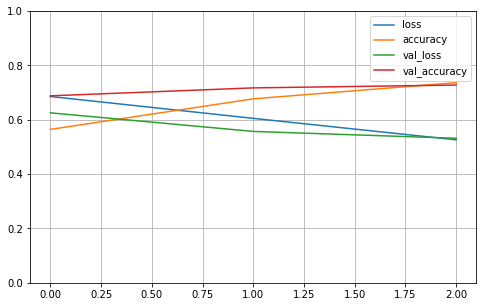

Train set ones/size 4748 / 8631
Compute valiation accuracy
Valid sizes (958, 4997) (958,)
Valid set ones/size 515 / 958
Range of scores: 0.0057159956 to 0.9789357
Score threshold 0.5
Prediction set ones/size 496 / 958


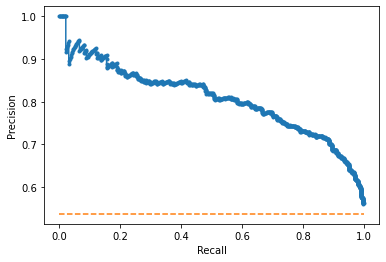

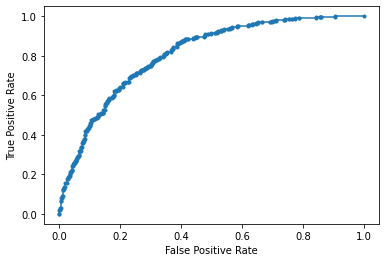

Accuracy: 72.76% Precision: 75.60% Recall: 72.82%
F1: 74.18% AUPRC: 80.78% AUROC: 80.85%
2023-02-14 17:49:06.799333

Completed cross validation 10 folds 3 epochs
 accuracy mean 73.19% +/- 2.12
 precision mean 78.16% +/- 5.51
 recall mean 72.55% +/- 10.62
 F1 mean 74.47% +/- 4.08
 AUPRC mean 83.31% +/- 2.44
 AUROC mean 81.97% +/- 1.49
Finished cell Line 5 HUVEC

2023-02-14 17:49:08.250858
Start cell Line 6 MCF.7
Number of RCI values loaded 2156
Num RCI: 2156
Load sequence...
Cross validation...
2023-02-14 17:49:25.516527
splitting
Fold 1
Discriminator is GMM
Means [-0.06532587668754168, -2.1318390285976943]
Variances [2.12804729 3.44737818]
Priors [0.48238922 0.51761078]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 17:49:40.828360
PREDICT
2023-02-14 17:49:52.692268


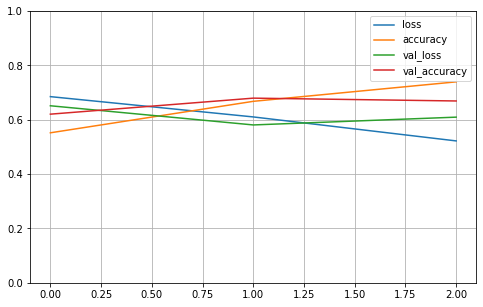

Train set ones/size 5359 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 636 / 1154
Range of scores: 0.0017489434 to 0.9874254
Score threshold 0.5
Prediction set ones/size 386 / 1154


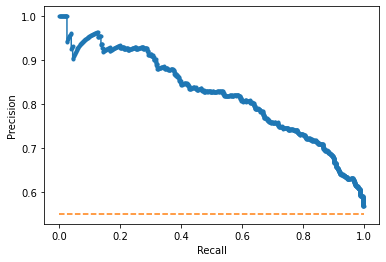

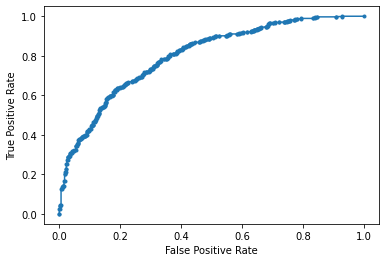

Accuracy: 66.90% Precision: 82.90% Recall: 50.31%
F1: 62.62% AUPRC: 82.32% AUROC: 79.97%
2023-02-14 17:49:53.583102
Fold 2
Discriminator is GMM
Means [-2.1245605533254803, -0.09739686802738956]
Variances [3.48799059 2.11281997]
Priors [0.50934158 0.49065842]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 17:50:04.902862
PREDICT
2023-02-14 17:50:16.735973


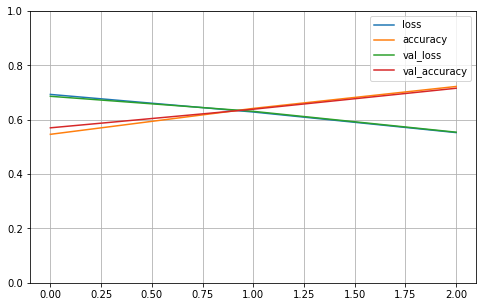

Train set ones/size 5532 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 615 / 1154
Range of scores: 0.0053707156 to 0.9796641
Score threshold 0.5
Prediction set ones/size 589 / 1154


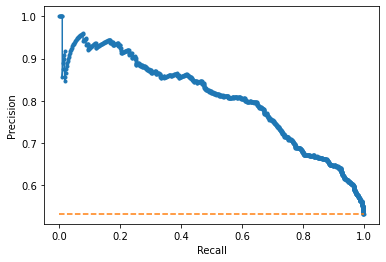

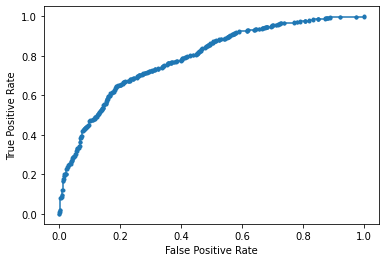

Accuracy: 71.58% Precision: 74.36% Recall: 71.22%
F1: 72.76% AUPRC: 80.53% AUROC: 78.96%
2023-02-14 17:50:17.465840
Fold 3
Discriminator is GMM
Means [-2.132472020599272, -0.058384068232677826]
Variances [3.37897661 2.0881166 ]
Priors [0.51131475 0.48868525]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 17:50:32.079498
PREDICT
2023-02-14 17:50:43.872841


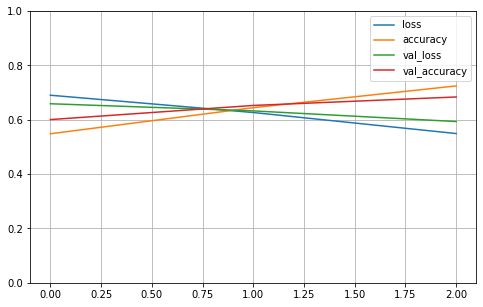

Train set ones/size 5425 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 588 / 1154
Range of scores: 0.022954244 to 0.98351514
Score threshold 0.5
Prediction set ones/size 829 / 1154


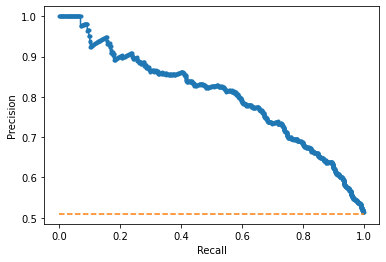

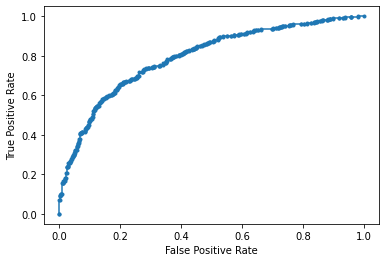

Accuracy: 68.37% Precision: 63.45% Recall: 89.46%
F1: 74.24% AUPRC: 80.22% AUROC: 79.30%
2023-02-14 17:50:44.621303
Fold 4
Discriminator is GMM
Means [-0.06405097807548599, -2.131079701096893]
Variances [2.10842833 3.39153752]
Priors [0.48759598 0.51240402]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 17:50:57.485202
PREDICT
2023-02-14 17:51:09.039121


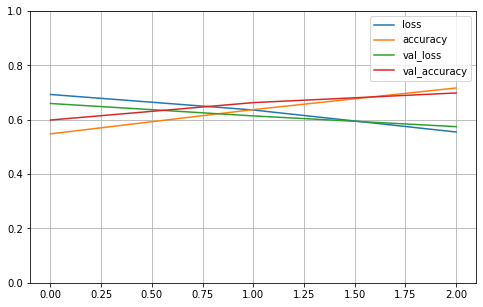

Train set ones/size 5404 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 603 / 1154
Range of scores: 0.010327796 to 0.9898442
Score threshold 0.5
Prediction set ones/size 623 / 1154


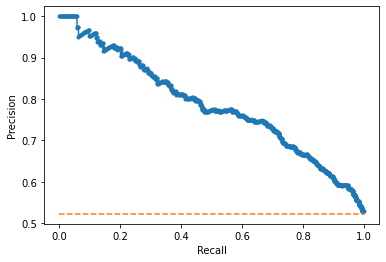

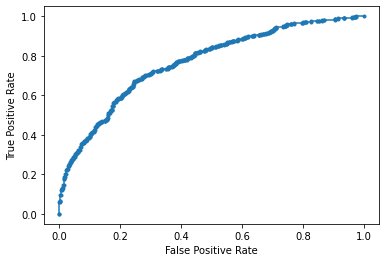

Accuracy: 69.84% Precision: 70.47% Recall: 72.80%
F1: 71.62% AUPRC: 78.61% AUROC: 76.64%
2023-02-14 17:51:09.776798
Fold 5
Discriminator is GMM
Means [-0.09207305218371445, -2.127039861183407]
Variances [2.12312551 3.468672  ]
Priors [0.49566622 0.50433378]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 17:51:21.619136
PREDICT
2023-02-14 17:51:33.493193


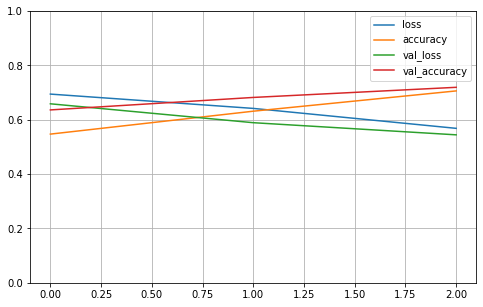

Train set ones/size 5567 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 588 / 1154
Range of scores: 0.031067181 to 0.9842074
Score threshold 0.5
Prediction set ones/size 714 / 1154


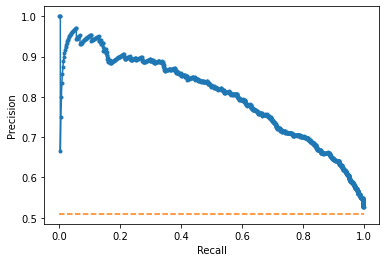

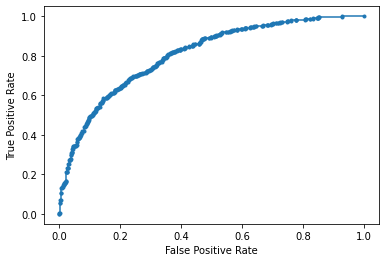

Accuracy: 71.92% Precision: 68.49% Recall: 83.16%
F1: 75.12% AUPRC: 80.29% AUROC: 80.63%
2023-02-14 17:51:34.235892
Fold 6
Discriminator is GMM
Means [-0.06433798577301389, -2.127872573615196]
Variances [2.09905411 3.40159355]
Priors [0.49020341 0.50979659]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 17:51:47.443369
PREDICT
2023-02-14 17:51:59.154174


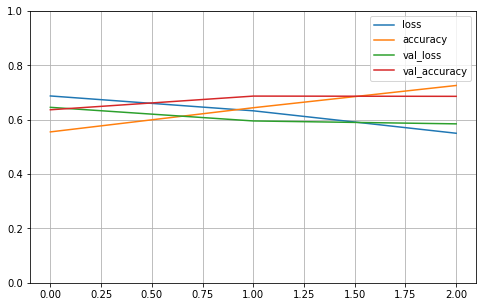

Train set ones/size 5466 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 588 / 1153
Range of scores: 0.006290996 to 0.9770597
Score threshold 0.5
Prediction set ones/size 330 / 1153


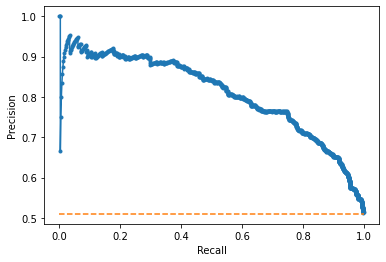

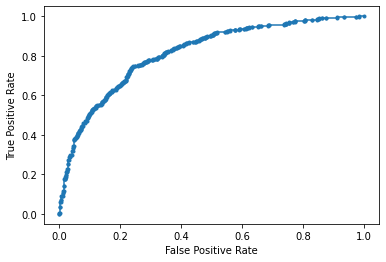

Accuracy: 68.60% Precision: 84.24% Recall: 47.28%
F1: 60.57% AUPRC: 80.88% AUROC: 81.47%
2023-02-14 17:51:59.913009
Fold 7
Discriminator is GMM
Means [-0.06540537756980526, -2.1406434432247643]
Variances [2.10825555 3.46475136]
Priors [0.48839775 0.51160225]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 17:52:14.510564
PREDICT
2023-02-14 17:52:26.203681


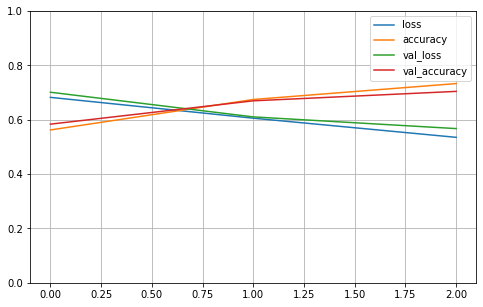

Train set ones/size 5447 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 609 / 1153
Range of scores: 0.002442068 to 0.992759
Score threshold 0.5
Prediction set ones/size 688 / 1153


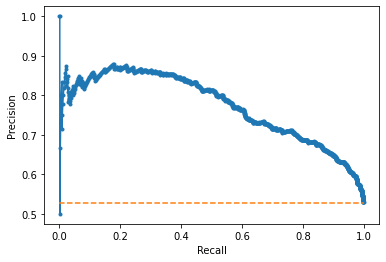

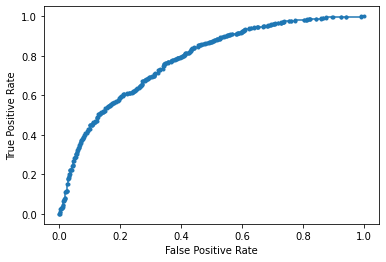

Accuracy: 70.42% Precision: 69.48% Recall: 78.49%
F1: 73.71% AUPRC: 77.31% AUROC: 78.03%
2023-02-14 17:52:26.924963
Fold 8
Discriminator is GMM
Means [-0.07998427612173649, -2.122073351195112]
Variances [2.14193094 3.49438856]
Priors [0.48858551 0.51141449]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 17:52:41.286479
PREDICT
2023-02-14 17:52:52.836995


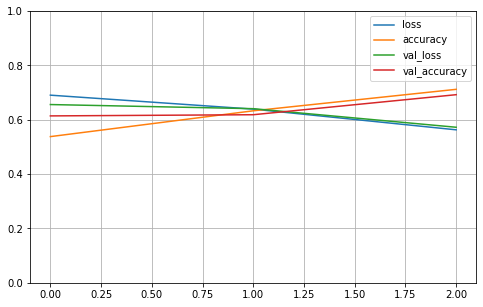

Train set ones/size 5450 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 614 / 1153
Range of scores: 0.021567762 to 0.9716191
Score threshold 0.5
Prediction set ones/size 689 / 1153


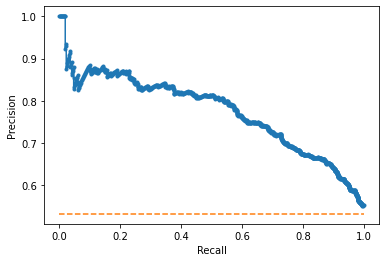

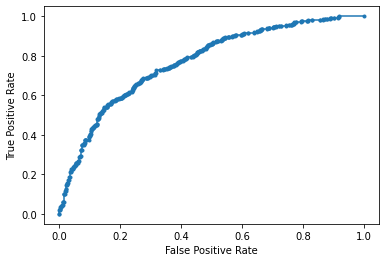

Accuracy: 69.21% Precision: 68.80% Recall: 77.20%
F1: 72.76% AUPRC: 77.52% AUROC: 76.98%
2023-02-14 17:52:53.686738
Fold 9
Discriminator is GMM
Means [-0.05355741635273544, -2.1244148480931275]
Variances [2.09463023 3.37862845]
Priors [0.48456991 0.51543009]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 17:53:07.127097
PREDICT
2023-02-14 17:53:18.830243


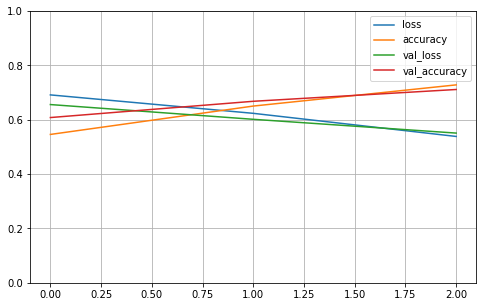

Train set ones/size 5387 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 604 / 1153
Range of scores: 0.0017534982 to 0.9784806
Score threshold 0.5
Prediction set ones/size 535 / 1153


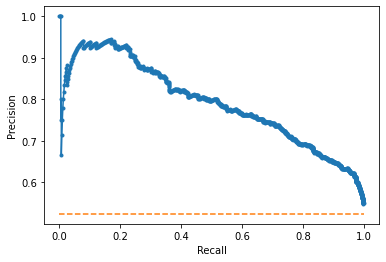

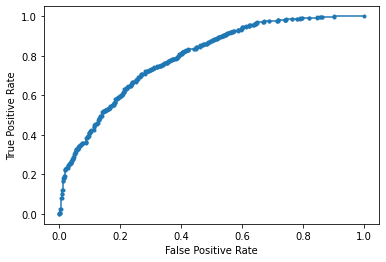

Accuracy: 71.12% Precision: 75.33% Recall: 66.72%
F1: 70.76% AUPRC: 79.19% AUROC: 79.21%
2023-02-14 17:53:19.602632
Fold 10
Discriminator is GMM
Means [-2.1270498991248608, -0.07025913177764062]
Variances [3.46248808 2.11019483]
Priors [0.51211291 0.48788709]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 17:53:33.660146
PREDICT
2023-02-14 17:53:45.178266


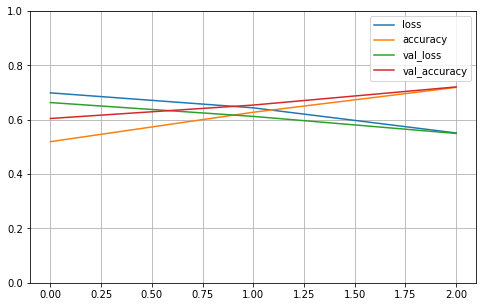

Train set ones/size 5446 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 606 / 1153
Range of scores: 0.0025651567 to 0.98738515
Score threshold 0.5
Prediction set ones/size 712 / 1153


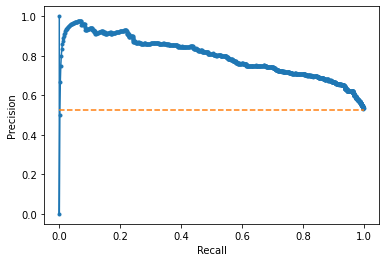

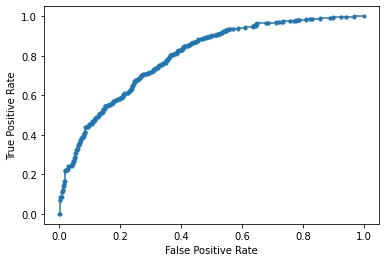

Accuracy: 72.07% Precision: 69.94% Recall: 82.18%
F1: 75.57% AUPRC: 79.80% AUROC: 79.63%
2023-02-14 17:53:46.043746

Completed cross validation 10 folds 3 epochs
 accuracy mean 70.00% +/- 1.73
 precision mean 72.75% +/- 6.57
 recall mean 71.88% +/- 13.79
 F1 mean 70.97% +/- 5.18
 AUPRC mean 79.67% +/- 1.55
 AUROC mean 79.08% +/- 1.52
Finished cell Line 6 MCF.7

2023-02-14 17:53:47.526841
Start cell Line 7 NCI.H460
Number of RCI values loaded 610
Num RCI: 610
Load sequence...
Cross validation...
2023-02-14 17:53:54.607579
splitting
Fold 1
Discriminator is GMM
Means [-0.869852466763317, -1.8566691558230763]
Variances [1.38909664 3.19914361]
Priors [0.55561881 0.44438119]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 1]
FIT
2023-02-14 17:54:03.734321
PREDICT
2023-02-14 17:54:09.961893


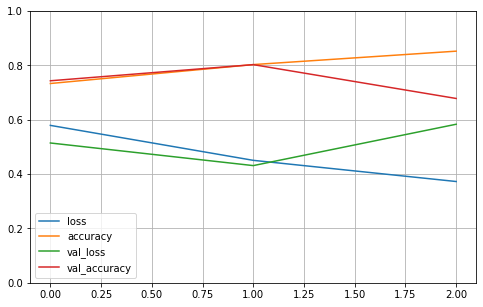

Train set ones/size 3484 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 388 / 522
Range of scores: 0.0034383505 to 0.99857676
Score threshold 0.5
Prediction set ones/size 284 / 522


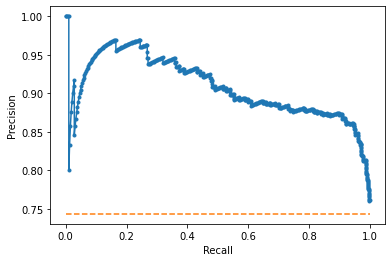

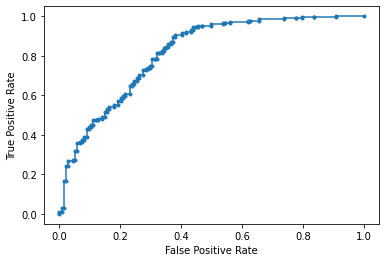

Accuracy: 67.82% Precision: 88.73% Recall: 64.95%
F1: 75.00% AUPRC: 90.78% AUROC: 81.59%
2023-02-14 17:54:10.988255
Fold 2
Discriminator is GMM
Means [-1.86686142624886, -0.8393330771921415]
Variances [3.17159998 1.42016454]
Priors [0.4459089 0.5540911]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 1]
FIT
2023-02-14 17:54:22.831863
PREDICT
2023-02-14 17:54:34.628581


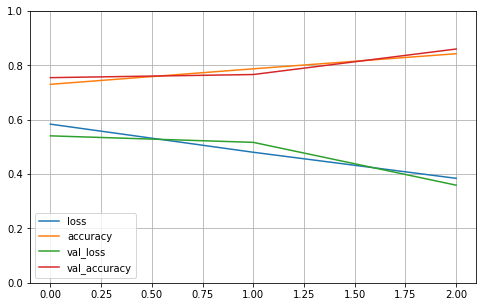

Train set ones/size 3452 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 392 / 522
Range of scores: 0.037297394 to 0.9980914
Score threshold 0.5
Prediction set ones/size 427 / 522


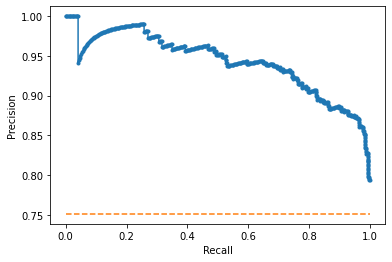

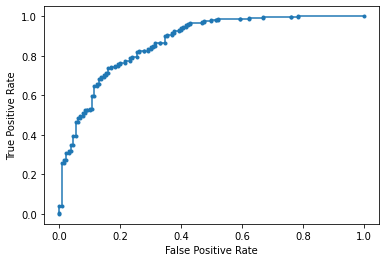

Accuracy: 86.02% Precision: 87.35% Recall: 95.15%
F1: 91.09% AUPRC: 94.29% AUROC: 86.95%
2023-02-14 17:54:35.267913
Fold 3
Discriminator is GMM
Means [-0.8675078050271064, -1.8513624531477786]
Variances [1.36328391 3.18017334]
Priors [0.55690671 0.44309329]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 0]
FIT
2023-02-14 17:54:44.065777
PREDICT
2023-02-14 17:54:50.184432


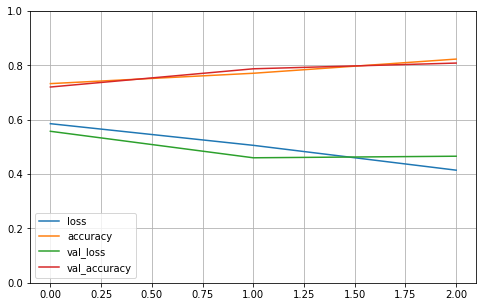

Train set ones/size 3480 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 376 / 522
Range of scores: 0.095187075 to 0.99863404
Score threshold 0.5
Prediction set ones/size 472 / 522


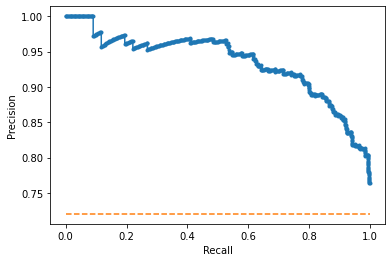

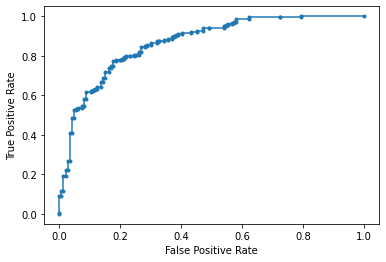

Accuracy: 80.84% Precision: 79.24% Recall: 99.47%
F1: 88.21% AUPRC: 93.54% AUROC: 86.78%
2023-02-14 17:54:51.099067
Fold 4
Discriminator is GMM
Means [-0.8871029953085682, -1.8031139857814298]
Variances [1.40622937 3.26337954]
Priors [0.55874691 0.44125309]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 0]
FIT
2023-02-14 17:54:59.867901
PREDICT
2023-02-14 17:55:06.287083


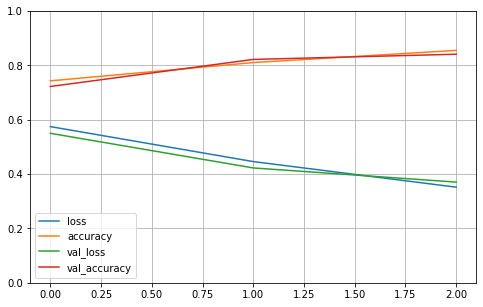

Train set ones/size 3514 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 377 / 522
Range of scores: 0.018986236 to 0.9979176
Score threshold 0.5
Prediction set ones/size 424 / 522


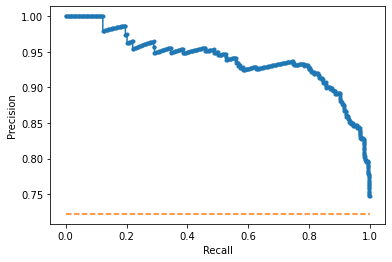

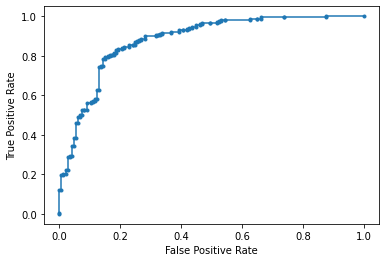

Accuracy: 84.10% Precision: 84.67% Recall: 95.23%
F1: 89.64% AUPRC: 93.97% AUROC: 87.93%
2023-02-14 17:55:06.931994
Fold 5
Discriminator is GMM
Means [-1.8568566257400205, -0.8577514470137899]
Variances [3.09699805 1.40252135]
Priors [0.44639985 0.55360015]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 1]
FIT
2023-02-14 17:55:18.870993
PREDICT
2023-02-14 17:55:24.918989


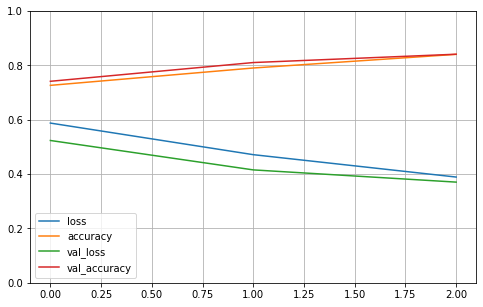

Train set ones/size 3457 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 387 / 522
Range of scores: 0.030475302 to 0.9972109
Score threshold 0.5
Prediction set ones/size 392 / 522


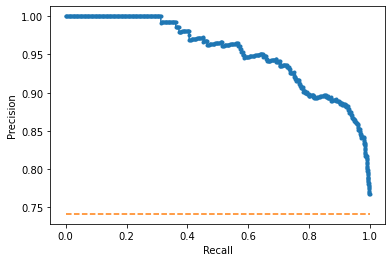

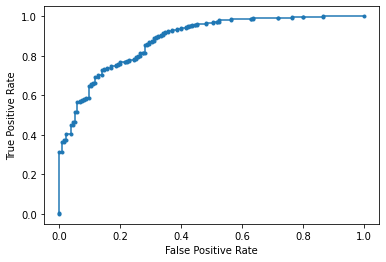

Accuracy: 84.10% Precision: 88.78% Recall: 89.92%
F1: 89.35% AUPRC: 95.32% AUROC: 88.25%
2023-02-14 17:55:25.606338
Fold 6
Discriminator is GMM
Means [-0.954034319417282, -1.9789342942383261]
Variances [1.4851436  3.61558442]
Priors [0.65761142 0.34238858]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 1]
FIT
2023-02-14 17:55:36.896755
PREDICT
2023-02-14 17:55:43.104660


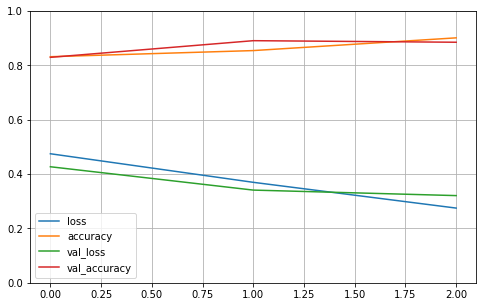

Train set ones/size 3921 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 433 / 522
Range of scores: 0.023523714 to 0.9990012
Score threshold 0.5
Prediction set ones/size 467 / 522


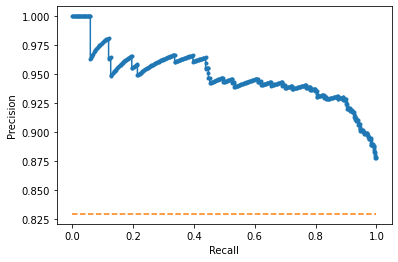

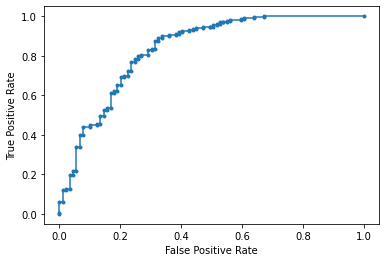

Accuracy: 88.51% Precision: 89.94% Recall: 97.00%
F1: 93.33% AUPRC: 94.83% AUROC: 83.39%
2023-02-14 17:55:44.024836
Fold 7
Discriminator is GMM
Means [-1.0033495535568602, -1.9107418971906165]
Variances [1.49299407 3.82712381]
Priors [0.6694869 0.3305131]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 1]
FIT
2023-02-14 17:55:53.903883
PREDICT
2023-02-14 17:56:00.757391


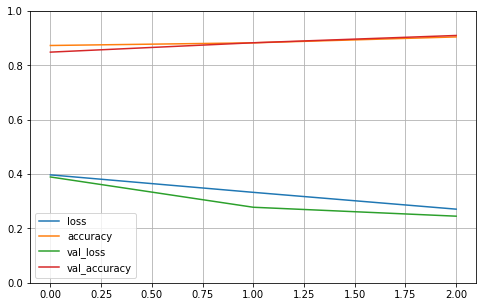

Train set ones/size 4104 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 443 / 522
Range of scores: 0.0091737 to 0.99864656
Score threshold 0.5
Prediction set ones/size 462 / 522


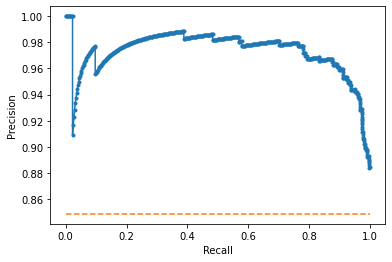

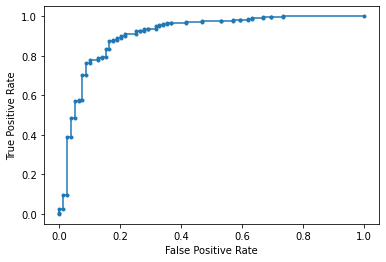

Accuracy: 91.00% Precision: 92.86% Recall: 96.84%
F1: 94.81% AUPRC: 97.28% AUROC: 90.85%
2023-02-14 17:56:01.395384
Fold 8
Discriminator is GMM
Means [-1.8691923654706326, -0.8582214659715081]
Variances [3.17663271 1.37643044]
Priors [0.44625679 0.55374321]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 1]
FIT
2023-02-14 17:56:13.505504
PREDICT
2023-02-14 17:56:19.481204


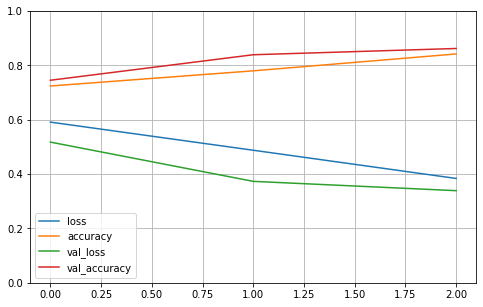

Train set ones/size 3456 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 389 / 522
Range of scores: 0.01476724 to 0.9981369
Score threshold 0.5
Prediction set ones/size 395 / 522


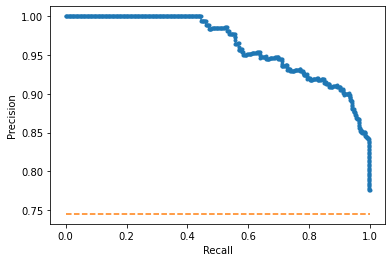

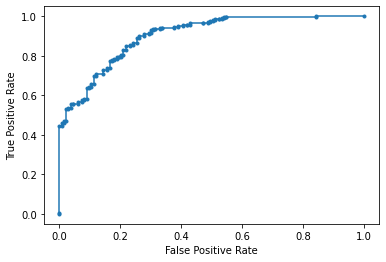

Accuracy: 86.21% Precision: 90.13% Recall: 91.52%
F1: 90.82% AUPRC: 96.32% AUROC: 90.34%
2023-02-14 17:56:20.153548
Fold 9
Discriminator is GMM
Means [-0.9772214865239451, -1.9895867769808087]
Variances [1.50761606 3.57948694]
Priors [0.66551344 0.33448656]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 1]
FIT
2023-02-14 17:56:32.983207
PREDICT
2023-02-14 17:56:39.434937


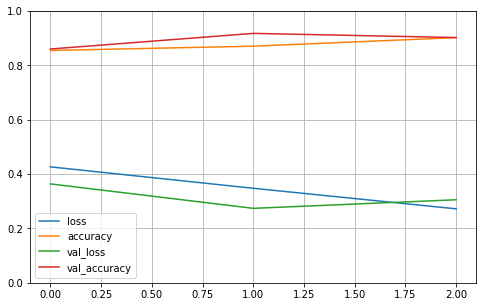

Train set ones/size 4030 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 449 / 522
Range of scores: 0.052746605 to 0.99978346
Score threshold 0.5
Prediction set ones/size 498 / 522


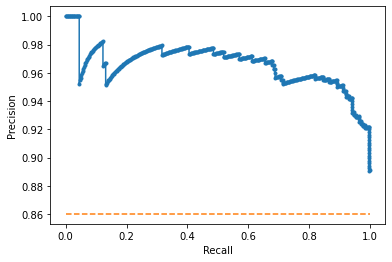

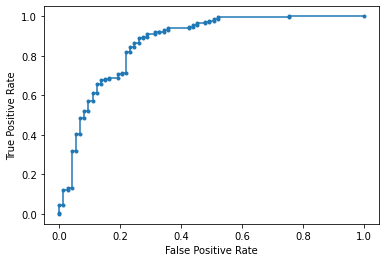

Accuracy: 90.23% Precision: 89.96% Recall: 99.78%
F1: 94.61% AUPRC: 96.57% AUROC: 86.80%
2023-02-14 17:56:40.089118
Fold 10
Discriminator is GMM
Means [-0.9500803641088488, -2.0108625169068457]
Variances [1.55058016 3.5028604 ]
Priors [0.65805973 0.34194027]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 1]
FIT
2023-02-14 17:56:50.529590
PREDICT
2023-02-14 17:56:56.695577


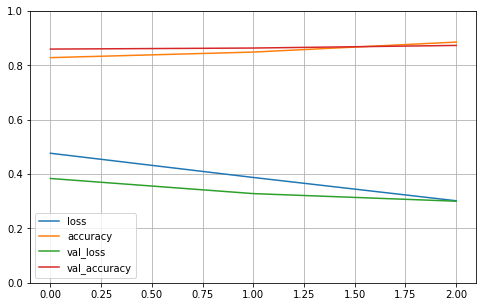

Train set ones/size 3909 / 4698
Compute valiation accuracy
Valid sizes (521, 4997) (521,)
Valid set ones/size 448 / 521
Range of scores: 0.016023058 to 0.99707067
Score threshold 0.5
Prediction set ones/size 438 / 521


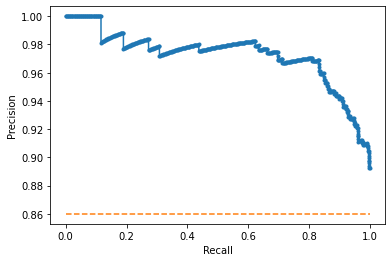

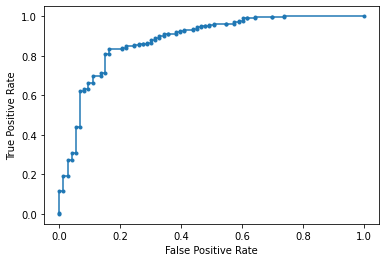

Accuracy: 87.33% Precision: 93.61% Recall: 91.52%
F1: 92.55% AUPRC: 97.25% AUROC: 87.91%
2023-02-14 17:56:57.392785

Completed cross validation 10 folds 3 epochs
 accuracy mean 84.61% +/- 6.64
 precision mean 88.53% +/- 4.13
 recall mean 92.14% +/- 10.12
 F1 mean 89.94% +/- 5.70
 AUPRC mean 95.01% +/- 2.00
 AUROC mean 87.08% +/- 2.82
Finished cell Line 7 NCI.H460

2023-02-14 17:56:58.716083
Start cell Line 8 NHEK
Number of RCI values loaded 1080
Num RCI: 1080
Load sequence...
Cross validation...
2023-02-14 17:57:11.718830
splitting
Fold 1
Discriminator is GMM
Means [0.47765467018497954, -1.7897332813124602]
Variances [1.57174611 2.62118401]
Priors [0.50130531 0.49869469]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:57:22.126294
PREDICT
2023-02-14 17:57:33.653038


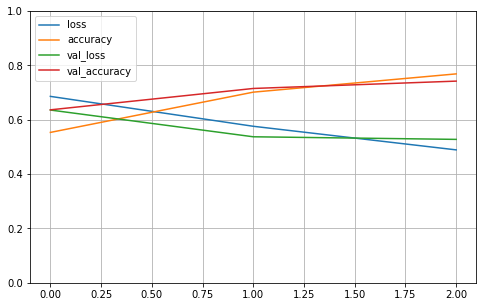

Train set ones/size 3839 / 7318
Compute valiation accuracy
Valid sizes (814, 4997) (814,)
Valid set ones/size 446 / 814
Range of scores: 0.0012075987 to 0.9902098
Score threshold 0.5
Prediction set ones/size 474 / 814


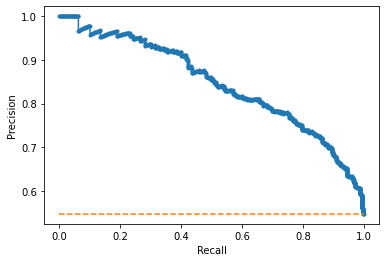

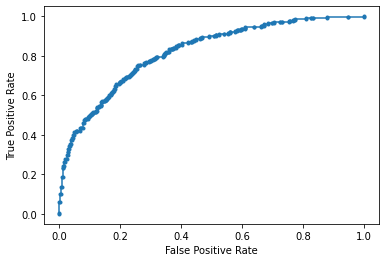

Accuracy: 74.20% Precision: 74.89% Recall: 79.60%
F1: 77.17% AUPRC: 84.66% AUROC: 81.94%
2023-02-14 17:57:34.357940
Fold 2
Discriminator is GMM
Means [0.505248313205532, -1.7511962085154045]
Variances [1.57117515 2.62960231]
Priors [0.49188018 0.50811982]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:57:48.030134
PREDICT
2023-02-14 17:57:56.299403


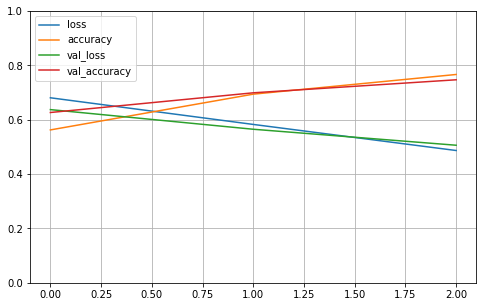

Train set ones/size 3780 / 7318
Compute valiation accuracy
Valid sizes (814, 4997) (814,)
Valid set ones/size 422 / 814
Range of scores: 0.009770941 to 0.99623966
Score threshold 0.5
Prediction set ones/size 484 / 814


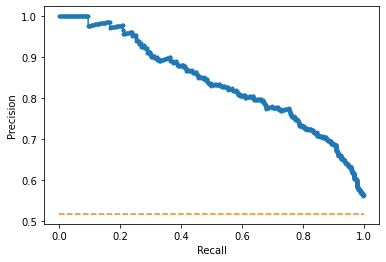

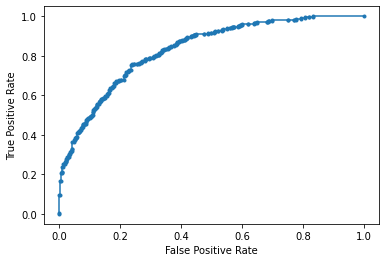

Accuracy: 74.69% Precision: 72.31% Recall: 82.94%
F1: 77.26% AUPRC: 83.96% AUROC: 83.10%
2023-02-14 17:57:57.282484
Fold 3
Discriminator is GMM
Means [0.5074737254530738, -1.7930766897258765]
Variances [1.56306487 2.59800054]
Priors [0.49988222 0.50011778]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:58:07.802952
PREDICT
2023-02-14 17:58:19.318804


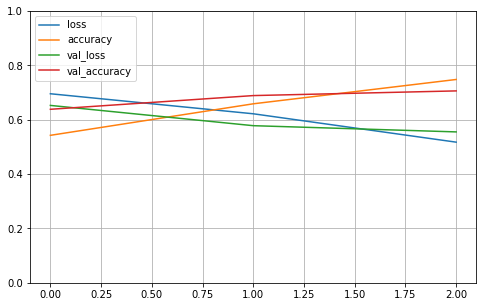

Train set ones/size 3821 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 420 / 813
Range of scores: 0.0031208184 to 0.99237615
Score threshold 0.5
Prediction set ones/size 303 / 813


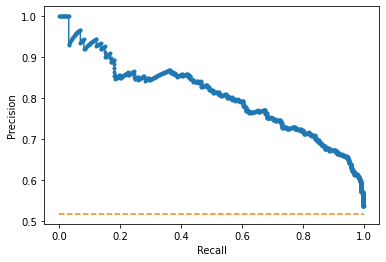

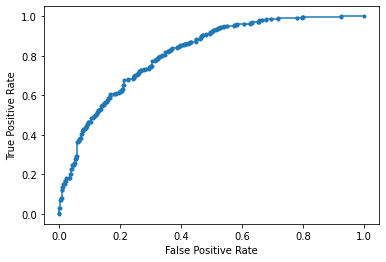

Accuracy: 70.60% Precision: 79.87% Recall: 57.62%
F1: 66.94% AUPRC: 80.51% AUROC: 81.39%
2023-02-14 17:58:20.015893
Fold 4
Discriminator is GMM
Means [0.45704771370083896, -1.7935480733016487]
Variances [1.59723396 2.6959796 ]
Priors [0.50722001 0.49277999]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:58:31.744922
PREDICT
2023-02-14 17:58:40.464029


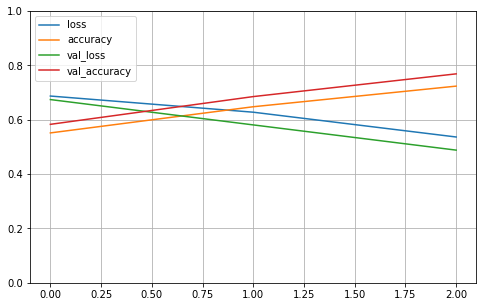

Train set ones/size 3927 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 435 / 813
Range of scores: 0.007359922 to 0.96259165
Score threshold 0.5
Prediction set ones/size 383 / 813


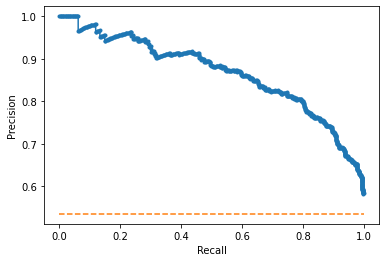

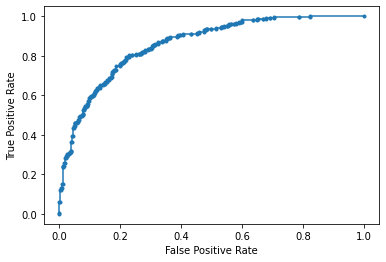

Accuracy: 76.88% Precision: 82.25% Recall: 72.41%
F1: 77.02% AUPRC: 86.75% AUROC: 85.94%
2023-02-14 17:58:41.137415
Fold 5
Discriminator is GMM
Means [0.44931776089761155, -1.8284412826967764]
Variances [1.62348636 2.67452638]
Priors [0.51920478 0.48079522]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:58:51.381523
PREDICT
2023-02-14 17:58:59.937874


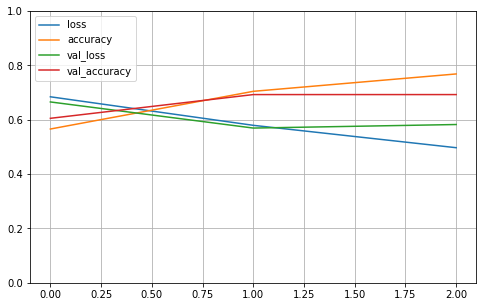

Train set ones/size 4049 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 435 / 813
Range of scores: 0.0041315756 to 0.9882697
Score threshold 0.5
Prediction set ones/size 305 / 813


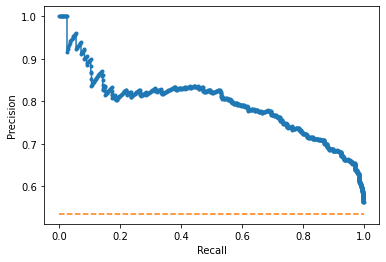

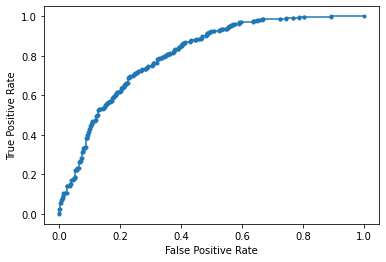

Accuracy: 69.25% Precision: 80.33% Recall: 56.32%
F1: 66.22% AUPRC: 79.49% AUROC: 80.55%
2023-02-14 17:59:00.630148
Fold 6
Discriminator is GMM
Means [-1.794307242320937, 0.502054916734037]
Variances [2.64626357 1.5905557 ]
Priors [0.49979414 0.50020586]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:59:11.660168
PREDICT
2023-02-14 17:59:20.407496


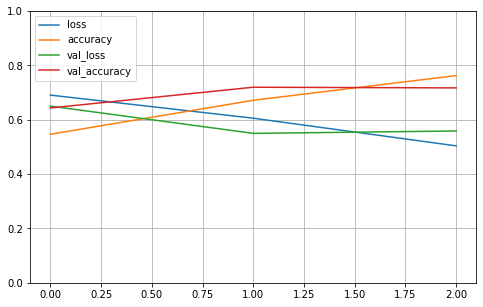

Train set ones/size 3832 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 433 / 813
Range of scores: 0.019081175 to 0.9951822
Score threshold 0.5
Prediction set ones/size 589 / 813


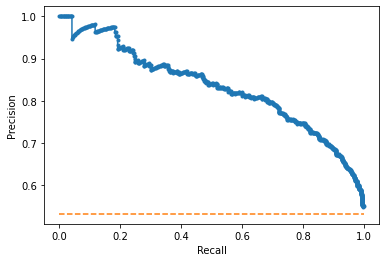

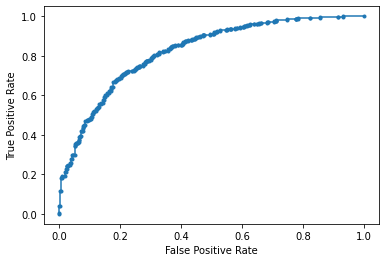

Accuracy: 71.71% Precision: 67.23% Recall: 91.45%
F1: 77.50% AUPRC: 83.35% AUROC: 82.30%
2023-02-14 17:59:21.096522
Fold 7
Discriminator is GMM
Means [-1.819739596941677, 0.462000592903528]
Variances [2.63368547 1.58293956]
Priors [0.49303258 0.50696742]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:59:31.720421
PREDICT
2023-02-14 17:59:43.605165


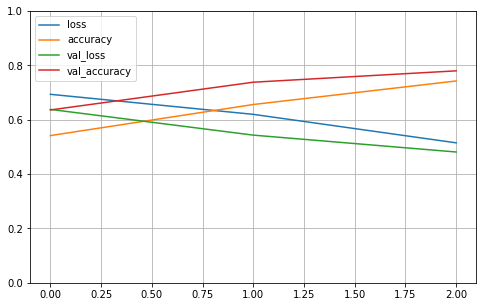

Train set ones/size 3905 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 457 / 813
Range of scores: 0.00551242 to 0.98584855
Score threshold 0.5
Prediction set ones/size 514 / 813


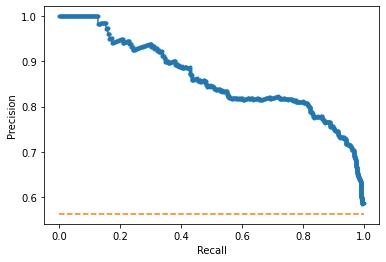

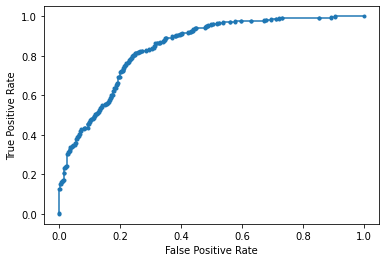

Accuracy: 77.98% Precision: 77.04% Recall: 86.65%
F1: 81.57% AUPRC: 86.24% AUROC: 84.39%
2023-02-14 17:59:44.690352
Fold 8
Discriminator is GMM
Means [-1.7911915053311538, 0.4628515732010283]
Variances [2.65447843 1.59779662]
Priors [0.49099085 0.50900915]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 17:59:54.898293
PREDICT
2023-02-14 18:00:03.917211


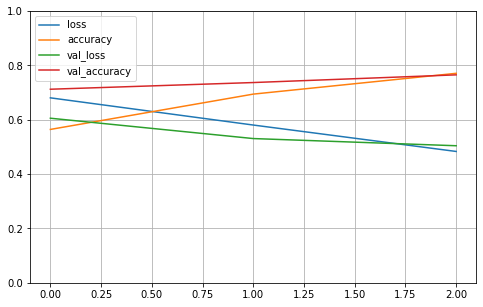

Train set ones/size 3936 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 426 / 813
Range of scores: 0.001295818 to 0.98399216
Score threshold 0.5
Prediction set ones/size 477 / 813


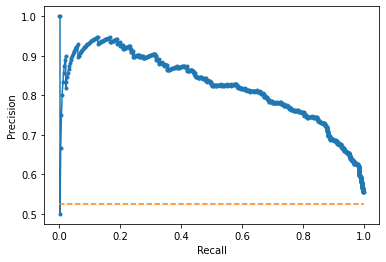

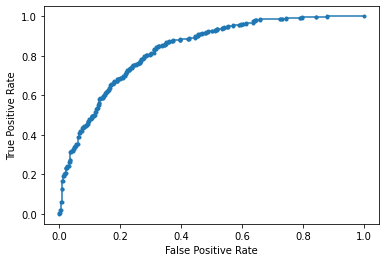

Accuracy: 76.51% Precision: 74.63% Recall: 83.57%
F1: 78.85% AUPRC: 82.39% AUROC: 83.32%
2023-02-14 18:00:04.621198
Fold 9
Discriminator is GMM
Means [0.4528251043247077, -1.8131641700090861]
Variances [1.61602238 2.67215853]
Priors [0.51580639 0.48419361]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 18:00:16.977885
PREDICT
2023-02-14 18:00:28.509593


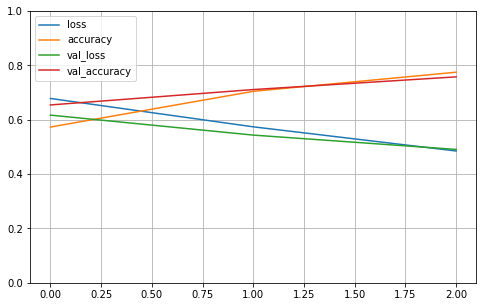

Train set ones/size 4022 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 437 / 813
Range of scores: 0.007841252 to 0.9904641
Score threshold 0.5
Prediction set ones/size 454 / 813


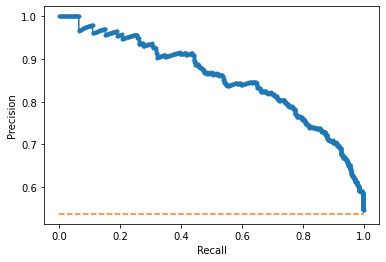

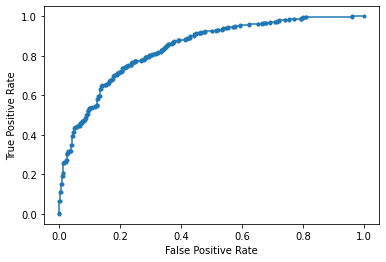

Accuracy: 75.77% Precision: 76.43% Recall: 79.41%
F1: 77.89% AUPRC: 85.60% AUROC: 84.04%
2023-02-14 18:00:29.187198
Fold 10
Discriminator is GMM
Means [0.4371257896030619, -1.8033493964736822]
Variances [1.60568735 2.70356478]
Priors [0.51532767 0.48467233]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 18:00:41.612430
PREDICT
2023-02-14 18:00:49.953396


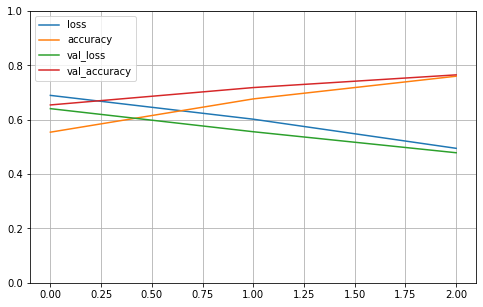

Train set ones/size 4044 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 427 / 813
Range of scores: 0.0077130175 to 0.9880121
Score threshold 0.5
Prediction set ones/size 408 / 813


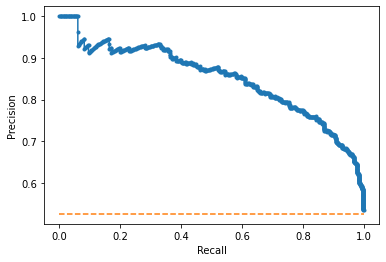

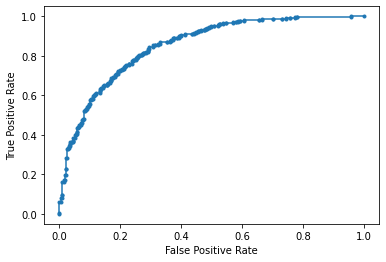

Accuracy: 76.51% Precision: 78.92% Recall: 75.41%
F1: 77.13% AUPRC: 85.07% AUROC: 85.19%
2023-02-14 18:00:50.904498

Completed cross validation 10 folds 3 epochs
 accuracy mean 74.41% +/- 2.94
 precision mean 76.39% +/- 4.40
 recall mean 76.54% +/- 11.63
 F1 mean 75.75% +/- 5.03
 AUPRC mean 83.80% +/- 2.40
 AUROC mean 83.22% +/- 1.71
Finished cell Line 8 NHEK

2023-02-14 18:00:52.477175
Start cell Line 9 SK.MEL.5
Number of RCI values loaded 534
Num RCI: 534
Load sequence...
Cross validation...
2023-02-14 18:00:59.506766
splitting
Fold 1
Discriminator is GMM
Means [-0.8939937841647633, -2.5901251254270554]
Variances [2.42494019 5.12918863]
Priors [0.57801841 0.42198159]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 1]
FIT
2023-02-14 18:01:08.484009
PREDICT
2023-02-14 18:01:14.407503


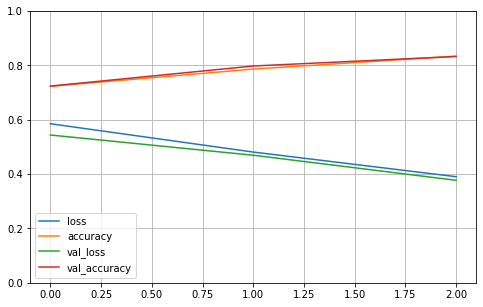

Train set ones/size 3377 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 372 / 514
Range of scores: 0.023824818 to 0.9975299
Score threshold 0.5
Prediction set ones/size 424 / 514


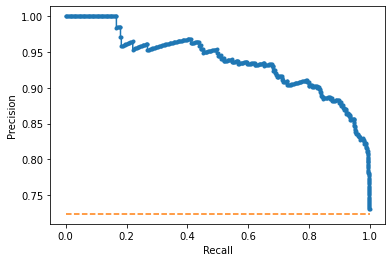

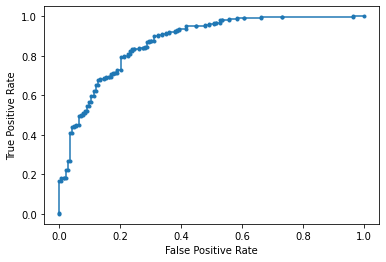

Accuracy: 83.27% Precision: 83.73% Recall: 95.43%
F1: 89.20% AUPRC: 93.78% AUROC: 87.09%
2023-02-14 18:01:15.098946
Fold 2
Discriminator is GMM
Means [-0.9004188705076472, -2.5832466031411556]
Variances [2.49011976 5.15363566]
Priors [0.57995647 0.42004353]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 1]
FIT
2023-02-14 18:01:26.060968
PREDICT
2023-02-14 18:01:32.474054


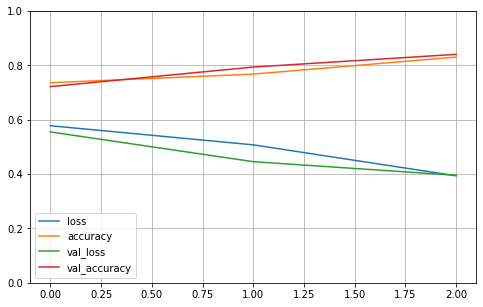

Train set ones/size 3425 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 372 / 514
Range of scores: 0.039311543 to 0.99859303
Score threshold 0.5
Prediction set ones/size 442 / 514


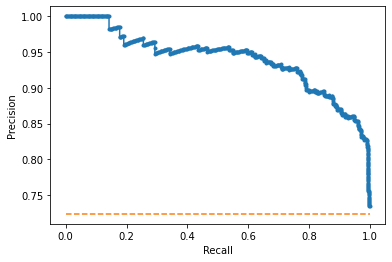

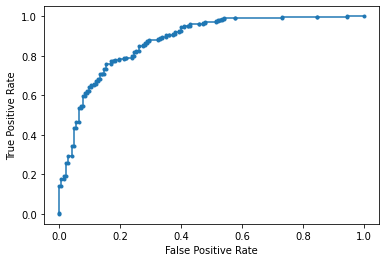

Accuracy: 84.05% Precision: 82.81% Recall: 98.39%
F1: 89.93% AUPRC: 94.02% AUROC: 87.65%
2023-02-14 18:01:33.162036
Fold 3
Discriminator is GMM
Means [-0.8791455135650127, -2.678252502296052]
Variances [2.45592028 5.05079977]
Priors [0.59450453 0.40549547]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 1]
FIT
2023-02-14 18:01:44.310532
PREDICT
2023-02-14 18:01:50.695399


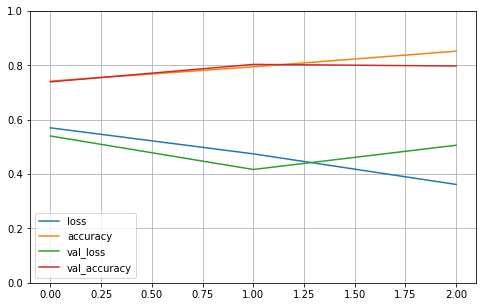

Train set ones/size 3446 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 380 / 514
Range of scores: 0.08869857 to 0.9998109
Score threshold 0.5
Prediction set ones/size 480 / 514


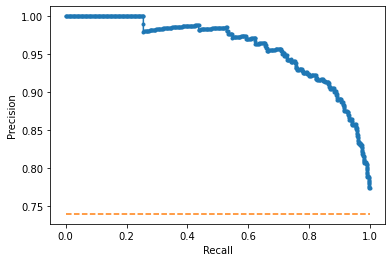

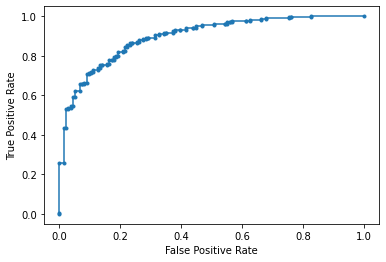

Accuracy: 79.77% Precision: 78.75% Recall: 99.47%
F1: 87.91% AUPRC: 95.96% AUROC: 89.72%
2023-02-14 18:01:51.383100
Fold 4
Discriminator is GMM
Means [-2.576061285306561, -0.8950588421504935]
Variances [5.0288423  2.42593656]
Priors [0.42334716 0.57665284]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 1]
FIT
2023-02-14 18:02:01.955138
PREDICT
2023-02-14 18:02:08.015769


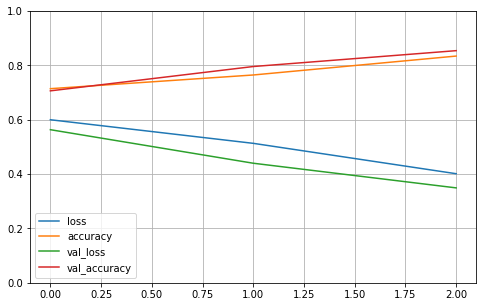

Train set ones/size 3348 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 363 / 514
Range of scores: 0.008489925 to 0.9982591
Score threshold 0.5
Prediction set ones/size 404 / 514


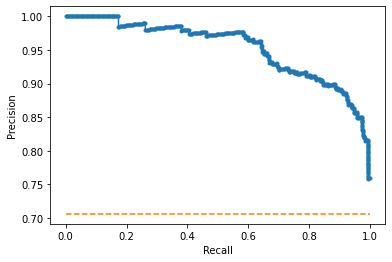

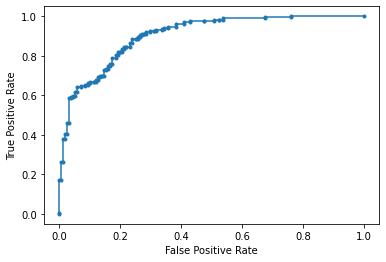

Accuracy: 85.41% Precision: 85.64% Recall: 95.32%
F1: 90.22% AUPRC: 95.31% AUROC: 90.32%
2023-02-14 18:02:08.859155
Fold 5
Discriminator is GMM
Means [-0.8964049026629359, -2.5886763555245818]
Variances [2.48881575 5.10495993]
Priors [0.57544604 0.42455396]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 1]
FIT
2023-02-14 18:02:18.321447
PREDICT
2023-02-14 18:02:24.956953


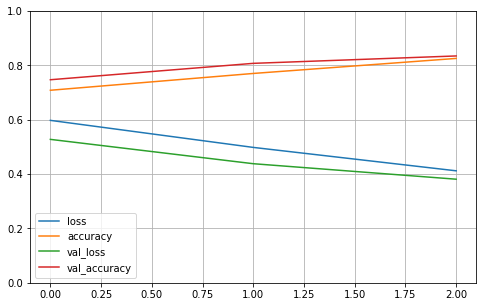

Train set ones/size 3344 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 384 / 514
Range of scores: 0.07741145 to 0.9983884
Score threshold 0.5
Prediction set ones/size 437 / 514


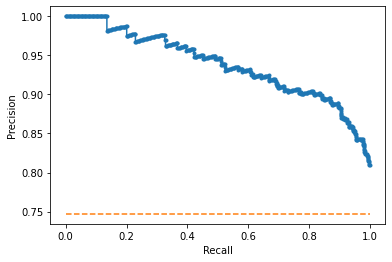

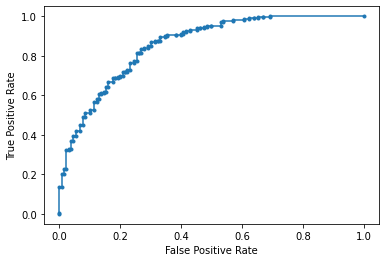

Accuracy: 83.46% Precision: 84.21% Recall: 95.83%
F1: 89.65% AUPRC: 93.84% AUROC: 85.60%
2023-02-14 18:02:25.688076
Fold 6
Discriminator is GMM
Means [-2.676831673245919, -0.8777308736698459]
Variances [5.1137983  2.48330134]
Priors [0.40688087 0.59311913]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 1]
FIT
2023-02-14 18:02:33.542029
PREDICT
2023-02-14 18:02:44.955810


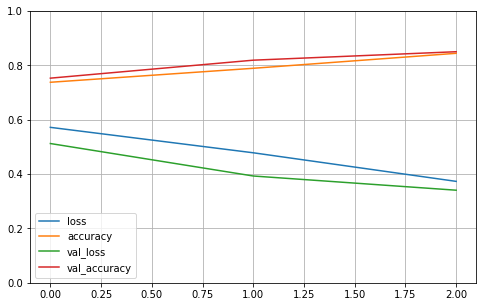

Train set ones/size 3440 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 386 / 514
Range of scores: 0.027384808 to 0.99907506
Score threshold 0.5
Prediction set ones/size 409 / 514


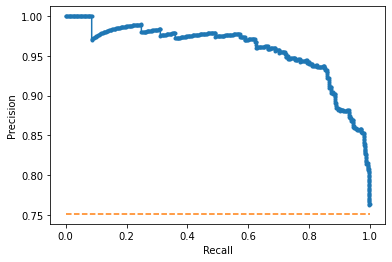

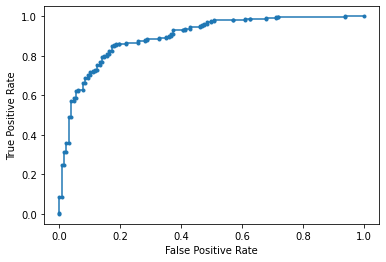

Accuracy: 85.02% Precision: 87.78% Recall: 93.01%
F1: 90.31% AUPRC: 95.82% AUROC: 89.75%
2023-02-14 18:02:45.672130
Fold 7
Discriminator is GMM
Means [-2.594125726604882, -0.8992744263398786]
Variances [5.12261908 2.42390183]
Priors [0.42850231 0.57149769]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 1]
FIT
2023-02-14 18:02:56.675350
PREDICT
2023-02-14 18:03:02.910223


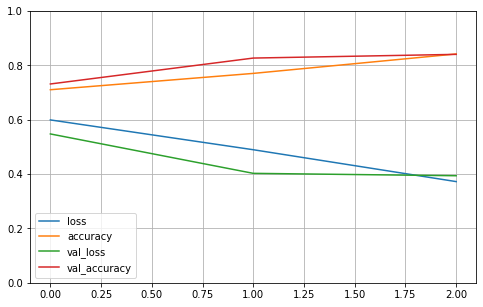

Train set ones/size 3324 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 376 / 514
Range of scores: 0.038940124 to 0.99928623
Score threshold 0.5
Prediction set ones/size 448 / 514


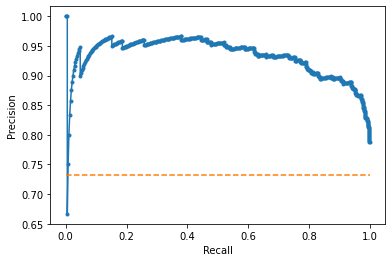

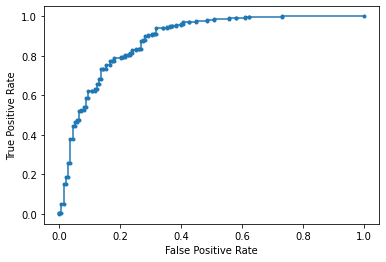

Accuracy: 84.05% Precision: 82.81% Recall: 98.67%
F1: 90.05% AUPRC: 93.24% AUROC: 88.20%
2023-02-14 18:03:03.848117
Fold 8
Discriminator is GMM
Means [-0.8727678232245811, -2.6998928141564114]
Variances [2.46590332 5.00519827]
Priors [0.5943573 0.4056427]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 1]
FIT
2023-02-14 18:03:13.255546
PREDICT
2023-02-14 18:03:24.665291


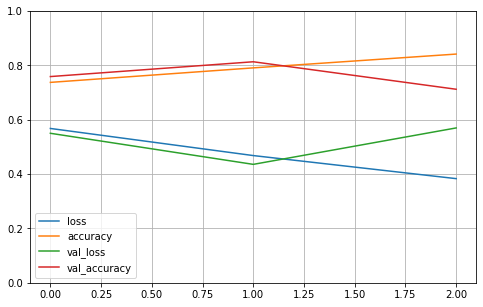

Train set ones/size 3436 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 390 / 514
Range of scores: 0.0027406316 to 0.9968266
Score threshold 0.5
Prediction set ones/size 282 / 514


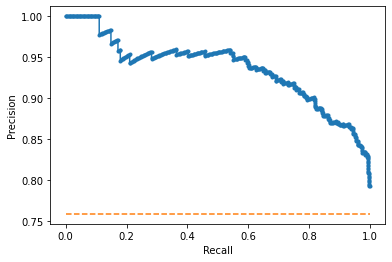

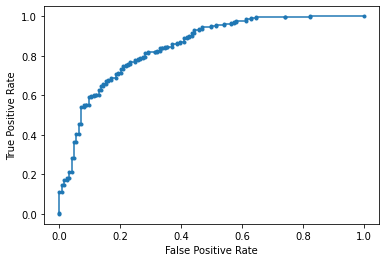

Accuracy: 71.21% Precision: 92.91% Recall: 67.18%
F1: 77.98% AUPRC: 93.61% AUROC: 84.73%
2023-02-14 18:03:25.371543
Fold 9
Discriminator is GMM
Means [-0.9093094825703228, -2.5976254857332632]
Variances [2.47156982 5.2144522 ]
Priors [0.57664629 0.42335371]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 1]
FIT
2023-02-14 18:03:37.620236
PREDICT
2023-02-14 18:03:43.831443


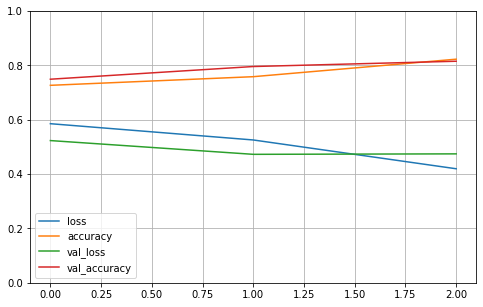

Train set ones/size 3411 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 385 / 514
Range of scores: 0.13240959 to 0.9998216
Score threshold 0.5
Prediction set ones/size 474 / 514


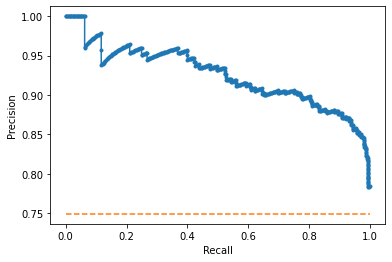

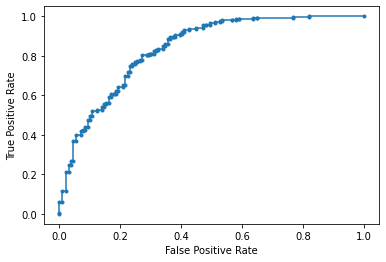

Accuracy: 81.52% Precision: 80.59% Recall: 99.22%
F1: 88.94% AUPRC: 92.53% AUROC: 83.75%
2023-02-14 18:03:44.785123
Fold 10
Discriminator is GMM
Means [-0.8809765988628602, -2.574300745841692]
Variances [2.44883746 5.06163316]
Priors [0.58022305 0.41977695]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 1]
FIT
2023-02-14 18:03:54.716562
PREDICT
2023-02-14 18:04:06.121614


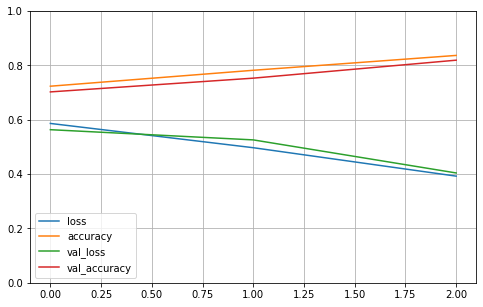

Train set ones/size 3382 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 361 / 514
Range of scores: 0.0106639955 to 0.9981493
Score threshold 0.5
Prediction set ones/size 384 / 514


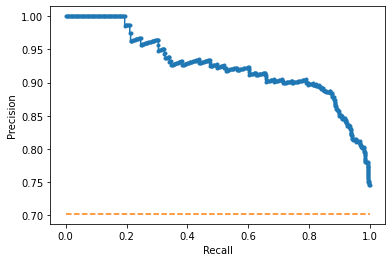

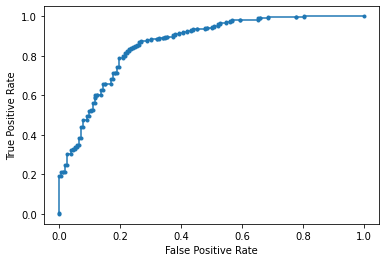

Accuracy: 81.91% Precision: 84.90% Recall: 90.30%
F1: 87.52% AUPRC: 92.64% AUROC: 86.09%
2023-02-14 18:04:06.827162

Completed cross validation 10 folds 3 epochs
 accuracy mean 81.96% +/- 4.14
 precision mean 84.41% +/- 3.91
 recall mean 93.28% +/- 9.63
 F1 mean 88.17% +/- 3.71
 AUPRC mean 94.08% +/- 1.23
 AUROC mean 87.29% +/- 2.25
Finished cell Line 9 SK.MEL.5

2023-02-14 18:04:08.179217
Start cell Line 10 SK.N.DZ
Number of RCI values loaded 603
Num RCI: 603
Load sequence...
Cross validation...
2023-02-14 18:04:18.297933
splitting
Fold 1
Discriminator is GMM
Means [-1.3780494804722898, -0.20798657570726356]
Variances [2.86289699 0.95256807]
Priors [0.35907736 0.64092264]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 1 1 1 1 1 1 1 1]
FIT
2023-02-14 18:04:27.773716
PREDICT
2023-02-14 18:04:34.158087


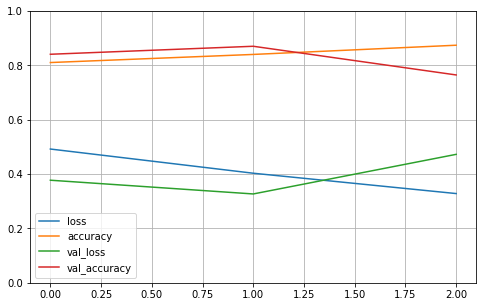

Train set ones/size 4219 / 5194
Compute valiation accuracy
Valid sizes (578, 4997) (578,)
Valid set ones/size 486 / 578
Range of scores: 0.0024633901 to 0.99313945
Score threshold 0.5
Prediction set ones/size 390 / 578


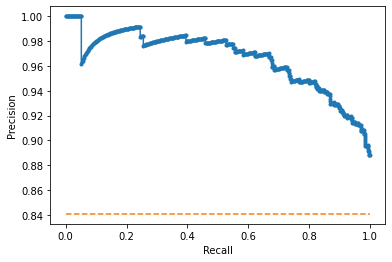

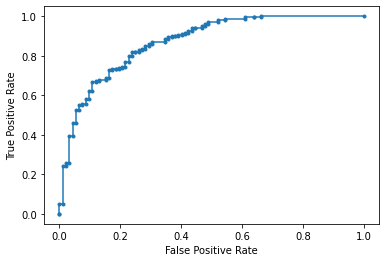

Accuracy: 76.47% Precision: 94.87% Recall: 76.13%
F1: 84.47% AUPRC: 96.63% AUROC: 87.02%
2023-02-14 18:04:34.879748
Fold 2
Discriminator is GMM
Means [-0.20251328746474365, -1.3773249266751202]
Variances [0.96026365 2.88823792]
Priors [0.64855378 0.35144622]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 1 1 1 1 1 1 1 1]
FIT
2023-02-14 18:04:45.850060
PREDICT
2023-02-14 18:04:52.410464


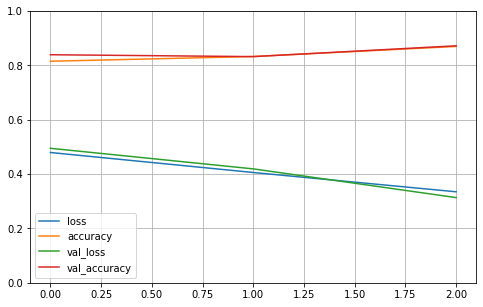

Train set ones/size 4242 / 5194
Compute valiation accuracy
Valid sizes (578, 4997) (578,)
Valid set ones/size 469 / 578
Range of scores: 0.019206667 to 0.9985455
Score threshold 0.5
Prediction set ones/size 495 / 578


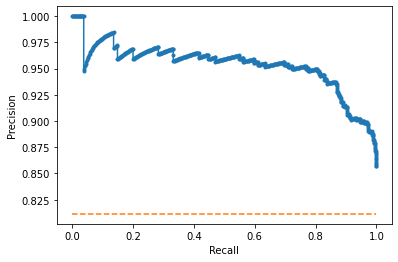

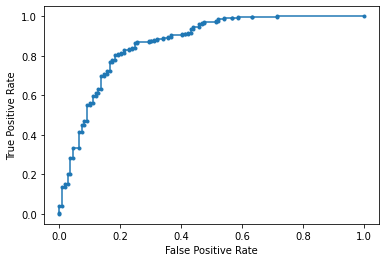

Accuracy: 87.20% Precision: 89.90% Recall: 94.88%
F1: 92.32% AUPRC: 95.37% AUROC: 86.67%
2023-02-14 18:04:53.449223
Fold 3
Discriminator is GMM
Means [-1.7289896502220572, -0.3048978412656558]
Variances [3.35911549 1.10241521]
Priors [0.21730826 0.78269174]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 1]
FIT
2023-02-14 18:05:03.182454
PREDICT
2023-02-14 18:05:10.371067


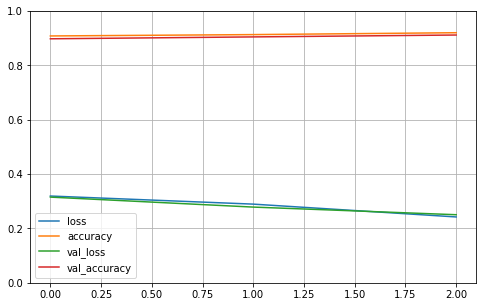

Train set ones/size 4739 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 519 / 577
Range of scores: 0.052352548 to 0.9982724
Score threshold 0.5
Prediction set ones/size 564 / 577


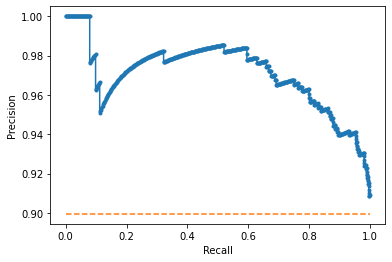

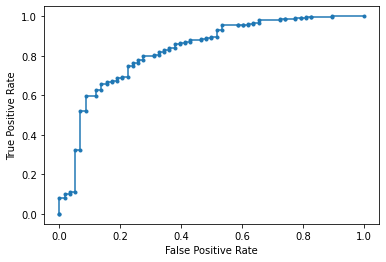

Accuracy: 91.16% Precision: 91.49% Recall: 99.42%
F1: 95.29% AUPRC: 97.06% AUROC: 82.79%
2023-02-14 18:05:11.135362
Fold 4
Discriminator is GMM
Means [-1.3673899111576087, -0.2049435371323067]
Variances [2.83259088 0.9565362 ]
Priors [0.35576662 0.64423338]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 1 1 1 1 1 1 1 1]
FIT
2023-02-14 18:05:22.738044
PREDICT
2023-02-14 18:05:34.188535


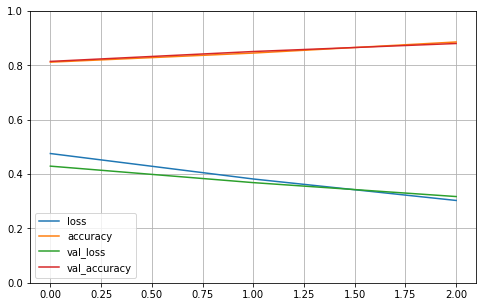

Train set ones/size 4236 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 470 / 577
Range of scores: 0.0061750324 to 0.9996406
Score threshold 0.5
Prediction set ones/size 509 / 577


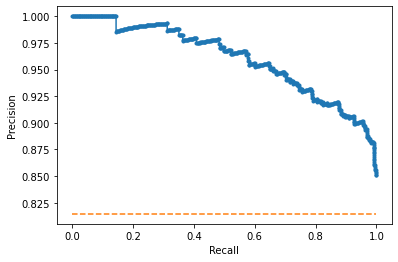

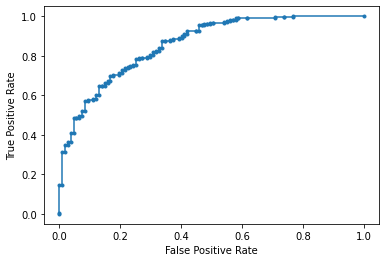

Accuracy: 88.04% Precision: 89.39% Recall: 96.81%
F1: 92.95% AUPRC: 96.03% AUROC: 85.98%
2023-02-14 18:05:34.927828
Fold 5
Discriminator is GMM
Means [-1.3697199436674317, -0.20356080701500912]
Variances [2.97185452 0.9668552 ]
Priors [0.35157409 0.64842591]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 1 1 1 1 1 1 1 1]
FIT
2023-02-14 18:05:43.709156
PREDICT
2023-02-14 18:05:55.631765


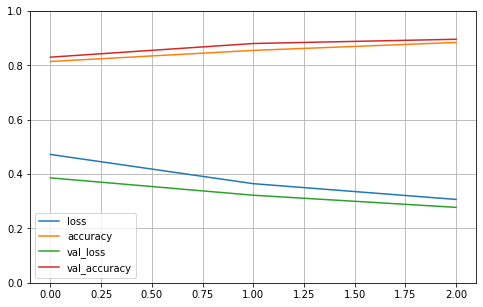

Train set ones/size 4242 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 474 / 577
Range of scores: 0.01583283 to 0.9997205
Score threshold 0.5
Prediction set ones/size 524 / 577


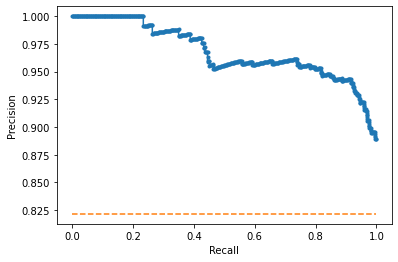

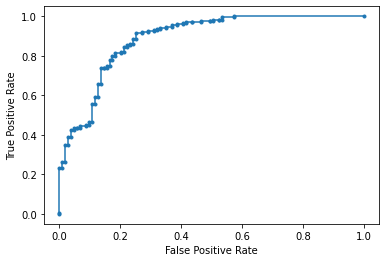

Accuracy: 89.60% Precision: 89.50% Recall: 98.95%
F1: 93.99% AUPRC: 96.81% AUROC: 88.83%
2023-02-14 18:05:56.339117
Fold 6
Discriminator is GMM
Means [-0.19238929790771864, -1.3639523716556508]
Variances [0.95727192 2.82247147]
Priors [0.64182397 0.35817603]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 1 1 1 1 1 1 1 1]
FIT
2023-02-14 18:06:06.312587
PREDICT
2023-02-14 18:06:17.718171


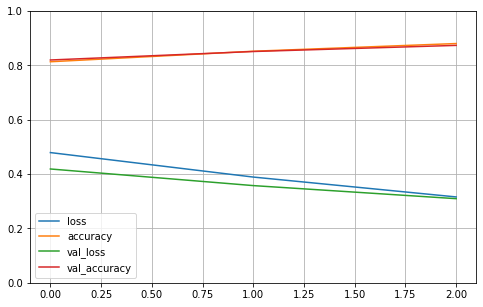

Train set ones/size 4234 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 468 / 577
Range of scores: 0.01595129 to 0.9999006
Score threshold 0.5
Prediction set ones/size 529 / 577


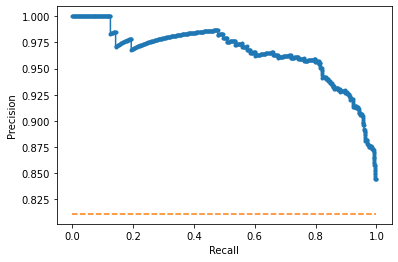

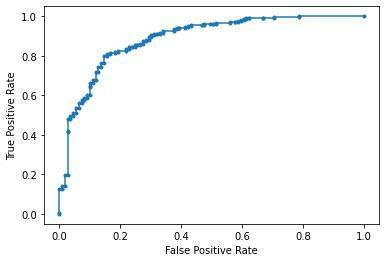

Accuracy: 87.35% Precision: 87.33% Recall: 98.72%
F1: 92.68% AUPRC: 96.56% AUROC: 88.81%
2023-02-14 18:06:18.454679
Fold 7
Discriminator is GMM
Means [-0.31437328328262437, -1.7448436416090267]
Variances [1.09762918 3.49952775]
Priors [0.7844868 0.2155132]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 1]
FIT
2023-02-14 18:06:30.369142
PREDICT
2023-02-14 18:06:36.714796


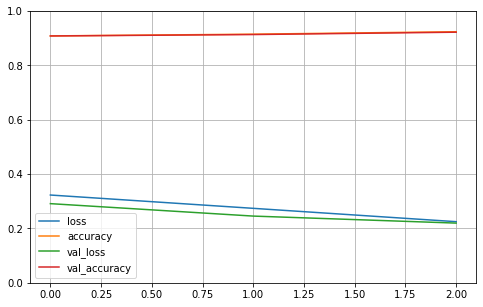

Train set ones/size 4734 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 524 / 577
Range of scores: 0.025036965 to 0.9986518
Score threshold 0.5
Prediction set ones/size 553 / 577


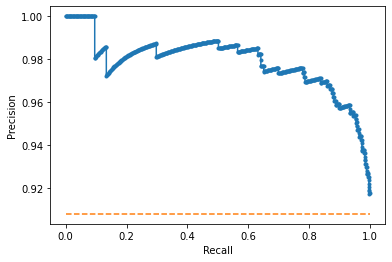

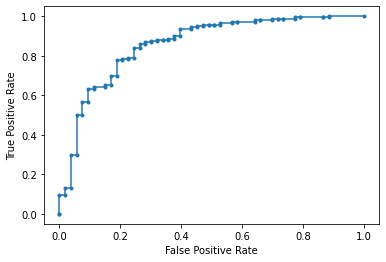

Accuracy: 92.20% Precision: 93.31% Recall: 98.47%
F1: 95.82% AUPRC: 97.88% AUROC: 85.88%
2023-02-14 18:06:37.657058
Fold 8
Discriminator is GMM
Means [-1.7454307523322043, -0.3376327561710812]
Variances [3.50766527 1.11250015]
Priors [0.20513065 0.79486935]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 1]
FIT
2023-02-14 18:06:46.712784
PREDICT
2023-02-14 18:06:58.135891


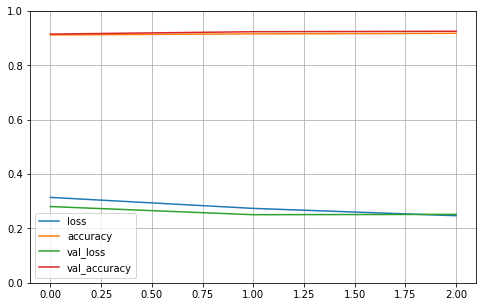

Train set ones/size 4749 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 528 / 577
Range of scores: 0.107131675 to 0.9994653
Score threshold 0.5
Prediction set ones/size 571 / 577


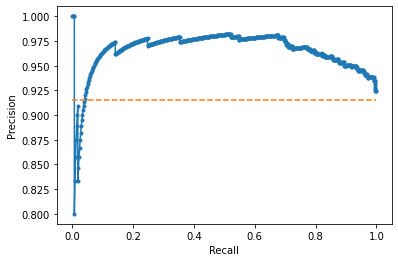

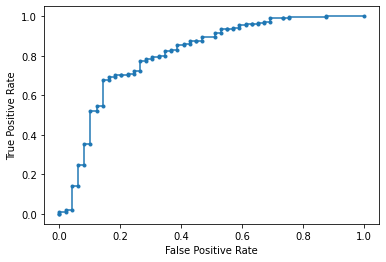

Accuracy: 92.55% Precision: 92.47% Recall: 100.00%
F1: 96.09% AUPRC: 96.53% AUROC: 80.82%
2023-02-14 18:06:58.858825
Fold 9
Discriminator is GMM
Means [-0.31717287203668065, -1.7680407875366349]
Variances [1.1027534  3.29911118]
Priors [0.78618484 0.21381516]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 1]
FIT
2023-02-14 18:07:09.923503
PREDICT
2023-02-14 18:07:16.386180


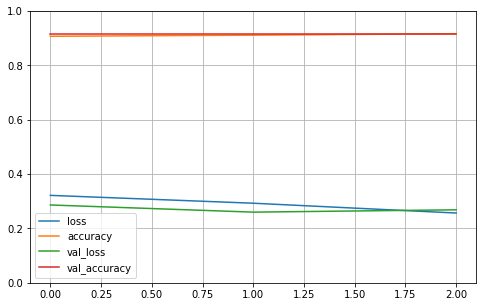

Train set ones/size 4730 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 528 / 577
Range of scores: 0.5168167 to 0.9982697
Score threshold 0.5
Prediction set ones/size 577 / 577


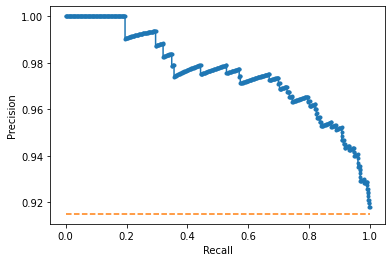

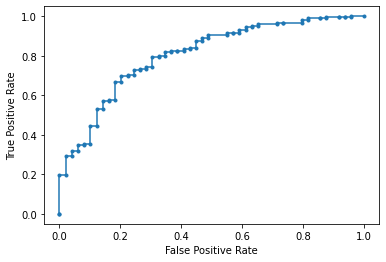

Accuracy: 91.51% Precision: 91.51% Recall: 100.00%
F1: 95.57% AUPRC: 97.58% AUROC: 80.56%
2023-02-14 18:07:17.155669
Fold 10
Discriminator is GMM
Means [-0.18867654839718392, -1.3658542614412719]
Variances [0.9619451  2.82405946]
Priors [0.63951767 0.36048233]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 1 1 1 1 1 1 1 1]
FIT
2023-02-14 18:07:27.167119
PREDICT
2023-02-14 18:07:34.198057


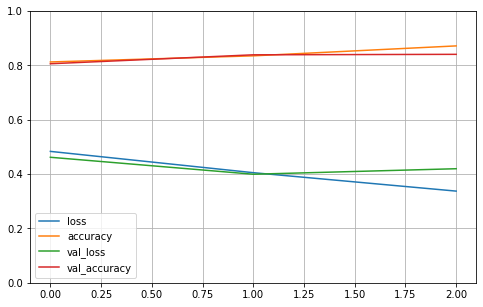

Train set ones/size 4237 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 465 / 577
Range of scores: 0.020582536 to 0.99963725
Score threshold 0.5
Prediction set ones/size 555 / 577


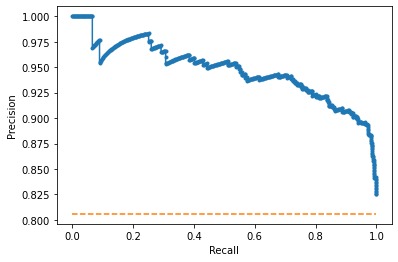

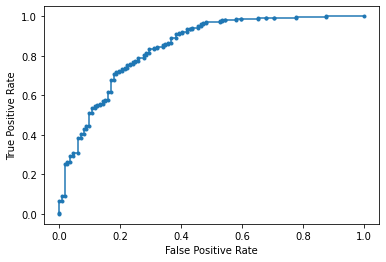

Accuracy: 84.06% Precision: 83.60% Recall: 99.78%
F1: 90.98% AUPRC: 94.72% AUROC: 84.47%
2023-02-14 18:07:34.948186

Completed cross validation 10 folds 3 epochs
 accuracy mean 88.01% +/- 4.86
 precision mean 90.34% +/- 3.21
 recall mean 96.32% +/- 7.27
 F1 mean 93.02% +/- 3.46
 AUPRC mean 96.52% +/- 0.95
 AUROC mean 85.18% +/- 2.98
Finished cell Line 10 SK.N.DZ

2023-02-14 18:07:36.314700
Start cell Line 11 SK.N.SH
Number of RCI values loaded 1647
Num RCI: 1647
Load sequence...
Cross validation...
2023-02-14 18:07:52.403958
splitting
Fold 1
Discriminator is GMM
Means [-0.14902811011627715, -1.8696234096133213]
Variances [2.04651175 3.5296541 ]
Priors [0.527194 0.472806]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 18:08:03.904621
PREDICT
2023-02-14 18:08:14.771611


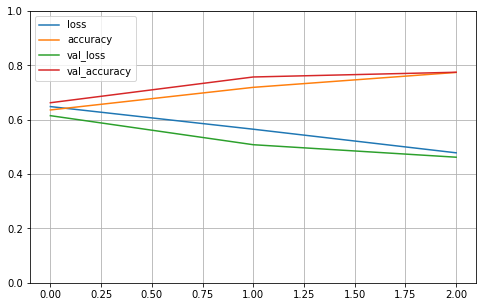

Train set ones/size 5733 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 651 / 1034
Range of scores: 0.008751438 to 0.98707485
Score threshold 0.5
Prediction set ones/size 708 / 1034


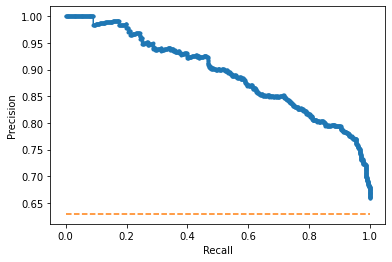

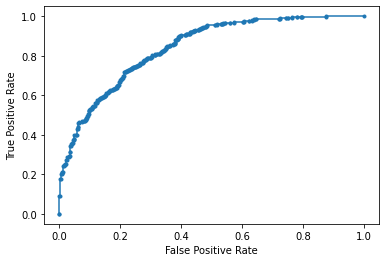

Accuracy: 77.47% Precision: 79.52% Recall: 86.48%
F1: 82.86% AUPRC: 89.30% AUROC: 84.13%
2023-02-14 18:08:15.632750
Fold 2
Discriminator is GMM
Means [-0.12927008134084048, -1.885496528526627]
Variances [2.02133828 3.50875355]
Priors [0.5275142 0.4724858]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 18:08:27.929977
PREDICT
2023-02-14 18:08:39.646139


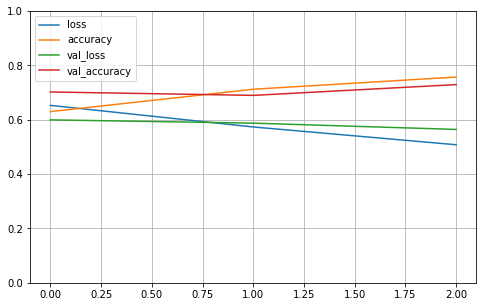

Train set ones/size 5743 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 635 / 1034
Range of scores: 0.038431916 to 0.9975961
Score threshold 0.5
Prediction set ones/size 861 / 1034


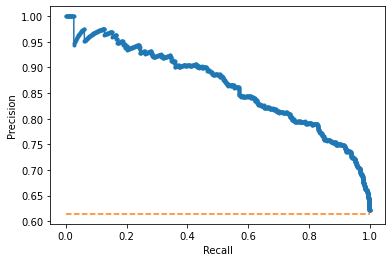

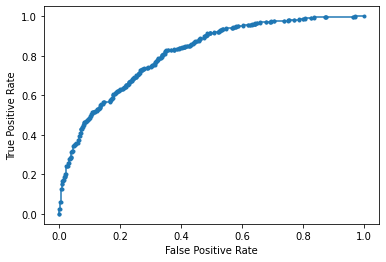

Accuracy: 72.92% Precision: 70.62% Recall: 95.75%
F1: 81.28% AUPRC: 86.46% AUROC: 81.29%
2023-02-14 18:08:40.585270
Fold 3
Discriminator is GMM
Means [-1.8706505909230537, -0.1341875122002632]
Variances [3.40668873 2.03339821]
Priors [0.47681317 0.52318683]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 18:08:50.221713
PREDICT
2023-02-14 18:09:01.222516


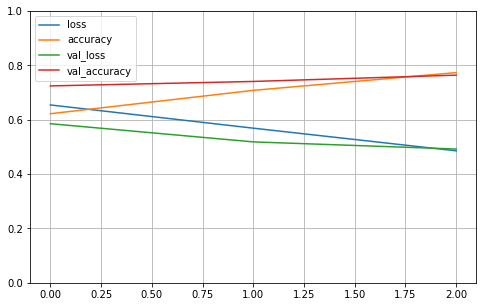

Train set ones/size 5585 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 648 / 1034
Range of scores: 0.0043752706 to 0.99630153
Score threshold 0.5
Prediction set ones/size 656 / 1034


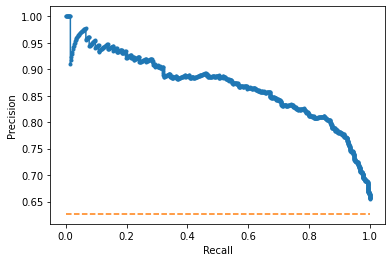

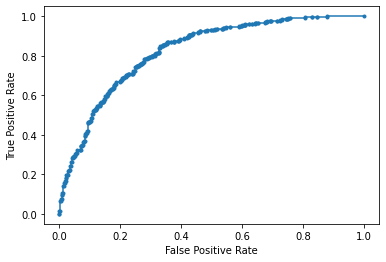

Accuracy: 76.40% Precision: 80.79% Recall: 81.79%
F1: 81.29% AUPRC: 86.88% AUROC: 82.46%
2023-02-14 18:09:02.173189
Fold 4
Discriminator is GMM
Means [-1.8906622365265628, -0.107729934286241]
Variances [3.44070245 2.01924862]
Priors [0.47700137 0.52299863]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 18:09:13.147737
PREDICT
2023-02-14 18:09:24.076504


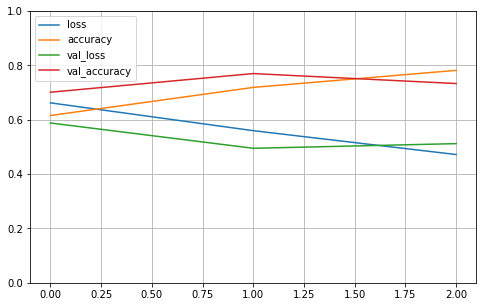

Train set ones/size 5569 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 622 / 1034
Range of scores: 0.002743062 to 0.99542207
Score threshold 0.5
Prediction set ones/size 482 / 1034


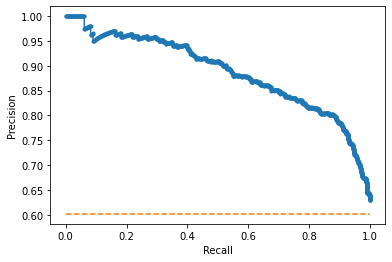

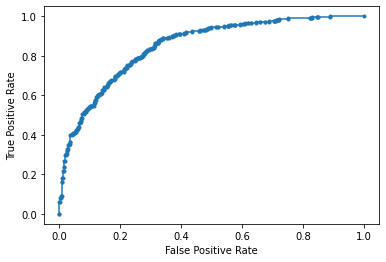

Accuracy: 73.31% Precision: 85.89% Recall: 66.56%
F1: 75.00% AUPRC: 88.77% AUROC: 85.06%
2023-02-14 18:09:25.228566
Fold 5
Discriminator is GMM
Means [-0.11217821560225139, -1.8986756496154122]
Variances [2.01126574 3.39947006]
Priors [0.52383727 0.47616273]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 18:09:38.808207
PREDICT
2023-02-14 18:09:49.462600


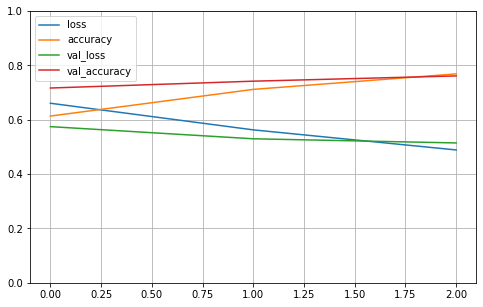

Train set ones/size 5576 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 637 / 1034
Range of scores: 0.015187124 to 0.99671435
Score threshold 0.5
Prediction set ones/size 822 / 1034


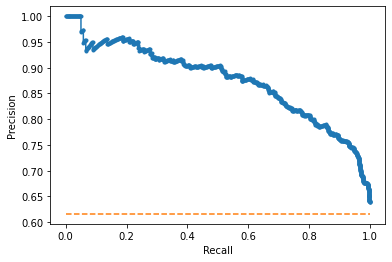

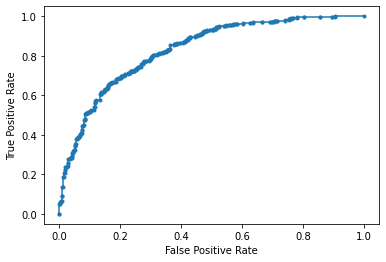

Accuracy: 76.11% Precision: 73.72% Recall: 95.13%
F1: 83.07% AUPRC: 87.55% AUROC: 83.10%
2023-02-14 18:09:50.283177
Fold 6
Discriminator is GMM
Means [-1.8781803738144935, -0.13721065522233078]
Variances [3.54324099 2.04536644]
Priors [0.47232334 0.52767666]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 18:10:03.080762
PREDICT
2023-02-14 18:10:13.665791


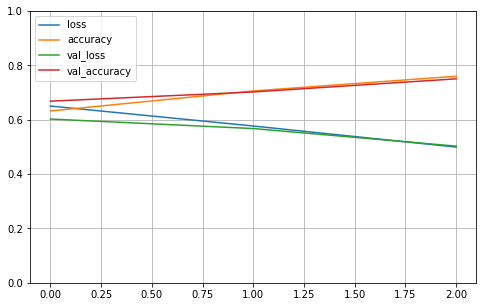

Train set ones/size 5738 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 644 / 1034
Range of scores: 0.0041316818 to 0.9953033
Score threshold 0.5
Prediction set ones/size 806 / 1034


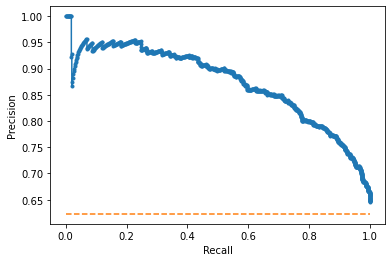

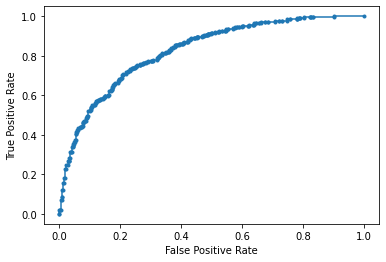

Accuracy: 75.05% Precision: 73.95% Recall: 92.55%
F1: 82.21% AUPRC: 87.38% AUROC: 82.55%
2023-02-14 18:10:14.635098
Fold 7
Discriminator is GMM
Means [-0.1490592309752341, -1.8833316495472503]
Variances [2.02063769 3.58660404]
Priors [0.53234316 0.46765684]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 18:10:29.240695
PREDICT
2023-02-14 18:10:40.909642


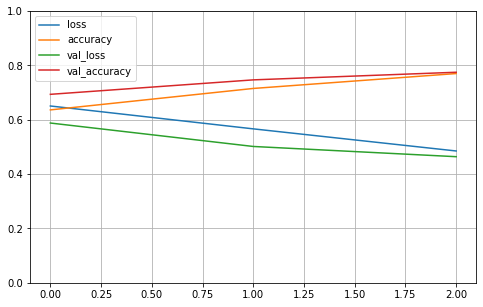

Train set ones/size 5806 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 643 / 1034
Range of scores: 0.0018618876 to 0.99600464
Score threshold 0.5
Prediction set ones/size 668 / 1034


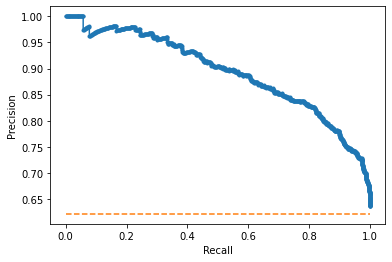

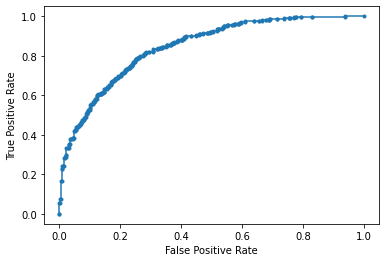

Accuracy: 77.47% Precision: 80.69% Recall: 83.83%
F1: 82.23% AUPRC: 89.35% AUROC: 84.47%
2023-02-14 18:10:41.725936
Fold 8
Discriminator is GMM
Means [-0.1348705306810379, -1.8582210351063535]
Variances [2.06451506 3.51624058]
Priors [0.53036765 0.46963235]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 18:10:55.149801
PREDICT
2023-02-14 18:11:05.679699


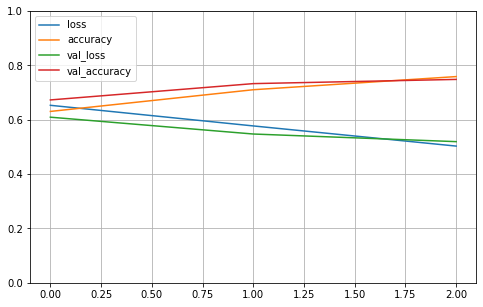

Train set ones/size 5768 / 9304
Compute valiation accuracy
Valid sizes (1033, 4997) (1033,)
Valid set ones/size 616 / 1033
Range of scores: 0.005406484 to 0.9867027
Score threshold 0.5
Prediction set ones/size 676 / 1033


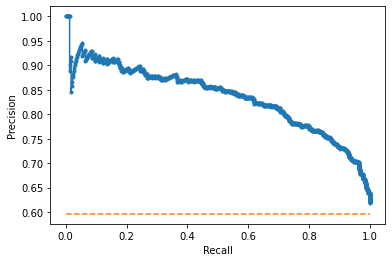

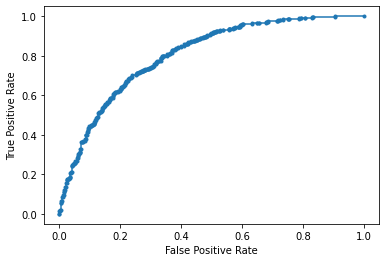

Accuracy: 74.83% Precision: 76.33% Recall: 83.77%
F1: 79.88% AUPRC: 83.54% AUROC: 80.49%
2023-02-14 18:11:06.831963
Fold 9
Discriminator is GMM
Means [-1.8728709815195013, -0.15062977396549931]
Variances [3.54221156 2.05210281]
Priors [0.47016754 0.52983246]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 18:11:21.507412
PREDICT
2023-02-14 18:11:31.820978


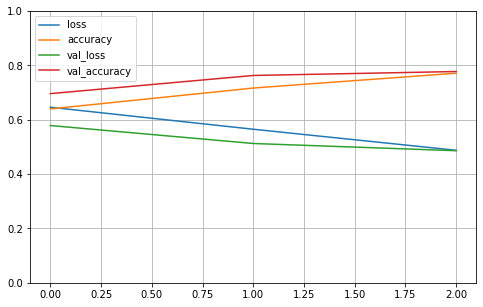

Train set ones/size 5790 / 9304
Compute valiation accuracy
Valid sizes (1033, 4997) (1033,)
Valid set ones/size 642 / 1033
Range of scores: 0.0081995735 to 0.995739
Score threshold 0.5
Prediction set ones/size 662 / 1033


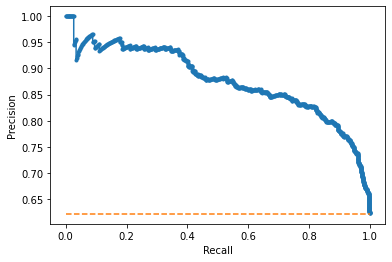

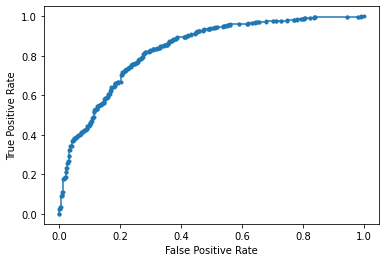

Accuracy: 77.73% Precision: 81.12% Recall: 83.64%
F1: 82.36% AUPRC: 87.68% AUROC: 83.38%
2023-02-14 18:11:32.993610
Fold 10
Discriminator is GMM
Means [-1.8819534036568908, -0.1121265035573502]
Variances [3.48165147 2.05239855]
Priors [0.46958581 0.53041419]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 18:11:48.582215
PREDICT
2023-02-14 18:11:59.080623


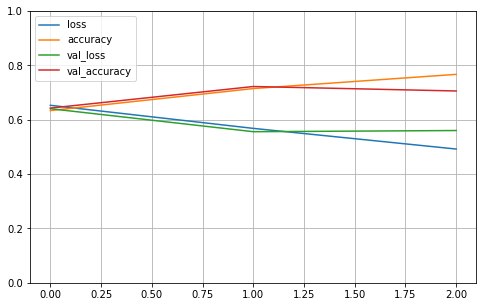

Train set ones/size 5758 / 9304
Compute valiation accuracy
Valid sizes (1033, 4997) (1033,)
Valid set ones/size 611 / 1033
Range of scores: 0.0017067362 to 0.98136353
Score threshold 0.5
Prediction set ones/size 565 / 1033


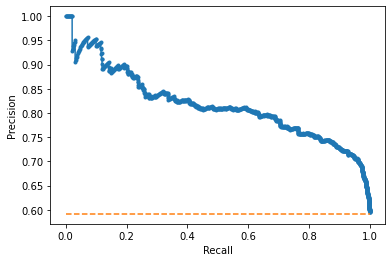

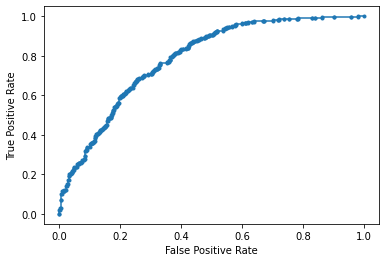

Accuracy: 70.57% Precision: 77.17% Recall: 71.36%
F1: 74.15% AUPRC: 81.67% AUROC: 78.58%
2023-02-14 18:12:00.305025

Completed cross validation 10 folds 3 epochs
 accuracy mean 75.19% +/- 2.34
 precision mean 77.98% +/- 4.50
 recall mean 84.09% +/- 9.49
 F1 mean 80.43% +/- 3.23
 AUPRC mean 86.86% +/- 2.48
 AUROC mean 82.55% +/- 1.97
Finished cell Line 11 SK.N.SH

2023-02-14 18:12:01.892580
Start cell Line 12 GM12878
Number of RCI values loaded 1698
Num RCI: 1698
Load sequence...
Cross validation...
2023-02-14 18:12:17.209905
splitting
Fold 1
Discriminator is GMM
Means [-0.18942134613772726, -1.3484291370750294]
Variances [1.12133559 2.09195047]
Priors [0.48029732 0.51970268]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 18:12:27.894833
PREDICT
2023-02-14 18:12:39.528553


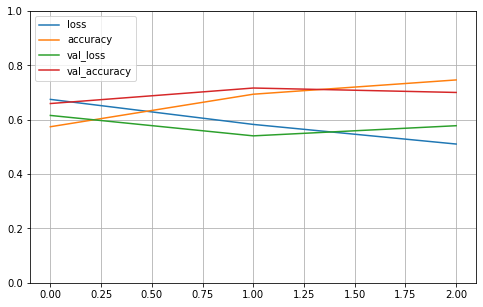

Train set ones/size 4815 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 549 / 981
Range of scores: 0.0053220736 to 0.9880305
Score threshold 0.5
Prediction set ones/size 345 / 981


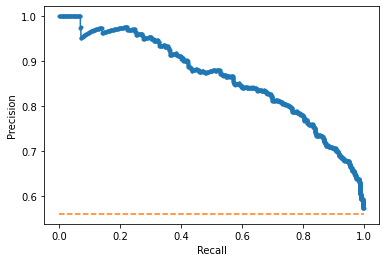

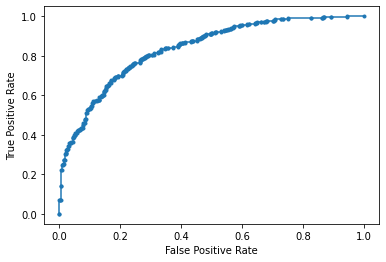

Accuracy: 70.03% Precision: 86.96% Recall: 54.64%
F1: 67.11% AUPRC: 86.37% AUROC: 83.52%
2023-02-14 18:12:40.403954
Fold 2
Discriminator is GMM
Means [-0.14051284192082578, -1.3700720812650706]
Variances [1.06475644 1.97949853]
Priors [0.47599372 0.52400628]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 18:12:49.221317
PREDICT
2023-02-14 18:13:01.188837


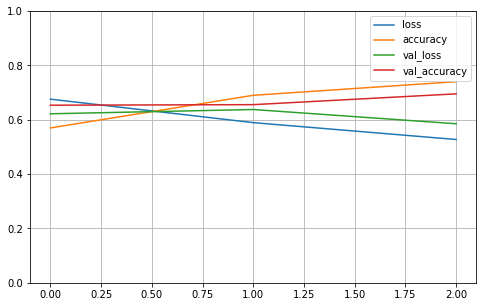

Train set ones/size 4742 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 520 / 981
Range of scores: 0.0057504065 to 0.9912703
Score threshold 0.5
Prediction set ones/size 375 / 981


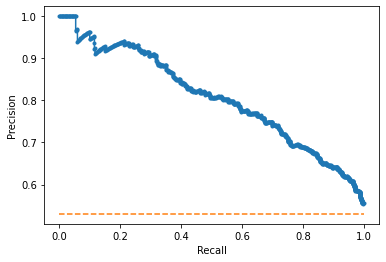

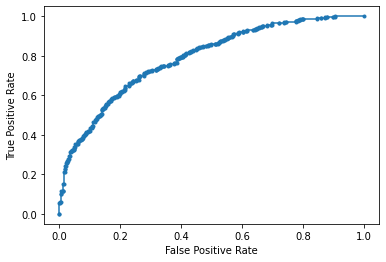

Accuracy: 69.52% Precision: 79.47% Recall: 57.31%
F1: 66.59% AUPRC: 80.81% AUROC: 78.87%
2023-02-14 18:13:01.985487
Fold 3
Discriminator is GMM
Means [-1.339509031347003, -0.2050173516343585]
Variances [2.13507402 1.11720447]
Priors [0.51849239 0.48150761]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 18:13:17.194548
PREDICT
2023-02-14 18:13:27.766483


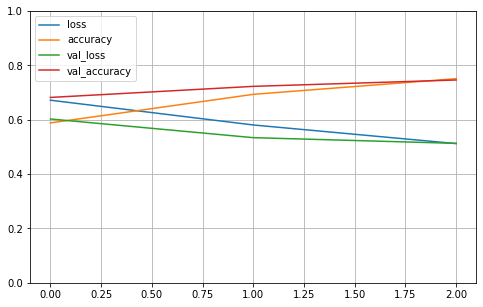

Train set ones/size 4889 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 566 / 981
Range of scores: 0.0067055114 to 0.99305916
Score threshold 0.5
Prediction set ones/size 445 / 981


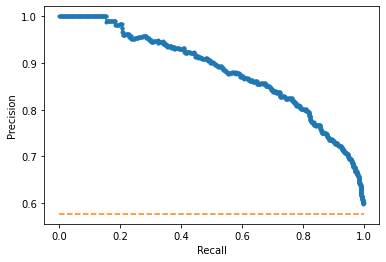

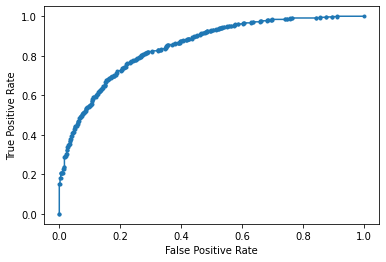

Accuracy: 74.62% Precision: 85.62% Recall: 67.31%
F1: 75.37% AUPRC: 88.28% AUROC: 84.80%
2023-02-14 18:13:28.542185
Fold 4
Discriminator is GMM
Means [-1.33098702872469, -0.1918376579599457]
Variances [2.13396612 1.11226183]
Priors [0.51525083 0.48474917]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 18:13:39.398586
PREDICT
2023-02-14 18:13:49.687751


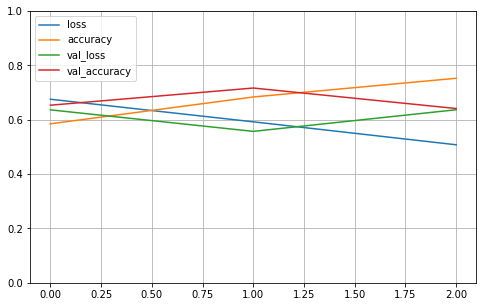

Train set ones/size 4929 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 526 / 981
Range of scores: 0.0037791347 to 0.98198366
Score threshold 0.5
Prediction set ones/size 268 / 981


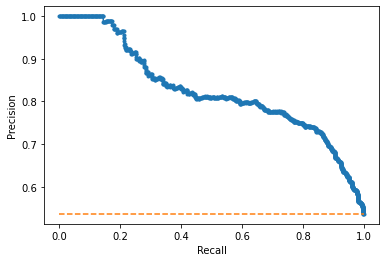

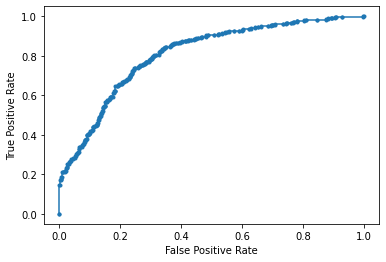

Accuracy: 64.12% Precision: 82.46% Recall: 42.02%
F1: 55.67% AUPRC: 82.58% AUROC: 80.85%
2023-02-14 18:13:50.484367
Fold 5
Discriminator is GMM
Means [-0.13551047255703189, -1.3701127499161077]
Variances [1.08128899 2.00155891]
Priors [0.47429286 0.52570714]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 18:14:04.435622
PREDICT
2023-02-14 18:14:16.089623


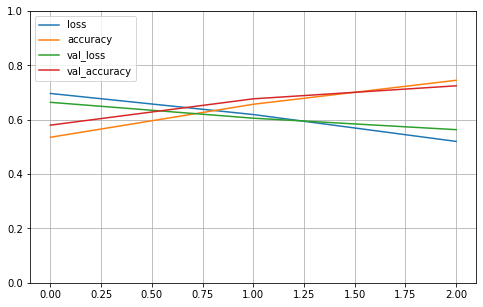

Train set ones/size 4720 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 525 / 981
Range of scores: 0.011187728 to 0.9957241
Score threshold 0.5
Prediction set ones/size 489 / 981


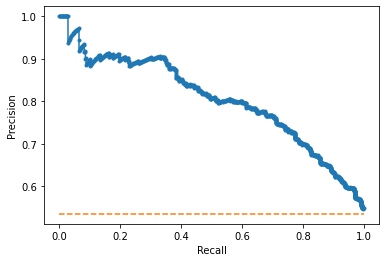

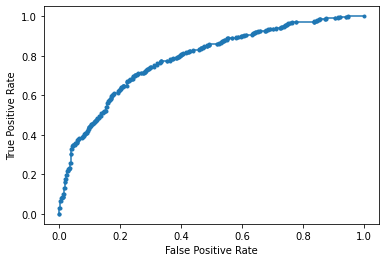

Accuracy: 72.48% Precision: 76.07% Recall: 70.86%
F1: 73.37% AUPRC: 80.44% AUROC: 78.59%
2023-02-14 18:14:17.028685
Fold 6
Discriminator is GMM
Means [-0.19534434823331226, -1.3430302866774997]
Variances [1.10756117 2.110244  ]
Priors [0.48014279 0.51985721]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 18:14:30.134200
PREDICT
2023-02-14 18:14:40.343224


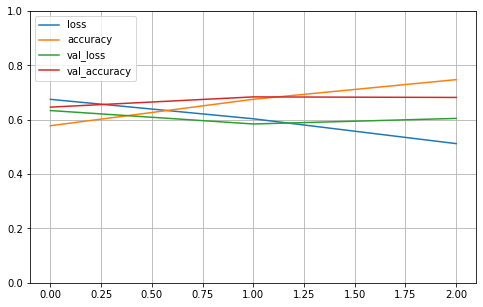

Train set ones/size 4814 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 550 / 981
Range of scores: 0.0053861407 to 0.98831034
Score threshold 0.5
Prediction set ones/size 334 / 981


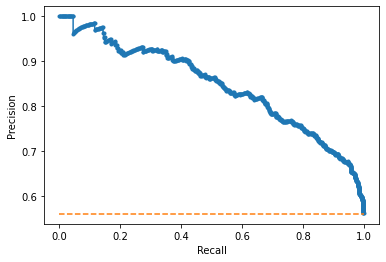

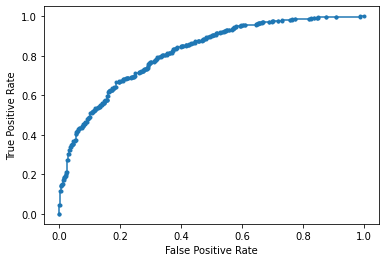

Accuracy: 68.20% Precision: 85.63% Recall: 52.00%
F1: 64.71% AUPRC: 84.68% AUROC: 81.77%
2023-02-14 18:14:41.314922
Fold 7
Discriminator is GMM
Means [-1.3253632401546724, -0.2062175718907498]
Variances [2.15918817 1.11568062]
Priors [0.51456812 0.48543188]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 18:14:50.587688
PREDICT
2023-02-14 18:15:01.046851


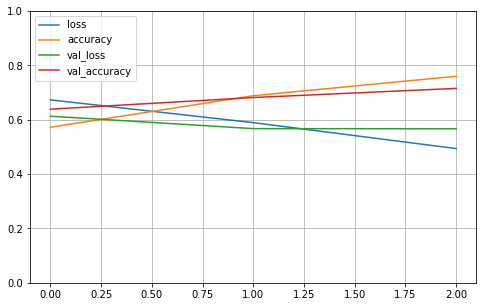

Train set ones/size 4963 / 8826
Compute valiation accuracy
Valid sizes (980, 4997) (980,)
Valid set ones/size 537 / 980
Range of scores: 0.024436444 to 0.99866664
Score threshold 0.5
Prediction set ones/size 728 / 980


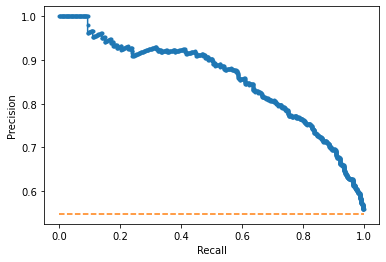

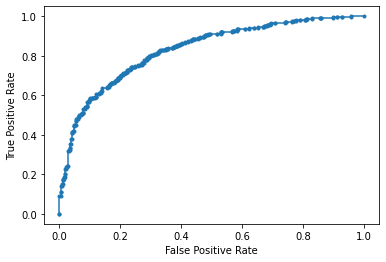

Accuracy: 71.53% Precision: 67.72% Recall: 91.81%
F1: 77.94% AUPRC: 85.58% AUROC: 83.09%
2023-02-14 18:15:01.994436
Fold 8
Discriminator is GMM
Means [-1.3595045590609467, -0.12068879152700472]
Variances [1.98560728 1.06009752]
Priors [0.52685364 0.47314636]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 18:15:19.878020
PREDICT
2023-02-14 18:15:31.604440


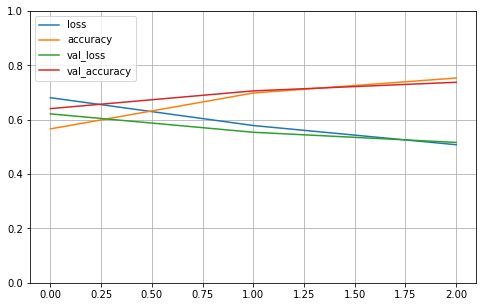

Train set ones/size 4697 / 8826
Compute valiation accuracy
Valid sizes (980, 4997) (980,)
Valid set ones/size 485 / 980
Range of scores: 0.009242098 to 0.99317616
Score threshold 0.5
Prediction set ones/size 434 / 980


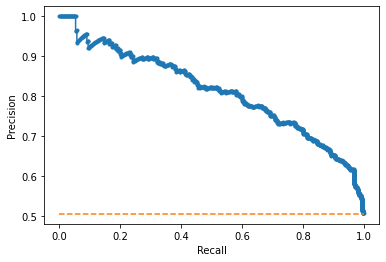

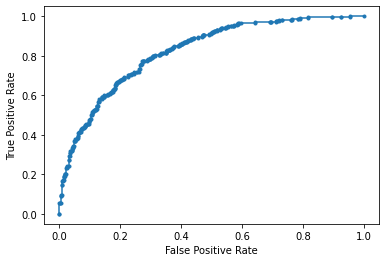

Accuracy: 73.78% Precision: 76.27% Recall: 68.25%
F1: 72.03% AUPRC: 81.26% AUROC: 82.40%
2023-02-14 18:15:32.788916
Fold 9
Discriminator is GMM
Means [-0.18797028862072876, -1.3435299444410205]
Variances [1.10627182 2.07965118]
Priors [0.47988553 0.52011447]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 18:15:42.457344
PREDICT
2023-02-14 18:15:52.999343


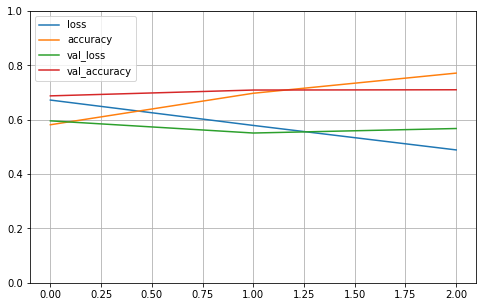

Train set ones/size 4822 / 8826
Compute valiation accuracy
Valid sizes (980, 4997) (980,)
Valid set ones/size 542 / 980
Range of scores: 0.023366775 to 0.99885523
Score threshold 0.5
Prediction set ones/size 738 / 980


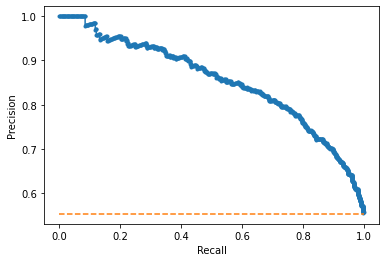

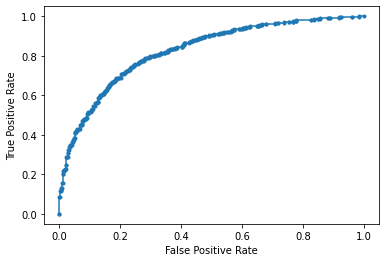

Accuracy: 71.02% Precision: 67.48% Recall: 91.88%
F1: 77.81% AUPRC: 85.37% AUROC: 82.56%
2023-02-14 18:15:53.788342
Fold 10
Discriminator is GMM
Means [-0.18870565215403454, -1.3504389118388316]
Variances [1.08710576 2.07858821]
Priors [0.48136759 0.51863241]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 0 1 1 1 1 1 1]
FIT
2023-02-14 18:16:09.264334
PREDICT
2023-02-14 18:16:19.770460


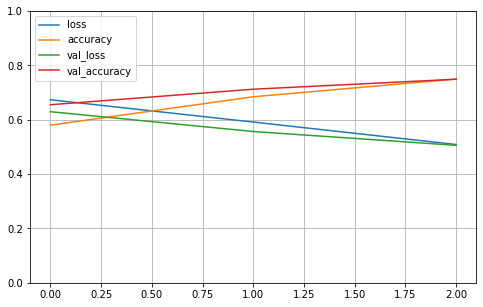

Train set ones/size 4815 / 8826
Compute valiation accuracy
Valid sizes (980, 4997) (980,)
Valid set ones/size 549 / 980
Range of scores: 0.041010644 to 0.99526155
Score threshold 0.5
Prediction set ones/size 689 / 980


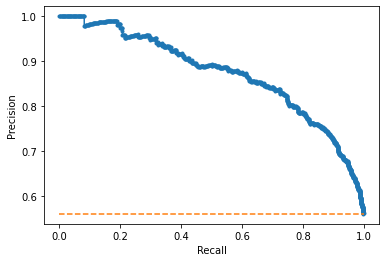

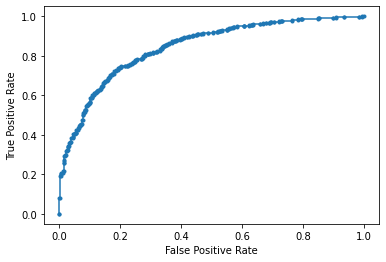

Accuracy: 74.90% Precision: 71.99% Recall: 90.35%
F1: 80.13% AUPRC: 87.36% AUROC: 84.40%
2023-02-14 18:16:20.713110

Completed cross validation 10 folds 3 epochs
 accuracy mean 71.02% +/- 3.28
 precision mean 77.97% +/- 7.29
 recall mean 68.64% +/- 17.84
 F1 mean 71.07% +/- 7.55
 AUPRC mean 84.27% +/- 2.82
 AUROC mean 82.09% +/- 2.12
Finished cell Line 12 GM12878

2023-02-14 18:16:22.168869
Start cell Line 13 K562
Number of RCI values loaded 958
Num RCI: 958
Load sequence...
Cross validation...
2023-02-14 18:16:32.611015
splitting
Fold 1
Discriminator is GMM
Means [-1.8705719961699516, 0.022700068524982586]
Variances [1.43805354 0.96117527]
Priors [0.3665658 0.6334342]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 18:16:41.417006
PREDICT
2023-02-14 18:16:52.882125


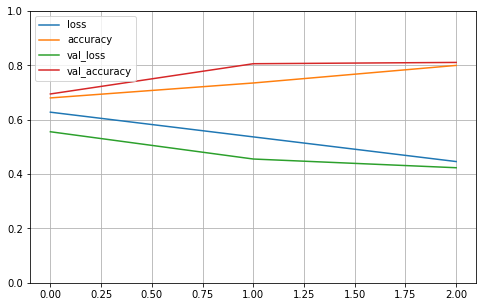

Train set ones/size 3903 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 435 / 629
Range of scores: 0.015484527 to 0.9956405
Score threshold 0.5
Prediction set ones/size 486 / 629


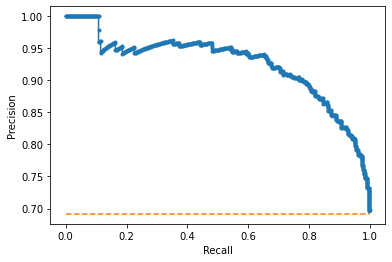

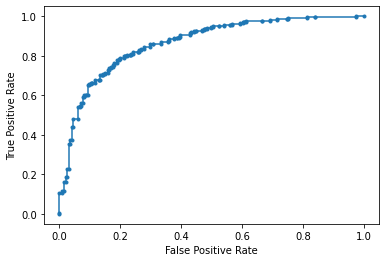

Accuracy: 81.08% Precision: 82.51% Recall: 92.18%
F1: 87.08% AUPRC: 92.57% AUROC: 86.48%
2023-02-14 18:16:53.754624
Fold 2
Discriminator is GMM
Means [0.018925167607310226, -1.8734661654273457]
Variances [0.95098259 1.39925796]
Priors [0.63395017 0.36604983]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 18:17:02.378949
PREDICT
2023-02-14 18:17:10.094715


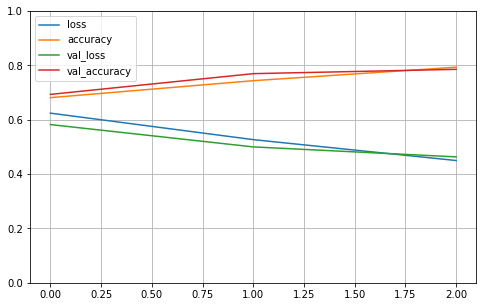

Train set ones/size 3865 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 426 / 629
Range of scores: 0.010127443 to 0.996229
Score threshold 0.5
Prediction set ones/size 519 / 629


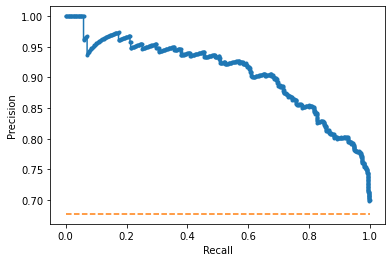

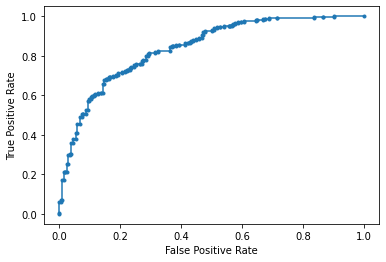

Accuracy: 78.54% Precision: 78.03% Recall: 95.07%
F1: 85.71% AUPRC: 90.74% AUROC: 84.06%
2023-02-14 18:17:10.839380
Fold 3
Discriminator is GMM
Means [-0.0007917887850957651, -1.869835836317349]
Variances [0.95934147 1.47017722]
Priors [0.63741249 0.36258751]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 18:17:21.050531
PREDICT
2023-02-14 18:17:32.507835


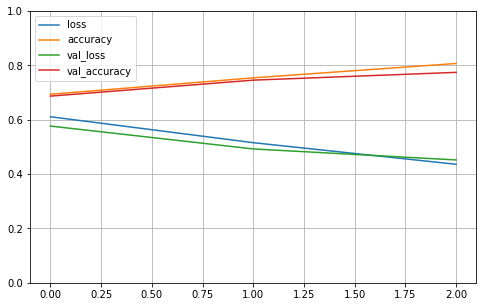

Train set ones/size 3948 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 427 / 629
Range of scores: 0.0062144096 to 0.9961661
Score threshold 0.5
Prediction set ones/size 443 / 629


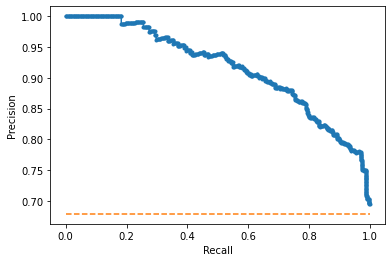

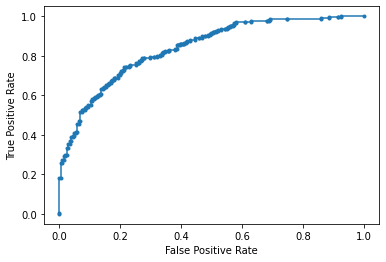

Accuracy: 77.42% Precision: 82.17% Recall: 85.25%
F1: 83.68% AUPRC: 91.61% AUROC: 84.02%
2023-02-14 18:17:33.234594
Fold 4
Discriminator is GMM
Means [0.01808619698618589, -1.8884694186334257]
Variances [0.95004075 1.42097589]
Priors [0.62985983 0.37014017]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 18:17:45.331056
PREDICT
2023-02-14 18:17:56.812888


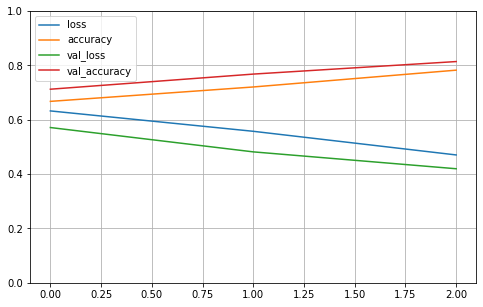

Train set ones/size 3840 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 446 / 629
Range of scores: 0.0038945116 to 0.99782336
Score threshold 0.5
Prediction set ones/size 481 / 629


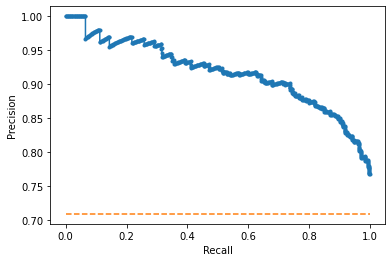

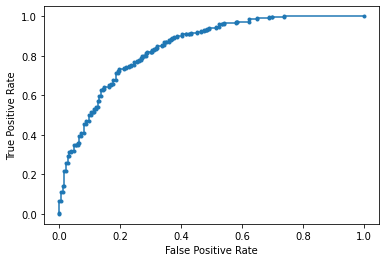

Accuracy: 81.40% Precision: 84.20% Recall: 90.81%
F1: 87.38% AUPRC: 91.75% AUROC: 84.39%
2023-02-14 18:17:57.879169
Fold 5
Discriminator is GMM
Means [-1.8696552395100638, 0.020897201438004866]
Variances [1.42054283 0.95594656]
Priors [0.36528321 0.63471679]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 18:18:06.194831
PREDICT
2023-02-14 18:18:13.565054


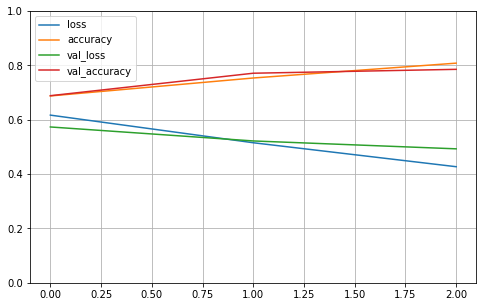

Train set ones/size 3914 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 424 / 629
Range of scores: 0.0167372 to 0.9987949
Score threshold 0.5
Prediction set ones/size 505 / 629


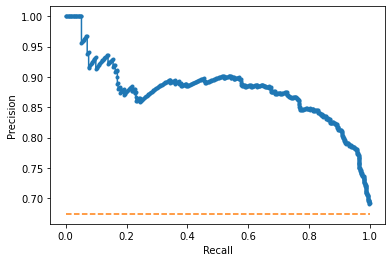

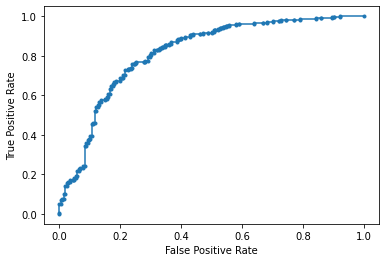

Accuracy: 78.54% Precision: 78.61% Recall: 93.63%
F1: 85.47% AUPRC: 87.75% AUROC: 81.61%
2023-02-14 18:18:14.289332
Fold 6
Discriminator is GMM
Means [0.015332027372657086, -1.8680817457931922]
Variances [0.95569803 1.41459089]
Priors [0.63325336 0.36674664]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 18:18:23.703783
PREDICT
2023-02-14 18:18:31.011491


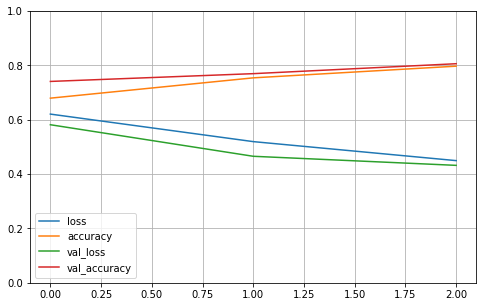

Train set ones/size 3908 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 430 / 629
Range of scores: 0.0053051976 to 0.9967726
Score threshold 0.5
Prediction set ones/size 454 / 629


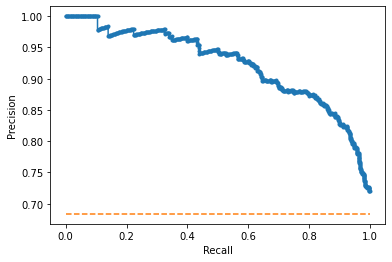

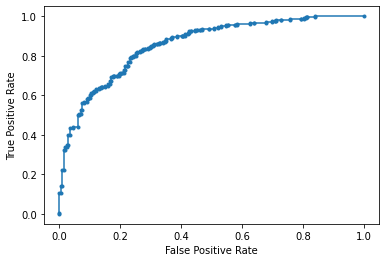

Accuracy: 80.60% Precision: 83.92% Recall: 88.60%
F1: 86.20% AUPRC: 92.34% AUROC: 85.67%
2023-02-14 18:18:31.738342
Fold 7
Discriminator is GMM
Means [0.017990524750880484, -1.8885102430825826]
Variances [0.93525143 1.36958272]
Priors [0.63519173 0.36480827]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 18:18:42.219674
PREDICT
2023-02-14 18:18:53.669658


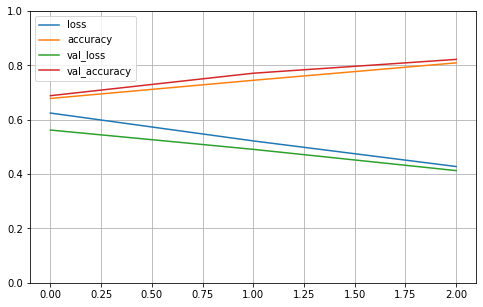

Train set ones/size 3865 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 426 / 629
Range of scores: 0.013543802 to 0.99827015
Score threshold 0.5
Prediction set ones/size 490 / 629


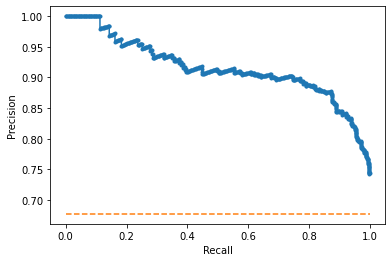

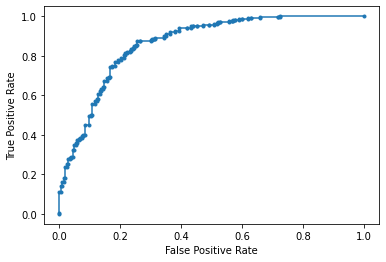

Accuracy: 82.19% Precision: 82.04% Recall: 94.37%
F1: 87.77% AUPRC: 91.56% AUROC: 86.35%
2023-02-14 18:18:54.397700
Fold 8
Discriminator is GMM
Means [0.010643541082706662, -1.875369863257007]
Variances [0.95542845 1.42223811]
Priors [0.63336259 0.36663741]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 18:19:05.281185
PREDICT
2023-02-14 18:19:16.724168


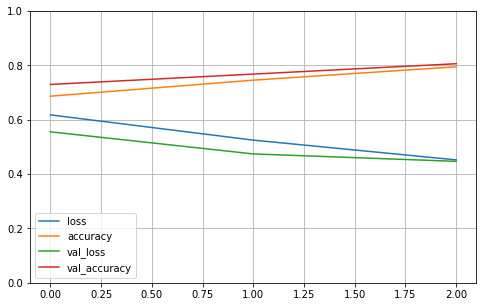

Train set ones/size 3898 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 440 / 629
Range of scores: 0.02251427 to 0.99854726
Score threshold 0.5
Prediction set ones/size 516 / 629


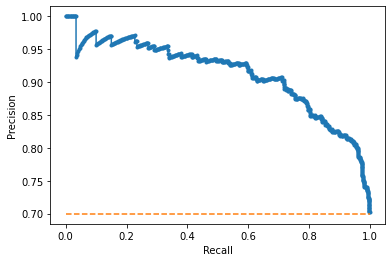

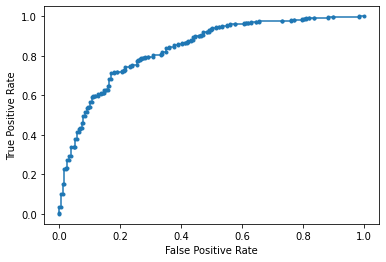

Accuracy: 80.60% Precision: 80.81% Recall: 94.77%
F1: 87.24% AUPRC: 91.24% AUROC: 83.63%
2023-02-14 18:19:17.437664
Fold 9
Discriminator is GMM
Means [-1.8853482723474304, 0.010178866594345401]
Variances [1.40242573 0.95011502]
Priors [0.36243801 0.63756199]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 18:19:26.652337
PREDICT
2023-02-14 18:19:34.344802


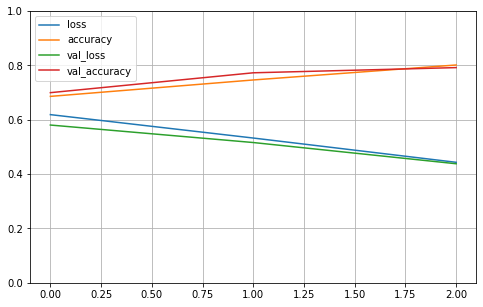

Train set ones/size 3926 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 432 / 629
Range of scores: 0.014746997 to 0.9973736
Score threshold 0.5
Prediction set ones/size 533 / 629


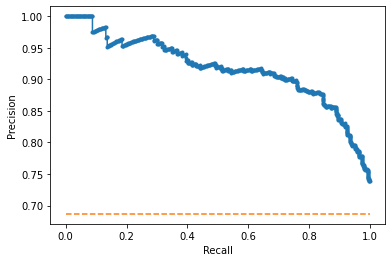

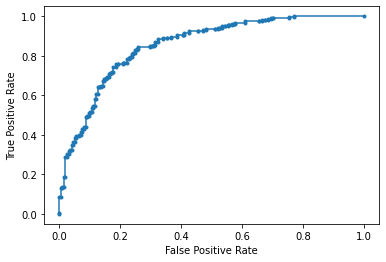

Accuracy: 79.17% Precision: 78.24% Recall: 96.53%
F1: 86.42% AUPRC: 91.71% AUROC: 85.46%
2023-02-14 18:19:35.084160
Fold 10
Discriminator is GMM
Means [0.014433632317836039, -1.8998622106504646]
Variances [0.95986923 1.43709206]
Priors [0.63424128 0.36575872]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[0 0 1 1 1 1 1 1 1]
FIT
2023-02-14 18:19:44.319842
PREDICT
2023-02-14 18:19:51.118832


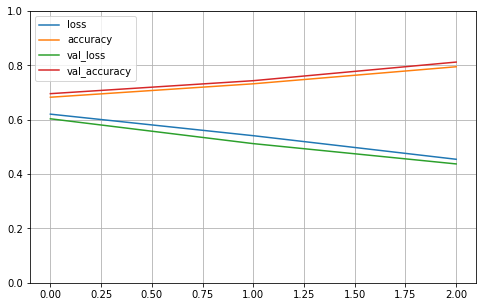

Train set ones/size 3913 / 5661
Compute valiation accuracy
Valid sizes (628, 4997) (628,)
Valid set ones/size 445 / 628
Range of scores: 0.0069809565 to 0.9952922
Score threshold 0.5
Prediction set ones/size 465 / 628


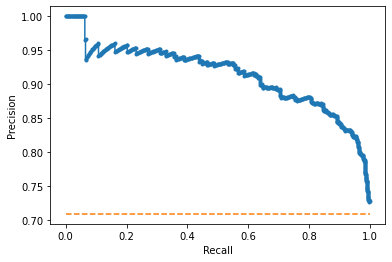

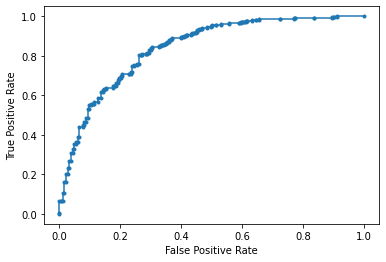

Accuracy: 81.21% Precision: 85.16% Recall: 88.99%
F1: 87.03% AUPRC: 91.37% AUROC: 83.99%
2023-02-14 18:19:51.857476

Completed cross validation 10 folds 3 epochs
 accuracy mean 80.08% +/- 1.55
 precision mean 81.57% +/- 2.58
 recall mean 92.02% +/- 3.55
 F1 mean 86.40% +/- 1.21
 AUPRC mean 91.26% +/- 1.34
 AUROC mean 84.57% +/- 1.47
Finished cell Line 13 K562

2023-02-14 18:19:53.239294
Start cell Line 14 IMR.90
Number of RCI values loaded 390
Num RCI: 390
Load sequence...
Cross validation...
2023-02-14 18:19:58.514062
splitting
Fold 1
Discriminator is GMM
Means [0.0536155422336718, -2.730757585863731]
Variances [1.98448726 4.91467572]
Priors [0.6955601 0.3044399]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 1]
FIT
2023-02-14 18:20:00.215298
PREDICT
2023-02-14 18:20:03.996630


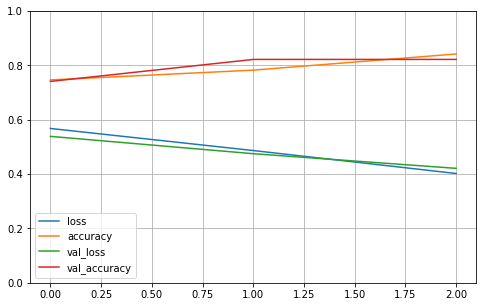

Train set ones/size 1695 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 183 / 247
Range of scores: 0.057207808 to 0.99194384
Score threshold 0.5
Prediction set ones/size 191 / 247


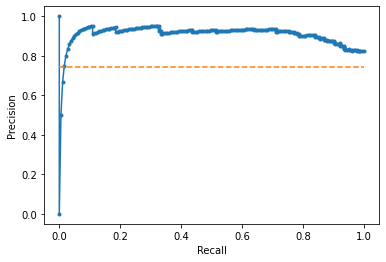

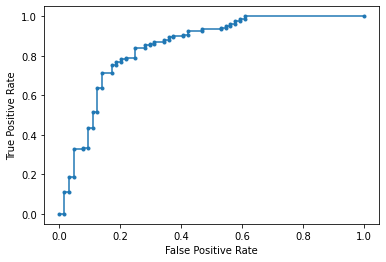

Accuracy: 82.19% Precision: 86.39% Recall: 90.16%
F1: 88.24% AUPRC: 90.65% AUROC: 84.55%
2023-02-14 18:20:04.688088
Fold 2
Discriminator is GMM
Means [0.027488464924785384, -2.7280733482755766]
Variances [2.02027366 4.99479983]
Priors [0.70228865 0.29771135]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 1]
FIT
2023-02-14 18:20:10.039877
PREDICT
2023-02-14 18:20:13.892382


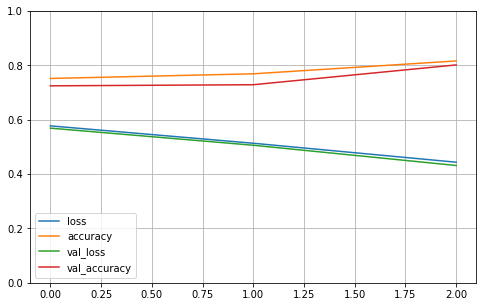

Train set ones/size 1703 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 177 / 247
Range of scores: 0.05659794 to 0.9937603
Score threshold 0.5
Prediction set ones/size 188 / 247


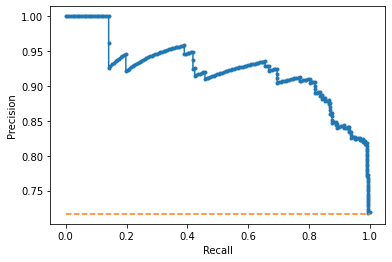

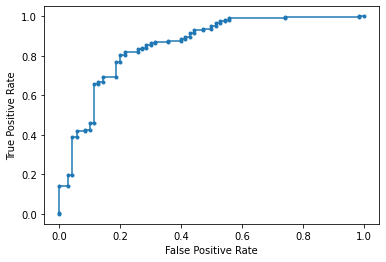

Accuracy: 80.16% Precision: 84.04% Recall: 89.27%
F1: 86.58% AUPRC: 92.32% AUROC: 85.32%
2023-02-14 18:20:14.571881
Fold 3
Discriminator is GMM
Means [-2.679677900559745, 0.04816166137715773]
Variances [4.86717388 1.99053068]
Priors [0.31125078 0.68874922]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 1]
FIT
2023-02-14 18:20:17.503444
PREDICT
2023-02-14 18:20:21.549776


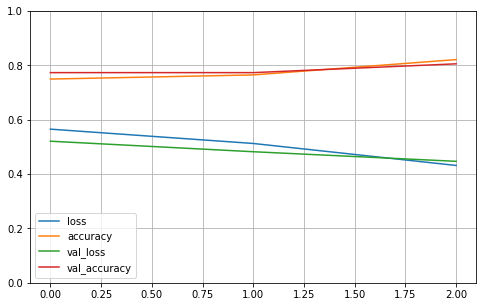

Train set ones/size 1686 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 191 / 247
Range of scores: 0.036795273 to 0.9985869
Score threshold 0.5
Prediction set ones/size 227 / 247


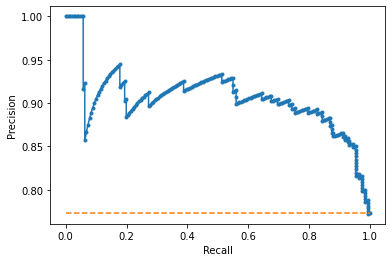

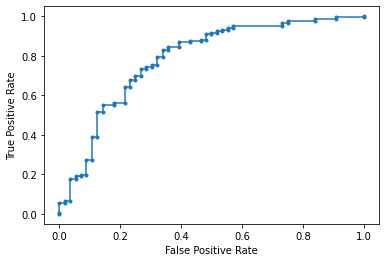

Accuracy: 80.57% Precision: 81.50% Recall: 96.86%
F1: 88.52% AUPRC: 90.48% AUROC: 78.49%
2023-02-14 18:20:22.392932
Fold 4
Discriminator is GMM
Means [0.03178569368493089, -2.669027888622976]
Variances [2.01529773 4.91285697]
Priors [0.68983747 0.31016253]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 1]
FIT
2023-02-14 18:20:25.411741
PREDICT
2023-02-14 18:20:31.488400


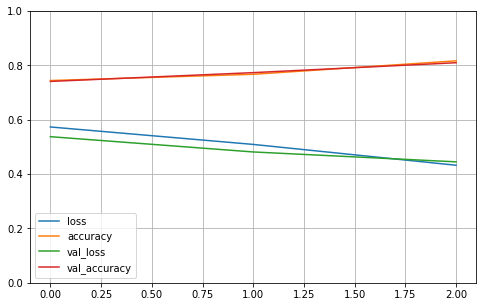

Train set ones/size 1695 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 183 / 247
Range of scores: 0.025466233 to 0.9861033
Score threshold 0.5
Prediction set ones/size 194 / 247


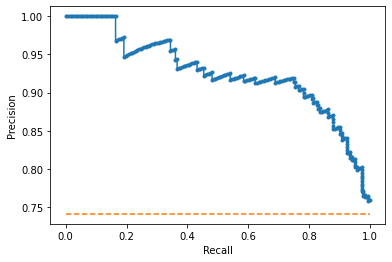

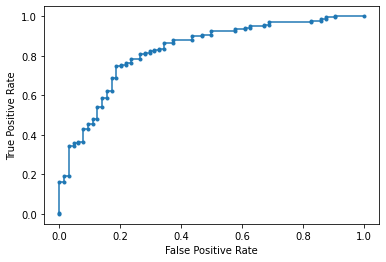

Accuracy: 80.97% Precision: 85.05% Recall: 90.16%
F1: 87.53% AUPRC: 92.52% AUROC: 82.74%
2023-02-14 18:20:32.174912
Fold 5
Discriminator is GMM
Means [0.04317100852683351, -2.6512284472374117]
Variances [2.01396856 4.91573303]
Priors [0.69216346 0.30783654]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 1]
FIT
2023-02-14 18:20:36.841362
PREDICT
2023-02-14 18:20:42.942013


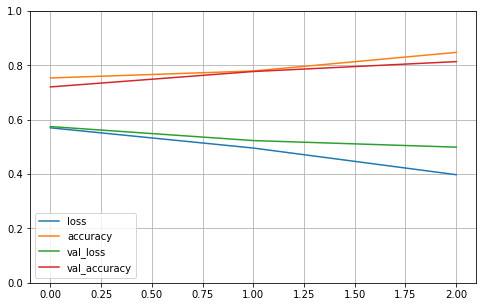

Train set ones/size 1696 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 182 / 247
Range of scores: 0.020117933 to 0.9994361
Score threshold 0.5
Prediction set ones/size 194 / 247


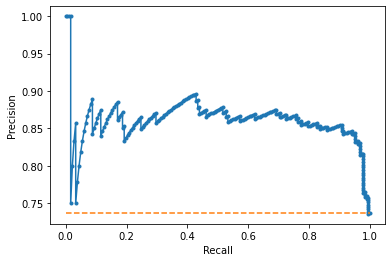

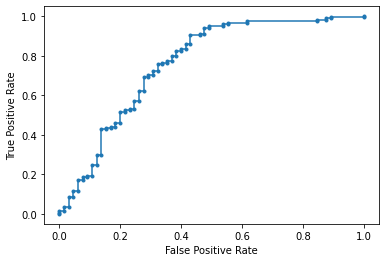

Accuracy: 81.38% Precision: 85.05% Recall: 90.66%
F1: 87.77% AUPRC: 86.05% AUROC: 76.22%
2023-02-14 18:20:43.653864
Fold 6
Discriminator is GMM
Means [0.05847411170233516, -2.7324482609130536]
Variances [2.00615047 4.82595779]
Priors [0.6915493 0.3084507]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 1]
FIT
2023-02-14 18:20:48.957439
PREDICT
2023-02-14 18:20:52.736811


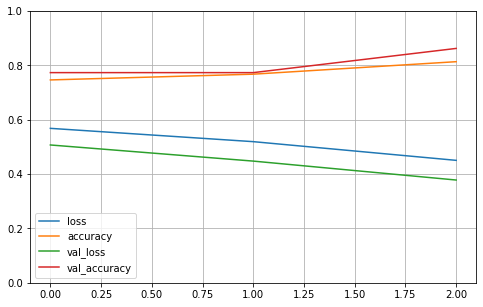

Train set ones/size 1687 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 190 / 247
Range of scores: 0.12130248 to 0.9966859
Score threshold 0.5
Prediction set ones/size 222 / 247


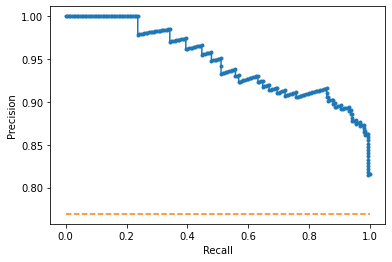

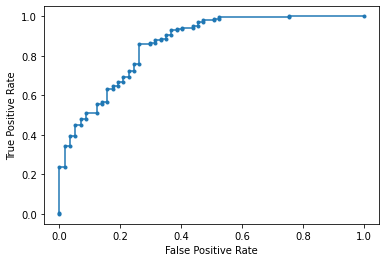

Accuracy: 86.23% Precision: 85.14% Recall: 99.47%
F1: 91.75% AUPRC: 94.71% AUROC: 85.90%
2023-02-14 18:20:53.400170
Fold 7
Discriminator is GMM
Means [0.04326213388395175, -2.6892802328515706]
Variances [2.0111666  4.88904452]
Priors [0.688846 0.311154]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 1]
FIT
2023-02-14 18:20:56.401075
PREDICT
2023-02-14 18:21:02.481135


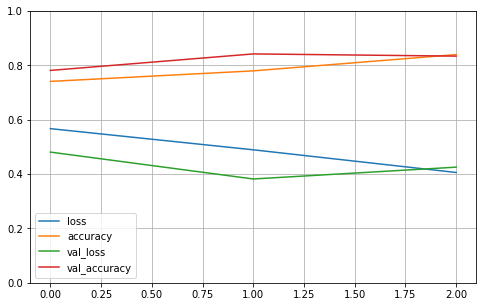

Train set ones/size 1685 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 193 / 247
Range of scores: 0.009793383 to 0.9885606
Score threshold 0.5
Prediction set ones/size 178 / 247


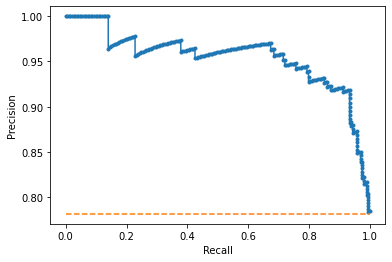

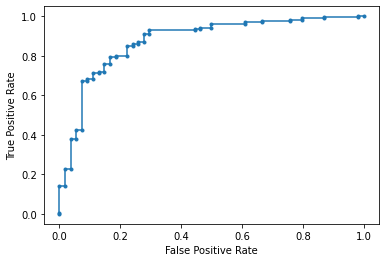

Accuracy: 83.40% Precision: 92.70% Recall: 85.49%
F1: 88.95% AUPRC: 95.45% AUROC: 87.59%
2023-02-14 18:21:03.383064
Fold 8
Discriminator is GMM
Means [-2.712678176948454, 0.05037431523018693]
Variances [4.86973245 2.01996968]
Priors [0.30809701 0.69190299]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 1]
FIT
2023-02-14 18:21:06.754183
PREDICT
2023-02-14 18:21:12.855083


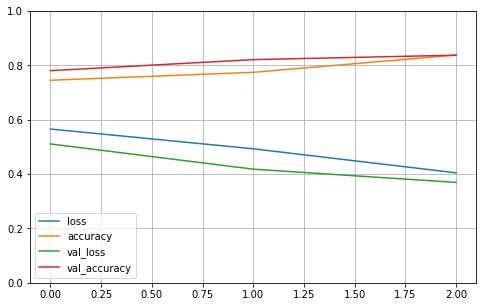

Train set ones/size 1686 / 2221
Compute valiation accuracy
Valid sizes (246, 4997) (246,)
Valid set ones/size 192 / 246
Range of scores: 0.055781335 to 0.99818546
Score threshold 0.5
Prediction set ones/size 218 / 246


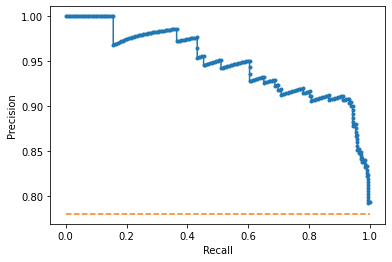

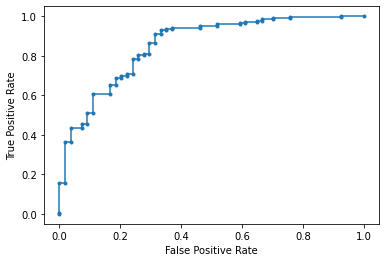

Accuracy: 83.74% Precision: 84.86% Recall: 96.35%
F1: 90.24% AUPRC: 94.80% AUROC: 85.40%
2023-02-14 18:21:13.758082
Fold 9
Discriminator is GMM
Means [0.030313708147687034, -2.706516074313908]
Variances [2.02679564 4.89641578]
Priors [0.68480322 0.31519678]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 1]
FIT
2023-02-14 18:21:16.817636
PREDICT
2023-02-14 18:21:22.916316


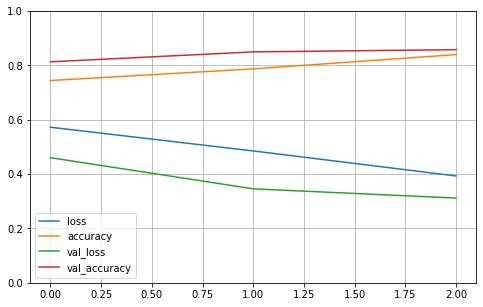

Train set ones/size 1678 / 2221
Compute valiation accuracy
Valid sizes (246, 4997) (246,)
Valid set ones/size 200 / 246
Range of scores: 0.095987916 to 0.99949384
Score threshold 0.5
Prediction set ones/size 229 / 246


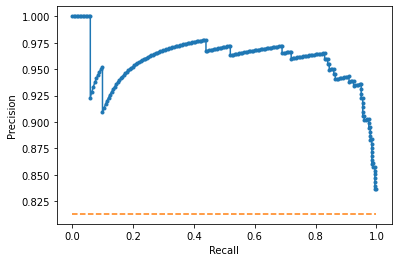

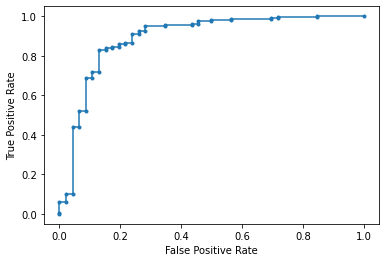

Accuracy: 85.77% Precision: 86.03% Recall: 98.50%
F1: 91.84% AUPRC: 95.80% AUROC: 89.12%
2023-02-14 18:21:23.599984
Fold 10
Discriminator is GMM
Means [0.021985498455569956, -2.7461237947736192]
Variances [2.01361685 4.98495262]
Priors [0.70172166 0.29827834]
[-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
[1 1 1 1 1 1 1 1 1]
FIT
2023-02-14 18:21:27.945292
PREDICT
2023-02-14 18:21:31.663253


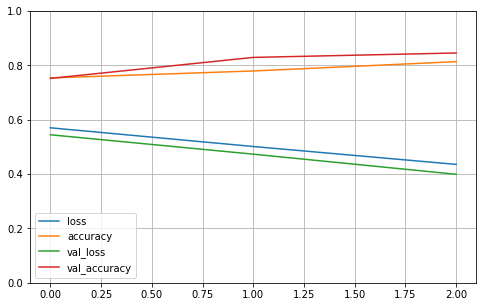

Train set ones/size 1693 / 2221
Compute valiation accuracy
Valid sizes (246, 4997) (246,)
Valid set ones/size 187 / 246
Range of scores: 0.046574347 to 0.99577326
Score threshold 0.5
Prediction set ones/size 215 / 246


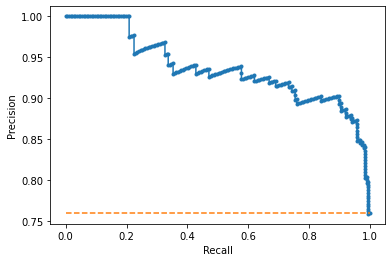

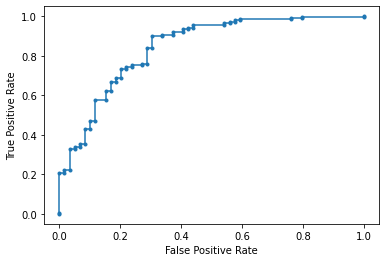

Accuracy: 84.55% Precision: 84.65% Recall: 97.33%
F1: 90.55% AUPRC: 93.63% AUROC: 84.41%
2023-02-14 18:21:32.341977

Completed cross validation 10 folds 3 epochs
 accuracy mean 82.90% +/- 2.17
 precision mean 85.54% +/- 2.84
 recall mean 93.43% +/- 4.80
 F1 mean 89.20% +/- 1.81
 AUPRC mean 92.64% +/- 2.98
 AUROC mean 83.97% +/- 3.94
Finished cell Line 14 IMR.90

2023-02-14 18:21:33.634672


In [10]:
for CELL_LINE in range(NUM_LINES):
    print(datetime.now())
    print('Start cell Line',CELL_LINE,all_cell_lines[CELL_LINE])
    loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE
    gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE)
    print('Num RCI:', len(gene_to_rci.keys()))
    print('Load sequence...')
    filepath = DATA_DIR+SEQUENCE_FILE
    allids,allseq = loader.load_sequence(filepath)
    loader = None  # drop K-mer cache to save RAM

    print("Cross validation...")
    cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
    cvdo.set_sequences(allids,allseq)
    cvdo.set_rci_map(gene_to_rci)
    cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
    cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auprc, cv_auroc = cvdo.do_cross_validation()   
    cvdo = None
    print("Completed cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
    print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy,ddof=1)))
    print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision,ddof=1)))
    print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall,ddof=1)))
    print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1,ddof=1)))
    print(" AUPRC mean %.2f%% +/- %.2f" % (np.mean(cv_auprc), np.std(cv_auprc,ddof=1)))
    print(" AUROC mean %.2f%% +/- %.2f" % (np.mean(cv_auroc), np.std(cv_auroc,ddof=1)))
    print('Finished cell Line',CELL_LINE,all_cell_lines[CELL_LINE])
    print()
print(datetime.now())